# Maintenance cost reduction through predictive techniques

You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to
Predict is called failure with binary value 0 for non-failure and 1 for failure.

You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to
Predict is called failure with binary value 0 for non-failure and 1 for failure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option("max_columns",None) 
pd.set_option("max_rows", None)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix ,roc_auc_score, roc_curve, f1_score, accuracy_score

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler, SMOTE

## reading data and profling

In [2]:
df = pd.read_csv('predictive_maintenance.csv')

In [3]:
print(df.shape)
df.head()

(124494, 12)


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
df.describe(include='all')

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494,124494,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000,124494.0000
unique,304,1169,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,1/1/15,Z1F0MA1S,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,1163,304,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,0.0009,122388103.2421,159.4848,9.9405,1.7411,14.2227,260172.6577,0.2925,0.2925,12.4515
std,NaN,NaN,0.0292,70459334.2164,2179.6577,185.7473,22.9085,15.9430,99151.0785,7.4369,7.4369,191.4256
min,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,8.0000,0.0000,0.0000,0.0000
25%,NaN,NaN,0.0000,61284762.0000,0.0000,0.0000,0.0000,8.0000,221452.0000,0.0000,0.0000,0.0000
50%,NaN,NaN,0.0000,122797388.0000,0.0000,0.0000,0.0000,10.0000,249799.5000,0.0000,0.0000,0.0000
75%,NaN,NaN,0.0000,183309640.0000,0.0000,0.0000,0.0000,12.0000,310266.0000,0.0000,0.0000,0.0000


In [5]:
df.failure.sum(), df.failure.sum()/df.failure.count()*100

(106, 0.0851446656063746)

In [6]:
df.isna().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [7]:
df.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

In [8]:
df1 = df[df.columns[2:]]

In [9]:
df1.columns

Index(['failure', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5',
       'metric6', 'metric7', 'metric8', 'metric9'],
      dtype='object')

## pair plot to understand variable correlation

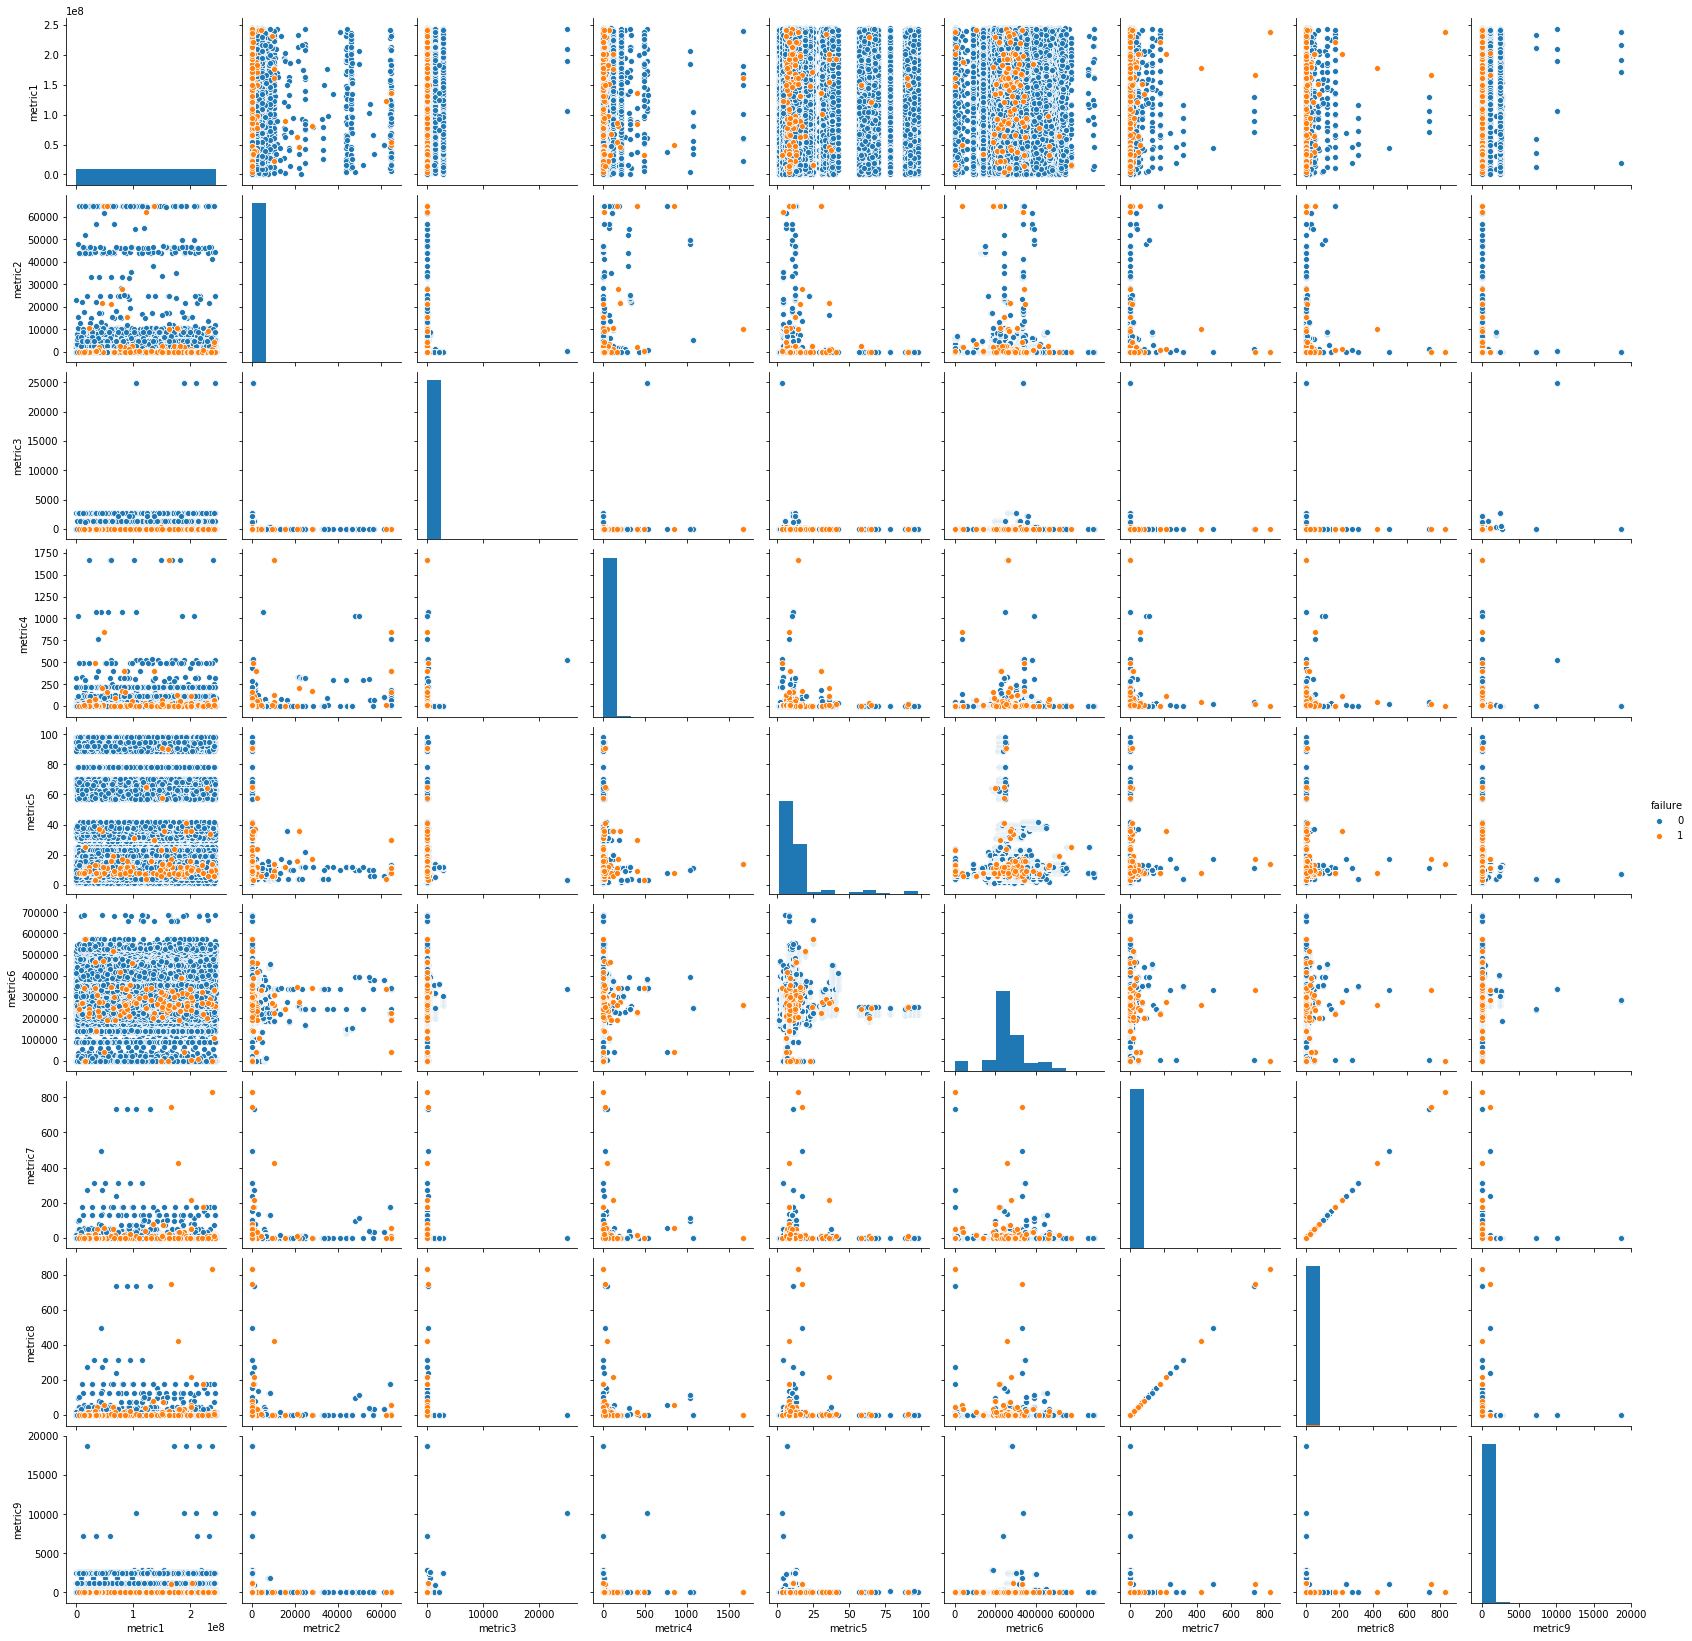

In [126]:
sns.pairplot(df1, hue= 'failure',corner=False, diag_kind='hist')

In [11]:
#seems metric 7 is same as metric 8
(df1['metric7'] ==df1['metric8']).sum(), df1.shape[0]

(124494, 124494)

In [12]:
df.drop(columns='metric8', inplace=True)

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [15]:
df[df['device']=='S1F01R2B']

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3
1167,2015-01-02,S1F01R2B,0,200864456,0,0,0,15,313173,0,3
2330,2015-01-03,S1F01R2B,0,196415520,0,0,0,15,313173,0,3
3493,2015-01-04,S1F01R2B,0,127529600,0,0,0,15,314088,0,3
4655,2015-01-05,S1F01R2B,0,158255216,0,0,0,15,315360,0,3
5816,2015-01-06,S1F01R2B,0,190692968,0,0,0,15,316629,0,3
16485,2015-01-20,S1F01R2B,0,127634552,0,0,0,17,328643,0,3
17198,2015-01-21,S1F01R2B,0,135284952,0,0,0,17,328989,0,3
17910,2015-01-22,S1F01R2B,0,10061096,0,0,0,17,329763,0,3
18622,2015-01-23,S1F01R2B,0,70633912,0,0,0,17,329763,0,3


In [16]:
for i in range(8):
    print(i, len(df['device'].str[0:i].value_counts()))

0 1
1 3
2 3
3 3
4 7
5 121
6 608
7 1104


## creating new features 

In [17]:
# upto 3, upto 4 characters as new columns
for i in [3,4]:
    df['device_'+str(i)] = df['device'].str[0:i]

In [18]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_3,device_4
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,S1F,S1F0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,S1F,S1F0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,S1F,S1F0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,S1F,S1F0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,S1F,S1F0


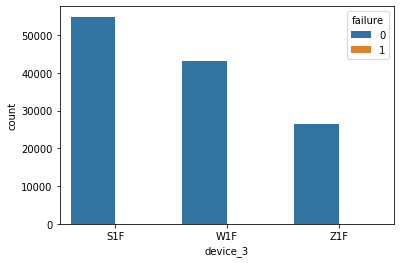

In [19]:
sns.countplot(x="device_3", hue="failure", data=df)

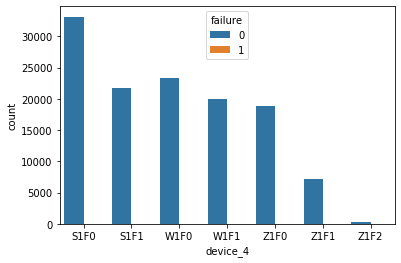

In [20]:
sns.countplot(x="device_4", hue="failure", data=df)

In [21]:
min(df['date']), max(df['date'])

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-11-02 00:00:00'))

In [22]:
# feature day of week
df['day_of_week'] = df['date'].dt.dayofweek

In [23]:
for col in df.columns:
    print(col, len(np.unique(df[col])))

date 304
device 1169
failure 2
metric1 123877
metric2 558
metric3 47
metric4 115
metric5 60
metric6 44838
metric7 28
metric9 65
device_3 3
device_4 7
day_of_week 7


## bivariate profiling of features to understand relationship with failure rate

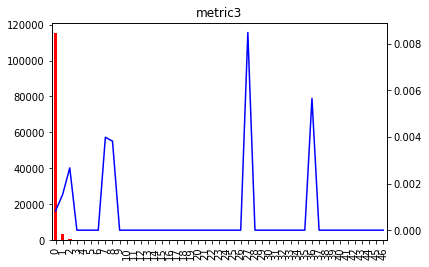

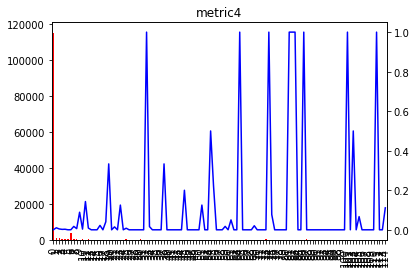

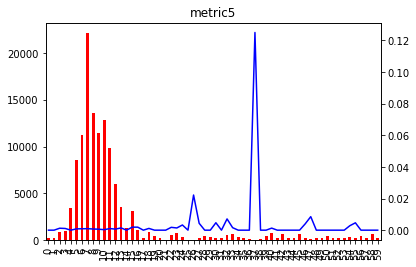

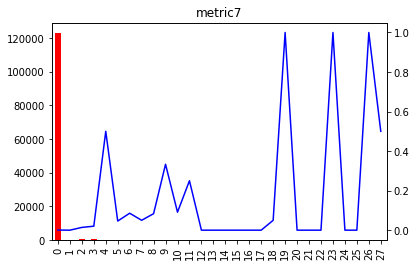

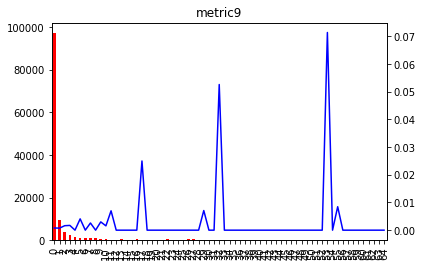

In [24]:
for col in ['metric3', 'metric4', 'metric5', 'metric7' , 'metric9']:
    df_g = df.groupby(col, as_index=False).agg({'failure':['count', 'sum']})
    df_g.columns =['_'.join(item) for item in df_g.columns ]
    df_g['rate'] =df_g['failure_sum']/df_g['failure_count']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    counts = df_g['failure_count']
    means = df_g['rate']

    counts.plot(kind='bar', color='red', ax=ax1)
    means.plot(kind='line', color='blue', ax=ax2)
    plt.title(col)
    plt.show()

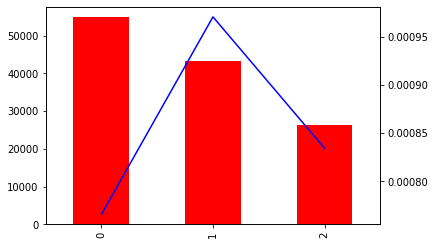

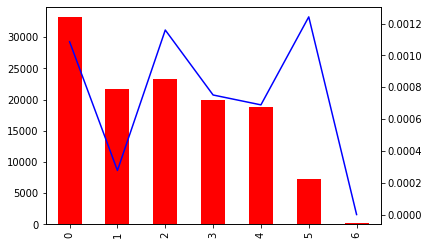

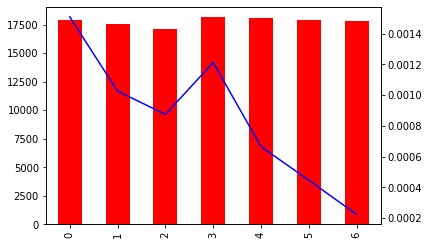

In [25]:
for col in ['device_3', 'device_4', 'day_of_week']:
    df_g = df.groupby(col, as_index=False).agg({'failure':['count', 'sum']})
    df_g.columns =['_'.join(item) for item in df_g.columns ]
    df_g['rate'] =df_g['failure_sum']/df_g['failure_count']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    counts = df_g['failure_count']
    means = df_g['rate']

    counts.plot(kind='bar', color='red', ax=ax1)
    means.plot(kind='line', color='blue', ax=ax2)

    plt.show()

In [26]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_3,device_4,day_of_week
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,S1F,S1F0,3
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,S1F,S1F0,3
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,S1F,S1F0,3
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,S1F,S1F0,3
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,S1F,S1F0,3


In [27]:
df.dtypes

date           datetime64[ns]
device                 object
failure                 int64
metric1                 int64
metric2                 int64
metric3                 int64
metric4                 int64
metric5                 int64
metric6                 int64
metric7                 int64
metric9                 int64
device_3               object
device_4               object
day_of_week             int64
dtype: object

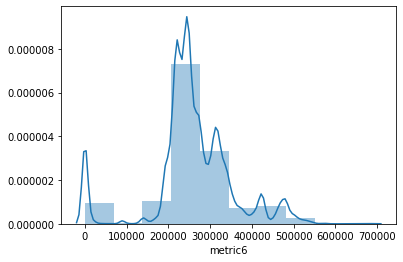

In [28]:
sns.distplot(df['metric6'], bins=10)
#sns.distplot(np.log(1+df['metric6']), bins=10)

In [29]:
df.columns

Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric9', 'device_3', 'device_4',
       'day_of_week'],
      dtype='object')

### scaling features 

In [30]:
scaler = StandardScaler()
features = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric9']
df[features]=scaler.fit_transform(df[features])

In [31]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_3,device_4,day_of_week
0,2015-01-01,S1F01085,0,1.3234,-0.0475,-0.0535,2.1939,-0.5158,1.4853,-0.0393,-0.0285,S1F,S1F0,3
1,2015-01-01,S1F0166B,0,-0.8660,-0.0732,-0.0374,-0.0760,-0.5158,1.4423,-0.0393,-0.0650,S1F,S1F0,3
2,2015-01-01,S1F01E6Y,0,0.7225,-0.0732,-0.0535,-0.0760,-0.1394,-0.2297,-0.0393,-0.0650,S1F,S1F0,3
3,2015-01-01,S1F01JE0,0,-0.6059,-0.0732,-0.0535,-0.0760,-0.5158,1.5130,-0.0393,-0.0650,S1F,S1F0,3
4,2015-01-01,S1F01R2B,0,0.1928,-0.0732,-0.0535,-0.0760,0.0488,0.5345,-0.0393,-0.0494,S1F,S1F0,3


In [32]:
#'metric4', 'metric7'
df2= pd.get_dummies(df, columns=['device_3', 'device_4','day_of_week'])

In [33]:
df2.columns

Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric9', 'device_3_S1F',
       'device_3_W1F', 'device_3_Z1F', 'device_4_S1F0', 'device_4_S1F1',
       'device_4_W1F0', 'device_4_W1F1', 'device_4_Z1F0', 'device_4_Z1F1',
       'device_4_Z1F2', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')

## creating features related to failures and counts so far

In [35]:
temp = df[['device', 'date','failure' ]]
temp.sort_values(['device', 'date'], inplace=True)

C:\Users\VMahesh4\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
temp['failure_total'] = temp['failure'].cumsum()
temp['failure_total'] =temp['failure_total']-temp['failure']

temp['count'] = 1
temp['count_total'] = temp['count'].cumsum()
temp['count_total'] =temp['count_total']- temp['count']

C:\Users\VMahesh4\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\VMahesh4\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\VMahesh4\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [37]:
df_temp_group =temp.groupby('device', as_index=False)['failure_total', 'count_total'].min()
df_temp_group.columns = ['device', 'failure_min', 'count_total_min']

C:\Users\VMahesh4\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [38]:
temp = temp.merge(df_temp_group, on = 'device', how = 'inner')

In [39]:
temp['failure_total'] = temp['failure_total'] - temp['failure_min']
temp['count_total'] = temp['count_total'] - temp['count_total_min']
temp.drop(columns=['failure_min', 'count_total_min', 'count'], inplace=True)

In [40]:
df2 = df2.merge(temp, on = ['device', 'date', 'failure'], how = 'inner')

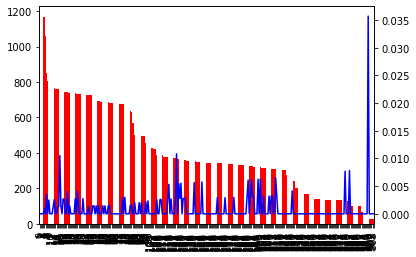

In [41]:
for col in ['count_total']:
    df_g = df2.groupby(col, as_index=False).agg({'failure':['count', 'sum']})
    df_g.columns =['_'.join(item) for item in df_g.columns ]
    df_g['rate'] =df_g['failure_sum']/df_g['failure_count']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    counts = df_g['failure_count']
    means = df_g['rate']

    counts.plot(kind='bar', color='red', ax=ax1)
    means.plot(kind='line', color='blue', ax=ax2)

    plt.show()

# Modeling

In [42]:
df_x = df2.drop(columns=['date', 'device', 'failure'])
df_y = df2['failure']

train_x, test_x,train_y ,test_y = train_test_split(df_x, df_y, train_size=0.8 , random_state=123,
                                                  stratify = df_y)

In [43]:
train_y.sum()/train_y.count(), test_y.sum()/test_y.count()

(0.0008534479296357283, 0.0008433734939759036)

#### Basic RF Model to understand importance of features and power of model

In [44]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=8, verbose=2, n_jobs=4)
rf.fit(train_x, train_y)
pred_y = rf.predict(test_x)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000building tree 34 of 1000

building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s



building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000building tree 76 of 1000

building tree 77 of 1000
building tree 78 of 1000
building tree 79 of 1000
building tree 80 of 1000
building tree 81 of 1000
building tree 82 of 1000

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.4s


building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000building tree 192 of 1000

building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000
building tree 201 of 1000
building tree 202 of 1000
building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   10.0s



building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000
building tr

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   17.6s



building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tr

building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   26.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [45]:
df_imp = pd.DataFrame({'col': df_x.columns, 'imp':rf.feature_importances_})
df_imp.sort_values('imp', ascending = False)

,col,imp
5,metric6,0.1402
26,count_total,0.1214
0,metric1,0.1211
3,metric4,0.1208
6,metric7,0.1163
1,metric2,0.1059
4,metric5,0.0660
7,metric9,0.0323
18,day_of_week_0,0.0212
13,device_4_W1F0,0.0150


In [46]:
# feature_select = SelectFromModel(rf, prefit=True, threshold= 0.01)
# df_x_new = feature_select.transform(df_x)

In [47]:
# f_col = list(feature_select.get_support())
# columns_selected = [item for i, item in enumerate(df_x.columns) if f_col[i]]

In [48]:
# df_x_new.shape

(124496, 15)

#### Model Evaluation

In [49]:
pred_y = rf.predict(test_x)
print(classification_report(test_y, pred_y))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24879
           1       0.00      0.00      0.00        21

    accuracy                           1.00     24900
   macro avg       0.50      0.50      0.50     24900
weighted avg       1.00      1.00      1.00     24900



[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished
C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [50]:
pred_y = rf.predict_proba(test_x)
pred_y=[item[1] for item in pred_y]
sum(pred_y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


20.021750329302026

0.9336407258751405


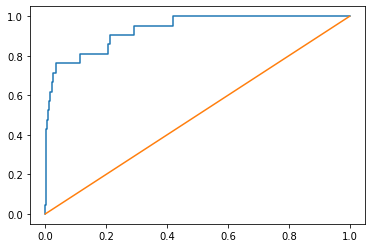

In [51]:
# AUC
print(roc_auc_score(test_y,pred_y))
fpr, tpr,x = roc_curve(test_y,pred_y)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])

In [52]:
pred_y = rf.predict_proba(test_x)
pred_y=[item[1] for item in pred_y]

f1= []
acc=[]
score = np.arange(0,1.01, 0.01)
for i in score:
    pred_y1 = [1 if item>i else 0 for item in pred_y ]
    f1.append(f1_score(test_y, pred_y1))
    acc.append(accuracy_score(test_y, pred_y1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


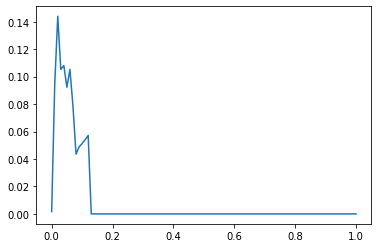

In [53]:
plt.plot(score, f1)

In [54]:
sc= score[f1.index(max(f1))]
pred_y1 = [1 if item>sc else 0 for item in pred_y ]
print(classification_report(test_y, pred_y1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24879
           1       0.09      0.43      0.14        21

    accuracy                           1.00     24900
   macro avg       0.54      0.71      0.57     24900
weighted avg       1.00      1.00      1.00     24900



# Tuning Model further

### Oversampling/Undersampling

In [55]:
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [56]:
train_x, test_x,train_y ,test_y = train_test_split(df_x, df_y, train_size=0.8 , random_state=123,
                                                  stratify = df_y)

rus = SMOTE(random_state=42) # chosen SMOTE- better performance. Other stats in Line 62
res_X, res_Y = rus.fit_resample(train_x, train_y)
res_X.shape, res_Y.sum()

((199022, 27), 99511)

In [57]:
rf = RandomForestClassifier(n_estimators=1000, random_state=21, n_jobs=4, verbose=2)
rf.fit(res_X, res_Y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000building tree 2 of 1000

building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.4s


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000building tree 50 of 1000

building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   13.0s


building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000building tree 196 of 1000

building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   34.9s


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tre

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.0min


building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tre

building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.5min finished


RandomForestClassifier(n_estimators=1000, n_jobs=4, random_state=21, verbose=2)

In [58]:
df_imp = pd.DataFrame({'col':df_x.columns, 'imp':rf.feature_importances_})
#df_imp = pd.DataFrame({'col':columns_selected, 'imp':rf.feature_importances_})
df_imp.sort_values('imp', ascending = False)

,col,imp
3,metric4,0.2741
1,metric2,0.1732
6,metric7,0.1364
9,device_3_W1F,0.0395
26,count_total,0.0388
8,device_3_S1F,0.0349
10,device_3_Z1F,0.0339
4,metric5,0.0337
5,metric6,0.0257
12,device_4_S1F1,0.0206


In [59]:
pred_y = rf.predict_proba(test_x)
pred_y=[item[1] for item in pred_y]
sum(pred_y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


26.59100000000052

0.9320042338250465


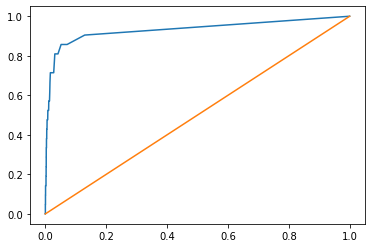

In [60]:
print(roc_auc_score(test_y,pred_y))
fpr, tpr,x = roc_curve(test_y,pred_y)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])

In [61]:
pred_y = rf.predict_proba(test_x)
pred_y=[item[1] for item in pred_y]

f1= []
acc=[]
score = np.arange(0,1.01, 0.01)
for i in score:
    pred_y1 = [1 if item>i else 0 for item in pred_y ]
    f1.append(f1_score(test_y, pred_y1)) 
    acc.append(accuracy_score(test_y, pred_y1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


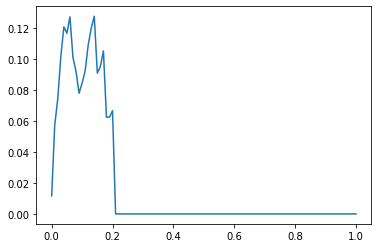

In [62]:
plt.plot(score, f1)

In [63]:
sc= score[f1.index(max(f1))]
sc=0.01
pred_y1 = [1 if item>sc else 0 for item in pred_y ]
# pred_y1= rf.predict(test_x)
print(classification_report(test_y, pred_y1))
confusion_matrix(test_y, pred_y1)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24879
           1       0.03      0.71      0.06        21

    accuracy                           0.98     24900
   macro avg       0.51      0.85      0.52     24900
weighted avg       1.00      0.98      0.99     24900



array([[24391,   488],
       [    6,    15]], dtype=int64)

In [64]:
# SMOTE: 93.2%
# RandomUndersample: 90.03%
# RandomOversample: 88.23%

# Chosen SMOTE for improving predictive power

# K-Fold cross validation

In [65]:
from sklearn.model_selection import KFold, StratifiedKFold

(99596, 27) 84 (24900, 27) 22
(199024, 27) 99512
0.8769467729794124 22


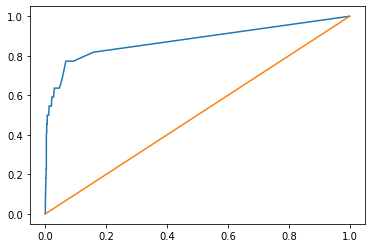

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512
0.8439566034629946 21


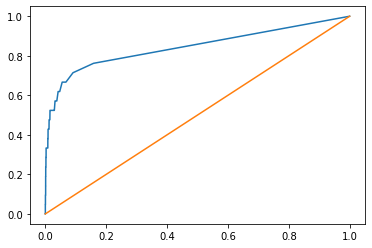

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512
0.9119292624196556 21


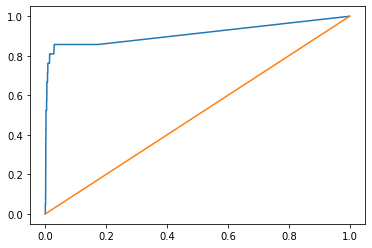

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512
0.871835509668133 21


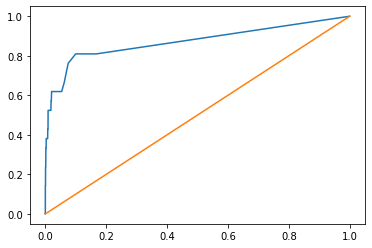

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512
0.9299400120205651 21


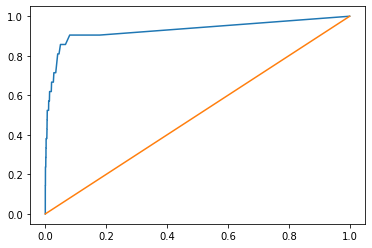

In [66]:
kf = StratifiedKFold(n_splits=5, random_state=123,  shuffle=True)
auc=[]
y_all=[]
y_pred_all=[]
for train_index, test_index in kf.split(df_x, df_y):
    X_train, X_test = df_x.iloc[train_index, :], df_x.iloc[test_index, :]
    y_train, y_test = df_y[train_index], df_y[test_index]
    print(X_train.shape,sum(y_train), X_test.shape,sum(y_test) )
    
    rus = SMOTE(random_state=42)
    res_X, res_Y = rus.fit_resample(X_train, y_train)
    print(res_X.shape, res_Y.sum())
    
    rf = RandomForestClassifier(n_estimators=2000, random_state=21, n_jobs=4, verbose=0)
    rf.fit(res_X, res_Y)
    
    pred_y = rf.predict_proba(X_test)
    pred_y=[item[1] for item in pred_y]
    y_all=y_all+ list(y_test)
    y_pred_all=y_pred_all+ list(pred_y)
    
    auc.append(roc_auc_score(y_test,pred_y))
    print(auc[-1], sum(y_test))
    fpr, tpr,x = roc_curve(y_test,pred_y)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.show()

In [67]:
print(sum(y_all), len(y_all))

106 124496


0.8863669802978156


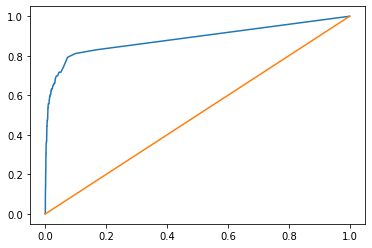

In [68]:
print(roc_auc_score(y_all, y_pred_all))
fpr, tpr, x = roc_curve(y_all, y_pred_all)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.show()

In [128]:
# overall AUC is 88% 

## Chosing the modeling technique using cross validation 

LR
0.7103209115026785 22


C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


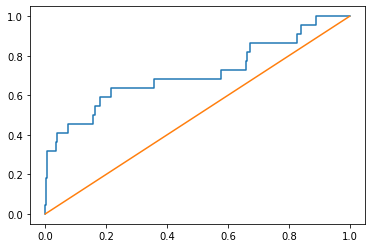

C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6733660262078945 21


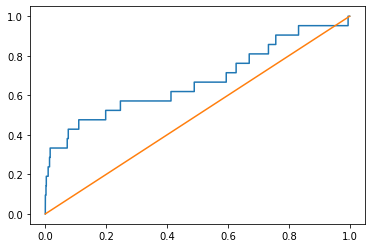

C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.844293485542782 21


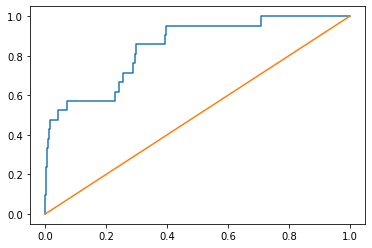

C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.661825900872448 21


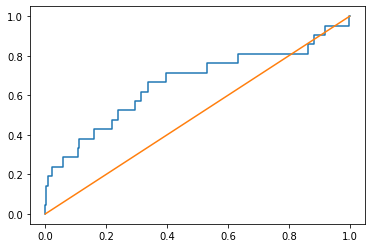

0.8430904719794502 21


C:\Users\VMahesh4\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


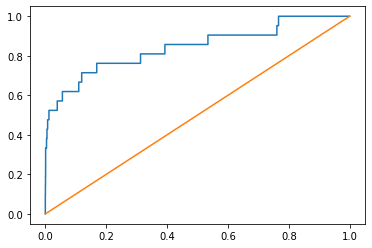

final AUC score: 0.7412202112345984 for model LR


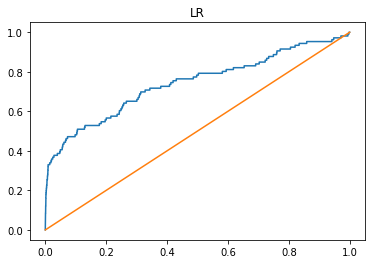

RF
0.8134679051955359 22


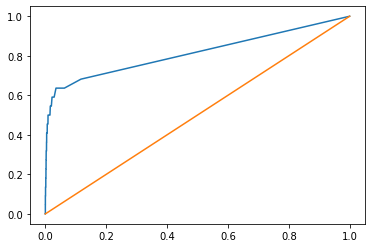

0.8271077142168066 21


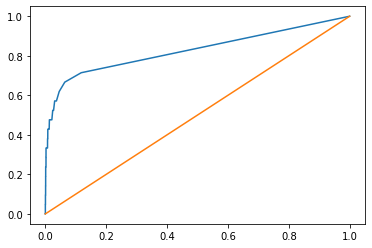

0.9154358986138068 21


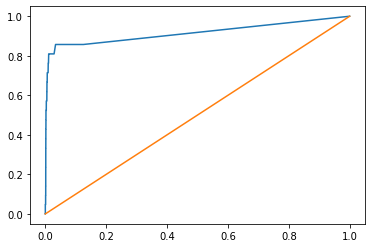

0.8503152527189829 21


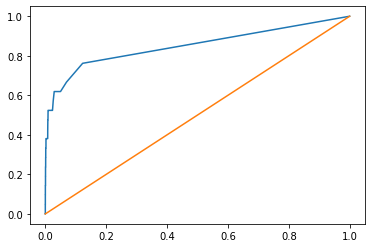

0.9090944762823532 21


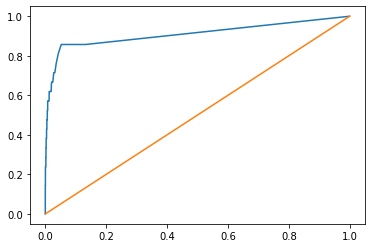

final AUC score: 0.8623053709650264 for model RF


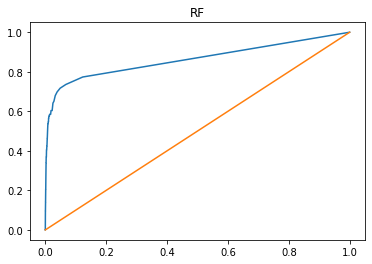

GBM
0.8523558602343071 22


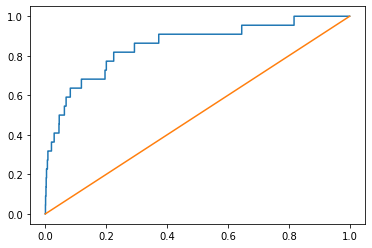

0.7289372136023795 21


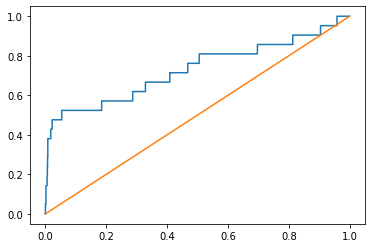

0.9085920243167611 21


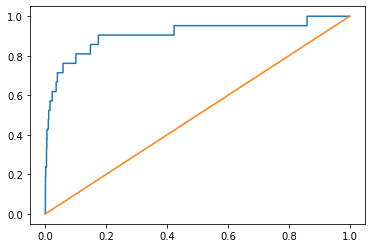

0.8397178229761235 21


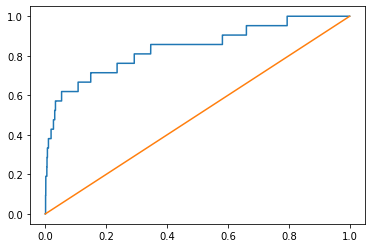

0.8733208533835594 21


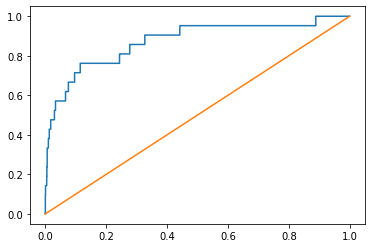

final AUC score: 0.8385164887670702 for model GBM


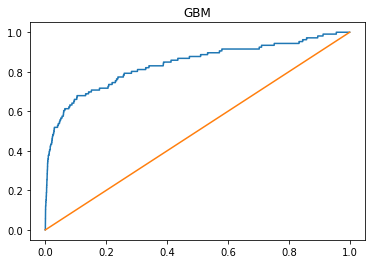

XGBoost


C:\Users\VMahesh4\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8716226092421928 22


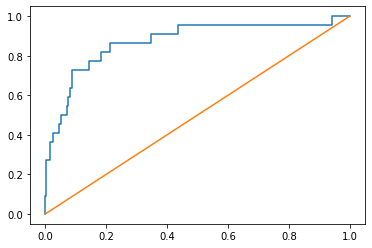

C:\Users\VMahesh4\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.7963863654634616 21


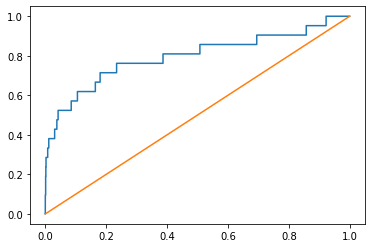

C:\Users\VMahesh4\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.9086647602203515 21


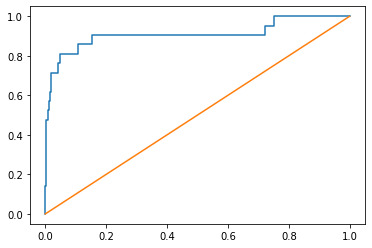

C:\Users\VMahesh4\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8546832351398634 21


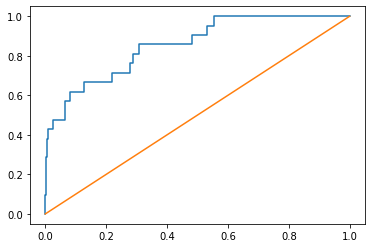

C:\Users\VMahesh4\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8850485607861602 21


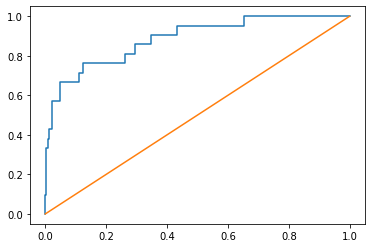

final AUC score: 0.861382186579944 for model XGBoost


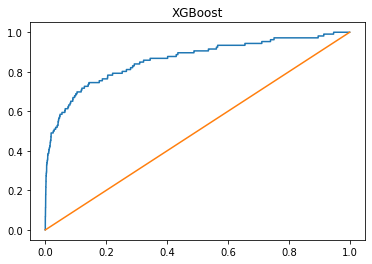

In [77]:
log_regr=LogisticRegression()
# svm = SVC()
rf = RandomForestClassifier(n_estimators=1000, n_jobs=4)
gbm =GradientBoostingClassifier(n_estimators=300)
xgboost_clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.8, 
                                learning_rate = 0.1, n_jobs=4, n_estimators = 1000,
                                eval_metric='auc', early_stopping_rounds=50)

models = [log_regr, rf, gbm,  xgboost_clf ]
model_name = ['LR',  'RF', 'GBM', 'XGBoost']

for i, mdl in enumerate(models):
    print(model_name[i])
    kf = StratifiedKFold(n_splits=5, random_state=123,  shuffle=True)
    auc=[]
    y_all=[]
    y_pred_all=[]
    for train_index, test_index in kf.split(df_x, df_y):
        X_train, X_test = df_x.iloc[train_index, :], df_x.iloc[test_index, :]
        y_train, y_test = df_y[train_index], df_y[test_index]
#         print(X_train.shape,sum(y_train), X_test.shape,sum(y_test) )

        rus = SMOTE(random_state=42)
        res_X, res_Y = rus.fit_resample(X_train, y_train)
#         print(res_X.shape, res_Y.sum())

        mdl.fit(res_X, res_Y)

        pred_y = mdl.predict_proba(X_test)
        pred_y=[item[1] for item in pred_y]
        y_all=y_all+ list(y_test)
        y_pred_all=y_pred_all+ list(pred_y)

        auc.append(roc_auc_score(y_test,pred_y))
        print(auc[-1], sum(y_test))
        fpr, tpr,x = roc_curve(y_test,pred_y)
        plt.plot(fpr, tpr)
        plt.plot([0,1], [0,1])
        plt.show()

    print('final AUC score:', roc_auc_score(y_all, y_pred_all), 'for model' , model_name[i])
    fpr, tpr,x = roc_curve(y_all,y_pred_all)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.title(model_name[i])
    plt.show()


In [ ]:
# LR AUC: 74.1%
# RF: 86.23%
# GBM: 83.8%
# XGBoost: 86.13%

# RF is best with 2000 trees - AUC 88.6%

## Grid Search for Best RF parameters

In [71]:
parameters = {'n_estimators': [2000], 'criterion': ['gini', 'entropy'], 
              }
rf = RandomForestClassifier(random_state=123)
clf = GridSearchCV(rf, parameters, cv = 5, verbose =2, n_jobs=4, scoring='roc_auc')
clf.fit(df_x, df_y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [2000]},
             scoring='roc_auc', verbose=2)

In [72]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,195.3672,7.0945,4.7114,0.4385,gini,2000,"{'criterion': 'gini', 'n_estimators': 2000}",0.9047,0.8811,0.8184,0.7681,0.6853,0.8115,0.0792,2
1,170.9419,25.7544,3.9474,0.9559,entropy,2000,"{'criterion': 'entropy', 'n_estimators': 2000}",0.9142,0.8564,0.8443,0.8223,0.7309,0.8336,0.0597,1


2000 gini None
final AUC score: 0.8770451880649266


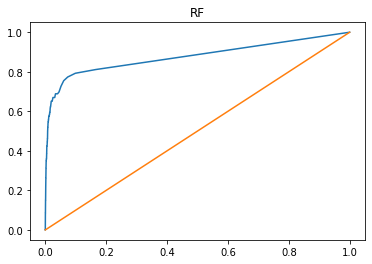

2000 gini 14
final AUC score: 0.8667808338654899


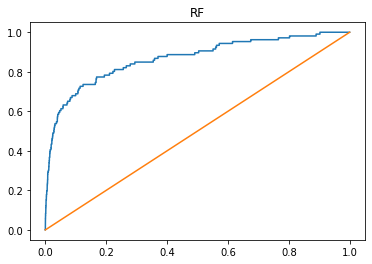

2000 gini 18
final AUC score: 0.8849812367371641


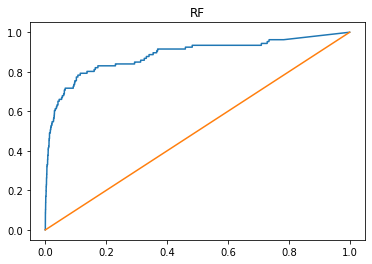

2000 entropy None
final AUC score: 0.8847997472951021


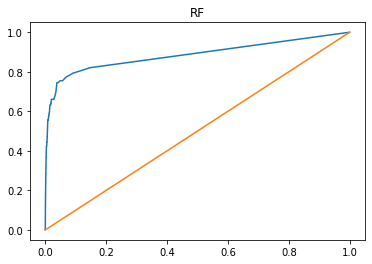

2000 entropy 14
final AUC score: 0.8596954648116772


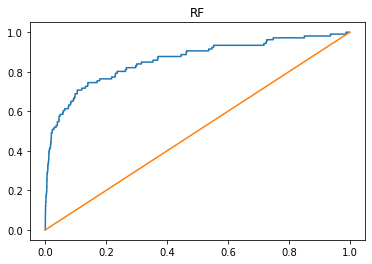

2000 entropy 18
final AUC score: 0.8895976895552181


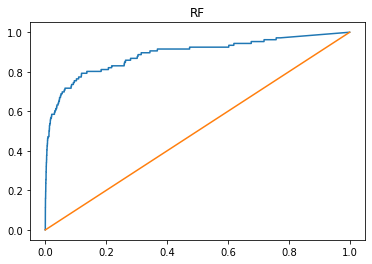

5000 gini None
final AUC score: 0.8835800593689658


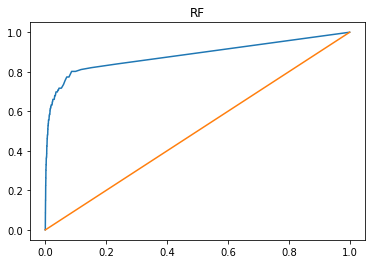

5000 gini 14
final AUC score: 0.874625834449472


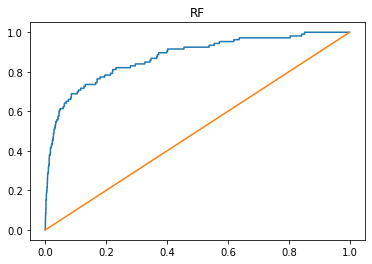

5000 gini 18
final AUC score: 0.8943141777155538


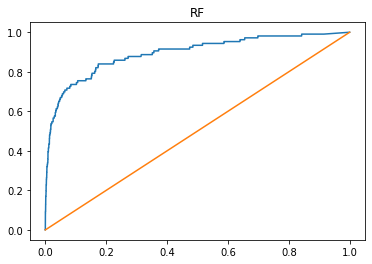

5000 entropy None
final AUC score: 0.8977018415907365


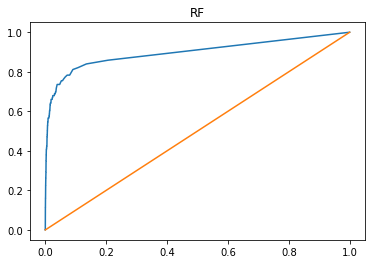

5000 entropy 14
final AUC score: 0.8644882877498798


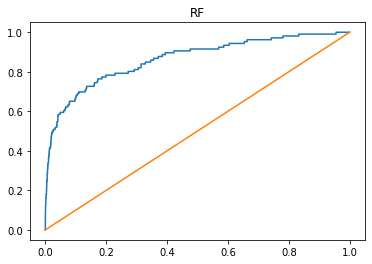

5000 entropy 18
final AUC score: 0.8977275898839164


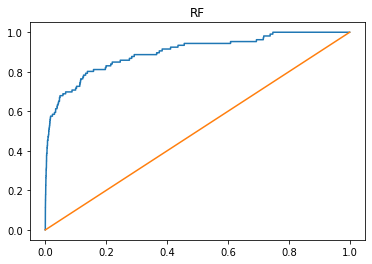

7000 gini None
final AUC score: 0.8969406553035416


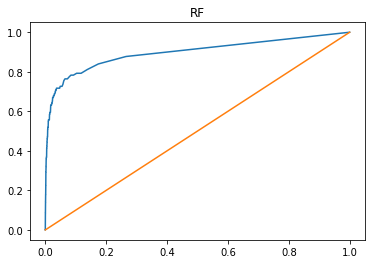

7000 gini 14
final AUC score: 0.866315999435737


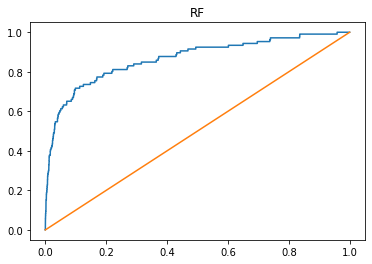

7000 gini 18
final AUC score: 0.8911171422200717


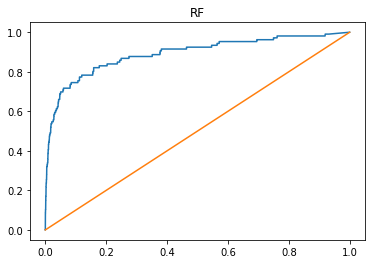

7000 entropy None
final AUC score: 0.9034542529809623


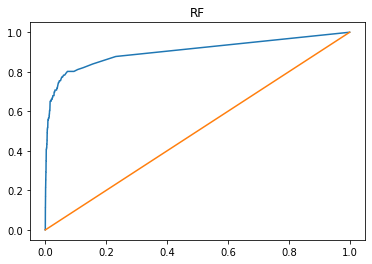

7000 entropy 14
final AUC score: 0.8629560557406939


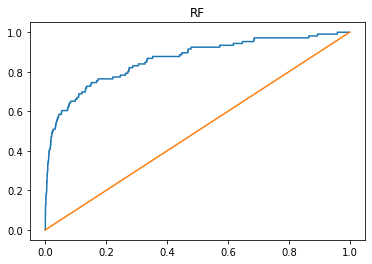

7000 entropy 18
final AUC score: 0.8894179065537938


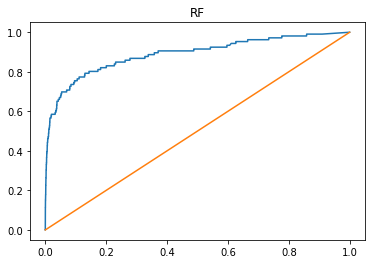

In [73]:
# Grid Search using SMOTE and searching over parameters
header = ['n_est', 'criteri', 'depth', 'auc_split_1', 'auc_split_2', 'auc_split_3'
          , 'auc_split_4', 'auc_split_5', 'mean_auc', 'auc_overall']
df_metric = pd.DataFrame()

for n_est in [ 2000, 5000, 7000]: # 
    for criteri in ['gini', 'entropy']: #, 
        for depth in [None, 14, 18 ]: #
            print(n_est, criteri, depth)
            kf = StratifiedKFold(n_splits=5, random_state=123,  shuffle=True)
            auc=[]
            y_all=[]
            y_pred_all=[]
            for train_index, test_index in kf.split(df_x, df_y):
                X_train, X_test = df_x.iloc[train_index, :], df_x.iloc[test_index, :]
                y_train, y_test = df_y[train_index], df_y[test_index]

                rus = SMOTE(random_state=42)
                res_X, res_Y = rus.fit_resample(X_train, y_train)
                mdl = RandomForestClassifier(n_estimators=n_est, criterion= criteri, 
                                             n_jobs=4, max_depth= depth)
                mdl.fit(res_X, res_Y)

                pred_y = mdl.predict_proba(X_test)
                pred_y=[item[1] for item in pred_y]
                y_all=y_all+ list(y_test)
                y_pred_all=y_pred_all+ list(pred_y)

                auc.append(roc_auc_score(y_test,pred_y))
#                 print(auc[-1], sum(y_test))
#                 fpr, tpr,x = roc_curve(y_test,pred_y)
#                 plt.plot(fpr, tpr)
#                 plt.plot([0,1], [0,1])
#                 plt.show()

            print('final AUC score:', roc_auc_score(y_all, y_pred_all))
            
            fpr, tpr,x = roc_curve(y_all,y_pred_all)
            plt.plot(fpr, tpr)
            plt.plot([0,1], [0,1])
            plt.title('RF')
            plt.show()
            
            t= pd.DataFrame([[n_est, criteri, depth, auc[0], auc[1], auc[2], auc[3], auc[4],
                              sum(auc)/len(auc), roc_auc_score(y_all, y_pred_all)]]
                            , columns=header)
            df_metric= df_metric.append(t)

In [76]:
# choosing parameter with best overall AUC and mean AUC
df_metric.sort_values('auc_overall', ascending = False)

,n_est,criteri,depth,auc_split_1,auc_split_2,auc_split_3,auc_split_4,auc_split_5,mean_auc,auc_overall
0,7000,entropy,None,0.8898,0.8627,0.9083,0.9097,0.9500,0.9041,0.9035
0,5000,entropy,18,0.9208,0.8525,0.9133,0.8800,0.9264,0.8986,0.8977
0,5000,entropy,None,0.8950,0.8636,0.9100,0.8911,0.9319,0.8983,0.8977
0,7000,gini,None,0.9025,0.8320,0.9250,0.9027,0.9255,0.8975,0.8969
0,5000,gini,18,0.9106,0.8334,0.9182,0.8949,0.9174,0.8949,0.8943
0,7000,gini,18,0.9267,0.8253,0.9101,0.8831,0.9132,0.8917,0.8911
0,2000,entropy,18,0.8978,0.8447,0.9124,0.8817,0.9197,0.8913,0.8896
0,7000,entropy,18,0.9094,0.8329,0.9130,0.8892,0.9133,0.8915,0.8894
0,2000,gini,18,0.9157,0.8183,0.8790,0.9031,0.9069,0.8846,0.8850
0,2000,entropy,None,0.8575,0.8499,0.9147,0.8706,0.9349,0.8855,0.8848


In [129]:
# best model based on overall / mean_auc from cross validation 
# Depth - None; Criteria: entropy; n_est = 7000
# rebuilding model

### Building final Model and scoring the dataset using cross validation technique

(99596, 27) 84 (24900, 27) 22
(199024, 27) 99512


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 7000
building tree 2 of 7000
building tree 3 of 7000
building tree 4 of 7000
building tree 5 of 7000
building tree 6 of 7000
building tree 7 of 7000
building tree 8 of 7000
building tree 9 of 7000
building tree 10 of 7000
building tree 11 of 7000
building tree 12 of 7000
building tree 13 of 7000
building tree 14 of 7000
building tree 15 of 7000
building tree 16 of 7000
building tree 17 of 7000
building tree 18 of 7000
building tree 19 of 7000
building tree 20 of 7000
building tree 21 of 7000
building tree 22 of 7000building tree 23 of 7000

building tree 24 of 7000
building tree 25 of 7000
building tree 26 of 7000
building tree 27 of 7000
building tree 28 of 7000
building tree 29 of 7000
building tree 30 of 7000
building tree 31 of 7000
building tree 32 of 7000
building tree 33 of 7000
building tree 34 of 7000
building tree 35 of 7000
building tree 36 of 7000


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.6s


building tree 37 of 7000
building tree 38 of 7000
building tree 39 of 7000
building tree 40 of 7000
building tree 41 of 7000
building tree 42 of 7000
building tree 43 of 7000
building tree 44 of 7000
building tree 45 of 7000
building tree 46 of 7000
building tree 47 of 7000
building tree 48 of 7000
building tree 49 of 7000building tree 50 of 7000

building tree 51 of 7000
building tree 52 of 7000
building tree 53 of 7000
building tree 54 of 7000
building tree 55 of 7000
building tree 56 of 7000
building tree 57 of 7000
building tree 58 of 7000
building tree 59 of 7000
building tree 60 of 7000
building tree 61 of 7000
building tree 62 of 7000
building tree 63 of 7000
building tree 64 of 7000
building tree 65 of 7000
building tree 66 of 7000
building tree 67 of 7000
building tree 68 of 7000building tree 69 of 7000

building tree 70 of 7000
building tree 71 of 7000
building tree 72 of 7000
building tree 73 of 7000building tree 74 of 7000

building tree 75 of 7000
building tree 76 of 7000


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   16.1s


building tree 160 of 7000
building tree 161 of 7000
building tree 162 of 7000
building tree 163 of 7000
building tree 164 of 7000
building tree 165 of 7000
building tree 166 of 7000
building tree 167 of 7000
building tree 168 of 7000
building tree 169 of 7000
building tree 170 of 7000
building tree 171 of 7000
building tree 172 of 7000
building tree 173 of 7000
building tree 174 of 7000
building tree 175 of 7000
building tree 176 of 7000
building tree 177 of 7000
building tree 178 of 7000building tree 179 of 7000

building tree 180 of 7000
building tree 181 of 7000
building tree 182 of 7000
building tree 183 of 7000
building tree 184 of 7000
building tree 185 of 7000
building tree 186 of 7000
building tree 187 of 7000
building tree 188 of 7000
building tree 189 of 7000
building tree 190 of 7000
building tree 191 of 7000
building tree 192 of 7000
building tree 193 of 7000
building tree 194 of 7000
building tree 195 of 7000
building tree 196 of 7000
building tree 197 of 7000
building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   36.8s



building tree 363 of 7000
building tree 364 of 7000
building tree 365 of 7000
building tree 366 of 7000
building tree 367 of 7000
building tree 368 of 7000
building tree 369 of 7000
building tree 370 of 7000
building tree 371 of 7000
building tree 372 of 7000
building tree 373 of 7000
building tree 374 of 7000
building tree 375 of 7000
building tree 376 of 7000
building tree 377 of 7000
building tree 378 of 7000
building tree 379 of 7000
building tree 380 of 7000
building tree 381 of 7000
building tree 382 of 7000
building tree 383 of 7000
building tree 384 of 7000
building tree 385 of 7000
building tree 386 of 7000
building tree 387 of 7000
building tree 388 of 7000
building tree 389 of 7000
building tree 390 of 7000
building tree 391 of 7000
building tree 392 of 7000
building tree 393 of 7000
building tree 394 of 7000
building tree 395 of 7000
building tree 396 of 7000
building tree 397 of 7000
building tree 398 of 7000
building tree 399 of 7000
building tree 400 of 7000
building tr

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.0min


building tree 644 of 7000
building tree 645 of 7000
building tree 646 of 7000
building tree 647 of 7000
building tree 648 of 7000
building tree 649 of 7000
building tree 650 of 7000
building tree 651 of 7000
building tree 652 of 7000
building tree 653 of 7000
building tree 654 of 7000
building tree 655 of 7000
building tree 656 of 7000
building tree 657 of 7000
building tree 658 of 7000
building tree 659 of 7000
building tree 660 of 7000
building tree 661 of 7000
building tree 662 of 7000
building tree 663 of 7000
building tree 664 of 7000
building tree 665 of 7000
building tree 666 of 7000
building tree 667 of 7000
building tree 668 of 7000
building tree 669 of 7000
building tree 670 of 7000
building tree 671 of 7000
building tree 672 of 7000
building tree 673 of 7000
building tree 674 of 7000
building tree 675 of 7000
building tree 676 of 7000
building tree 677 of 7000
building tree 678 of 7000
building tree 679 of 7000
building tree 680 of 7000
building tree 681 of 7000
building tre

building tree 960 of 7000
building tree 961 of 7000
building tree 962 of 7000
building tree 963 of 7000
building tree 964 of 7000
building tree 965 of 7000
building tree 966 of 7000
building tree 967 of 7000
building tree 968 of 7000
building tree 969 of 7000
building tree 970 of 7000
building tree 971 of 7000
building tree 972 of 7000
building tree 973 of 7000
building tree 974 of 7000
building tree 975 of 7000
building tree 976 of 7000
building tree 977 of 7000
building tree 978 of 7000
building tree 979 of 7000
building tree 980 of 7000
building tree 981 of 7000
building tree 982 of 7000
building tree 983 of 7000
building tree 984 of 7000
building tree 985 of 7000
building tree 986 of 7000
building tree 987 of 7000building tree 988 of 7000

building tree 989 of 7000
building tree 990 of 7000
building tree 991 of 7000
building tree 992 of 7000
building tree 993 of 7000
building tree 994 of 7000
building tree 995 of 7000
building tree 996 of 7000
building tree 997 of 7000
building tre

[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.5min


building tree 1011 of 7000
building tree 1012 of 7000
building tree 1013 of 7000building tree 1014 of 7000

building tree 1015 of 7000
building tree 1016 of 7000
building tree 1017 of 7000
building tree 1018 of 7000
building tree 1019 of 7000
building tree 1020 of 7000
building tree 1021 of 7000
building tree 1022 of 7000
building tree 1023 of 7000
building tree 1024 of 7000
building tree 1025 of 7000
building tree 1026 of 7000
building tree 1027 of 7000
building tree 1028 of 7000
building tree 1029 of 7000
building tree 1030 of 7000
building tree 1031 of 7000
building tree 1032 of 7000
building tree 1033 of 7000
building tree 1034 of 7000
building tree 1035 of 7000
building tree 1036 of 7000
building tree 1037 of 7000
building tree 1038 of 7000
building tree 1039 of 7000
building tree 1040 of 7000
building tree 1041 of 7000
building tree 1042 of 7000
building tree 1043 of 7000
building tree 1044 of 7000
building tree 1045 of 7000
building tree 1046 of 7000
building tree 1047 of 7000
b

building tree 1316 of 7000
building tree 1317 of 7000
building tree 1318 of 7000
building tree 1319 of 7000
building tree 1320 of 7000
building tree 1321 of 7000
building tree 1322 of 7000
building tree 1323 of 7000
building tree 1324 of 7000
building tree 1325 of 7000
building tree 1326 of 7000
building tree 1327 of 7000
building tree 1328 of 7000
building tree 1329 of 7000
building tree 1330 of 7000
building tree 1331 of 7000
building tree 1332 of 7000
building tree 1333 of 7000
building tree 1334 of 7000
building tree 1335 of 7000
building tree 1336 of 7000
building tree 1337 of 7000
building tree 1338 of 7000
building tree 1339 of 7000
building tree 1340 of 7000
building tree 1341 of 7000
building tree 1342 of 7000
building tree 1343 of 7000
building tree 1344 of 7000
building tree 1345 of 7000
building tree 1346 of 7000
building tree 1347 of 7000
building tree 1348 of 7000
building tree 1349 of 7000
building tree 1350 of 7000
building tree 1351 of 7000
building tree 1352 of 7000
b

[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.3min


building tree 1454 of 7000
building tree 1455 of 7000
building tree 1456 of 7000
building tree 1457 of 7000
building tree 1458 of 7000
building tree 1459 of 7000
building tree 1460 of 7000
building tree 1461 of 7000
building tree 1462 of 7000
building tree 1463 of 7000
building tree 1464 of 7000
building tree 1465 of 7000
building tree 1466 of 7000
building tree 1467 of 7000
building tree 1468 of 7000
building tree 1469 of 7000
building tree 1470 of 7000
building tree 1471 of 7000
building tree 1472 of 7000
building tree 1473 of 7000
building tree 1474 of 7000
building tree 1475 of 7000
building tree 1476 of 7000
building tree 1477 of 7000
building tree 1478 of 7000
building tree 1479 of 7000
building tree 1480 of 7000
building tree 1481 of 7000
building tree 1482 of 7000
building tree 1483 of 7000
building tree 1484 of 7000
building tree 1485 of 7000
building tree 1486 of 7000
building tree 1487 of 7000
building tree 1488 of 7000
building tree 1489 of 7000
building tree 1490 of 7000
b

building tree 1758 of 7000building tree 1759 of 7000

building tree 1760 of 7000
building tree 1761 of 7000
building tree 1762 of 7000
building tree 1763 of 7000
building tree 1764 of 7000
building tree 1765 of 7000
building tree 1766 of 7000
building tree 1767 of 7000
building tree 1768 of 7000
building tree 1769 of 7000
building tree 1770 of 7000
building tree 1771 of 7000
building tree 1772 of 7000
building tree 1773 of 7000
building tree 1774 of 7000
building tree 1775 of 7000
building tree 1776 of 7000
building tree 1777 of 7000
building tree 1778 of 7000
building tree 1779 of 7000
building tree 1780 of 7000
building tree 1781 of 7000
building tree 1782 of 7000
building tree 1783 of 7000
building tree 1784 of 7000
building tree 1785 of 7000
building tree 1786 of 7000
building tree 1787 of 7000
building tree 1788 of 7000
building tree 1789 of 7000
building tree 1790 of 7000
building tree 1791 of 7000
building tree 1792 of 7000
building tree 1793 of 7000
building tree 1794 of 7000
b

[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  3.0min


building tree 1985 of 7000
building tree 1986 of 7000
building tree 1987 of 7000
building tree 1988 of 7000
building tree 1989 of 7000
building tree 1990 of 7000building tree 1991 of 7000

building tree 1992 of 7000
building tree 1993 of 7000
building tree 1994 of 7000
building tree 1995 of 7000
building tree 1996 of 7000
building tree 1997 of 7000
building tree 1998 of 7000
building tree 1999 of 7000
building tree 2000 of 7000
building tree 2001 of 7000
building tree 2002 of 7000
building tree 2003 of 7000
building tree 2004 of 7000
building tree 2005 of 7000
building tree 2006 of 7000
building tree 2007 of 7000
building tree 2008 of 7000
building tree 2009 of 7000
building tree 2010 of 7000
building tree 2011 of 7000
building tree 2012 of 7000
building tree 2013 of 7000
building tree 2014 of 7000
building tree 2015 of 7000
building tree 2016 of 7000
building tree 2017 of 7000
building tree 2018 of 7000
building tree 2019 of 7000
building tree 2020 of 7000
building tree 2021 of 7000
b

building tree 2289 of 7000
building tree 2290 of 7000
building tree 2291 of 7000building tree 2292 of 7000

building tree 2293 of 7000
building tree 2294 of 7000
building tree 2295 of 7000
building tree 2296 of 7000
building tree 2297 of 7000
building tree 2298 of 7000
building tree 2299 of 7000
building tree 2300 of 7000
building tree 2301 of 7000
building tree 2302 of 7000
building tree 2303 of 7000
building tree 2304 of 7000
building tree 2305 of 7000
building tree 2306 of 7000
building tree 2307 of 7000
building tree 2308 of 7000
building tree 2309 of 7000
building tree 2310 of 7000
building tree 2311 of 7000
building tree 2312 of 7000
building tree 2313 of 7000
building tree 2314 of 7000
building tree 2315 of 7000
building tree 2316 of 7000
building tree 2317 of 7000
building tree 2318 of 7000
building tree 2319 of 7000
building tree 2320 of 7000
building tree 2321 of 7000
building tree 2322 of 7000
building tree 2323 of 7000
building tree 2324 of 7000
building tree 2325 of 7000
b

[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  4.0min


building tree 2588 of 7000
building tree 2589 of 7000
building tree 2590 of 7000
building tree 2591 of 7000
building tree 2592 of 7000building tree 2593 of 7000

building tree 2594 of 7000
building tree 2595 of 7000
building tree 2596 of 7000
building tree 2597 of 7000
building tree 2598 of 7000
building tree 2599 of 7000building tree 2600 of 7000

building tree 2601 of 7000
building tree 2602 of 7000
building tree 2603 of 7000
building tree 2604 of 7000building tree 2605 of 7000

building tree 2606 of 7000
building tree 2607 of 7000
building tree 2608 of 7000
building tree 2609 of 7000
building tree 2610 of 7000
building tree 2611 of 7000
building tree 2612 of 7000
building tree 2613 of 7000
building tree 2614 of 7000building tree 2615 of 7000

building tree 2616 of 7000
building tree 2617 of 7000
building tree 2618 of 7000
building tree 2619 of 7000
building tree 2620 of 7000
building tree 2621 of 7000
building tree 2622 of 7000
building tree 2623 of 7000
building tree 2624 of 7000
b

building tree 2894 of 7000
building tree 2895 of 7000
building tree 2896 of 7000
building tree 2897 of 7000
building tree 2898 of 7000
building tree 2899 of 7000
building tree 2900 of 7000
building tree 2901 of 7000
building tree 2902 of 7000
building tree 2903 of 7000
building tree 2904 of 7000
building tree 2905 of 7000
building tree 2906 of 7000
building tree 2907 of 7000
building tree 2908 of 7000
building tree 2909 of 7000
building tree 2910 of 7000
building tree 2911 of 7000building tree 2912 of 7000

building tree 2913 of 7000
building tree 2914 of 7000
building tree 2915 of 7000
building tree 2916 of 7000
building tree 2917 of 7000
building tree 2918 of 7000
building tree 2919 of 7000
building tree 2920 of 7000
building tree 2921 of 7000
building tree 2922 of 7000
building tree 2923 of 7000
building tree 2924 of 7000
building tree 2925 of 7000
building tree 2926 of 7000
building tree 2927 of 7000
building tree 2928 of 7000
building tree 2929 of 7000
building tree 2930 of 7000
b

building tree 3198 of 7000
building tree 3199 of 7000
building tree 3200 of 7000
building tree 3201 of 7000
building tree 3202 of 7000
building tree 3203 of 7000
building tree 3204 of 7000
building tree 3205 of 7000
building tree 3206 of 7000
building tree 3207 of 7000
building tree 3208 of 7000
building tree 3209 of 7000
building tree 3210 of 7000
building tree 3211 of 7000
building tree 3212 of 7000
building tree 3213 of 7000
building tree 3214 of 7000
building tree 3215 of 7000
building tree 3216 of 7000
building tree 3217 of 7000
building tree 3218 of 7000
building tree 3219 of 7000
building tree 3220 of 7000
building tree 3221 of 7000
building tree 3222 of 7000
building tree 3223 of 7000
building tree 3224 of 7000
building tree 3225 of 7000
building tree 3226 of 7000
building tree 3227 of 7000
building tree 3228 of 7000
building tree 3229 of 7000
building tree 3230 of 7000
building tree 3231 of 7000
building tree 3232 of 7000
building tree 3233 of 7000
building tree 3234 of 7000
b

[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  5.2min


building tree 3278 of 7000
building tree 3279 of 7000
building tree 3280 of 7000
building tree 3281 of 7000
building tree 3282 of 7000
building tree 3283 of 7000
building tree 3284 of 7000
building tree 3285 of 7000
building tree 3286 of 7000
building tree 3287 of 7000
building tree 3288 of 7000
building tree 3289 of 7000
building tree 3290 of 7000
building tree 3291 of 7000
building tree 3292 of 7000
building tree 3293 of 7000
building tree 3294 of 7000
building tree 3295 of 7000
building tree 3296 of 7000
building tree 3297 of 7000
building tree 3298 of 7000
building tree 3299 of 7000
building tree 3300 of 7000
building tree 3301 of 7000
building tree 3302 of 7000
building tree 3303 of 7000
building tree 3304 of 7000
building tree 3305 of 7000
building tree 3306 of 7000
building tree 3307 of 7000
building tree 3308 of 7000
building tree 3309 of 7000
building tree 3310 of 7000
building tree 3311 of 7000
building tree 3312 of 7000
building tree 3313 of 7000
building tree 3314 of 7000
b

building tree 3585 of 7000
building tree 3586 of 7000
building tree 3587 of 7000
building tree 3588 of 7000
building tree 3589 of 7000
building tree 3590 of 7000
building tree 3591 of 7000
building tree 3592 of 7000
building tree 3593 of 7000
building tree 3594 of 7000
building tree 3595 of 7000
building tree 3596 of 7000
building tree 3597 of 7000building tree 3598 of 7000

building tree 3599 of 7000
building tree 3600 of 7000
building tree 3601 of 7000
building tree 3602 of 7000
building tree 3603 of 7000
building tree 3604 of 7000
building tree 3605 of 7000
building tree 3606 of 7000
building tree 3607 of 7000
building tree 3608 of 7000
building tree 3609 of 7000
building tree 3610 of 7000
building tree 3611 of 7000
building tree 3612 of 7000
building tree 3613 of 7000
building tree 3614 of 7000
building tree 3615 of 7000
building tree 3616 of 7000
building tree 3617 of 7000
building tree 3618 of 7000
building tree 3619 of 7000
building tree 3620 of 7000
building tree 3621 of 7000
b

building tree 3890 of 7000
building tree 3891 of 7000
building tree 3892 of 7000
building tree 3893 of 7000
building tree 3894 of 7000
building tree 3895 of 7000
building tree 3896 of 7000
building tree 3897 of 7000
building tree 3898 of 7000
building tree 3899 of 7000
building tree 3900 of 7000
building tree 3901 of 7000
building tree 3902 of 7000
building tree 3903 of 7000
building tree 3904 of 7000
building tree 3905 of 7000
building tree 3906 of 7000
building tree 3907 of 7000
building tree 3908 of 7000
building tree 3909 of 7000
building tree 3910 of 7000
building tree 3911 of 7000
building tree 3912 of 7000
building tree 3913 of 7000
building tree 3914 of 7000
building tree 3915 of 7000
building tree 3916 of 7000
building tree 3917 of 7000
building tree 3918 of 7000
building tree 3919 of 7000
building tree 3920 of 7000
building tree 3921 of 7000
building tree 3922 of 7000
building tree 3923 of 7000
building tree 3924 of 7000
building tree 3925 of 7000
building tree 3926 of 7000
b

[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.6min


building tree 4050 of 7000
building tree 4051 of 7000
building tree 4052 of 7000
building tree 4053 of 7000
building tree 4054 of 7000
building tree 4055 of 7000
building tree 4056 of 7000
building tree 4057 of 7000
building tree 4058 of 7000
building tree 4059 of 7000
building tree 4060 of 7000
building tree 4061 of 7000
building tree 4062 of 7000
building tree 4063 of 7000
building tree 4064 of 7000
building tree 4065 of 7000
building tree 4066 of 7000
building tree 4067 of 7000
building tree 4068 of 7000
building tree 4069 of 7000
building tree 4070 of 7000
building tree 4071 of 7000
building tree 4072 of 7000
building tree 4073 of 7000
building tree 4074 of 7000
building tree 4075 of 7000
building tree 4076 of 7000
building tree 4077 of 7000
building tree 4078 of 7000
building tree 4079 of 7000
building tree 4080 of 7000
building tree 4081 of 7000
building tree 4082 of 7000
building tree 4083 of 7000
building tree 4084 of 7000
building tree 4085 of 7000
building tree 4086 of 7000
b

building tree 4354 of 7000
building tree 4355 of 7000
building tree 4356 of 7000
building tree 4357 of 7000
building tree 4358 of 7000
building tree 4359 of 7000
building tree 4360 of 7000
building tree 4361 of 7000
building tree 4362 of 7000
building tree 4363 of 7000
building tree 4364 of 7000
building tree 4365 of 7000
building tree 4366 of 7000
building tree 4367 of 7000
building tree 4368 of 7000
building tree 4369 of 7000
building tree 4370 of 7000
building tree 4371 of 7000
building tree 4372 of 7000
building tree 4373 of 7000
building tree 4374 of 7000
building tree 4375 of 7000
building tree 4376 of 7000
building tree 4377 of 7000
building tree 4378 of 7000
building tree 4379 of 7000
building tree 4380 of 7000
building tree 4381 of 7000
building tree 4382 of 7000
building tree 4383 of 7000
building tree 4384 of 7000
building tree 4385 of 7000
building tree 4386 of 7000
building tree 4387 of 7000
building tree 4388 of 7000
building tree 4389 of 7000
building tree 4390 of 7000
b

building tree 4658 of 7000
building tree 4659 of 7000
building tree 4660 of 7000
building tree 4661 of 7000
building tree 4662 of 7000
building tree 4663 of 7000building tree 4664 of 7000

building tree 4665 of 7000
building tree 4666 of 7000
building tree 4667 of 7000
building tree 4668 of 7000
building tree 4669 of 7000
building tree 4670 of 7000
building tree 4671 of 7000
building tree 4672 of 7000
building tree 4673 of 7000
building tree 4674 of 7000
building tree 4675 of 7000
building tree 4676 of 7000
building tree 4677 of 7000
building tree 4678 of 7000
building tree 4679 of 7000
building tree 4680 of 7000
building tree 4681 of 7000
building tree 4682 of 7000
building tree 4683 of 7000
building tree 4684 of 7000
building tree 4685 of 7000
building tree 4686 of 7000
building tree 4687 of 7000
building tree 4688 of 7000
building tree 4689 of 7000
building tree 4690 of 7000
building tree 4691 of 7000
building tree 4692 of 7000
building tree 4693 of 7000
building tree 4694 of 7000
b

[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:  8.0min


building tree 4900 of 7000
building tree 4901 of 7000
building tree 4902 of 7000
building tree 4903 of 7000
building tree 4904 of 7000building tree 4905 of 7000

building tree 4906 of 7000
building tree 4907 of 7000
building tree 4908 of 7000
building tree 4909 of 7000
building tree 4910 of 7000
building tree 4911 of 7000
building tree 4912 of 7000
building tree 4913 of 7000building tree 4914 of 7000

building tree 4915 of 7000
building tree 4916 of 7000
building tree 4917 of 7000
building tree 4918 of 7000
building tree 4919 of 7000building tree 4920 of 7000

building tree 4921 of 7000
building tree 4922 of 7000
building tree 4923 of 7000
building tree 4924 of 7000
building tree 4925 of 7000
building tree 4926 of 7000
building tree 4927 of 7000
building tree 4928 of 7000
building tree 4929 of 7000
building tree 4930 of 7000
building tree 4931 of 7000
building tree 4932 of 7000
building tree 4933 of 7000
building tree 4934 of 7000
building tree 4935 of 7000
building tree 4936 of 7000
b

building tree 5204 of 7000
building tree 5205 of 7000
building tree 5206 of 7000
building tree 5207 of 7000
building tree 5208 of 7000
building tree 5209 of 7000
building tree 5210 of 7000
building tree 5211 of 7000
building tree 5212 of 7000
building tree 5213 of 7000
building tree 5214 of 7000
building tree 5215 of 7000
building tree 5216 of 7000
building tree 5217 of 7000
building tree 5218 of 7000
building tree 5219 of 7000
building tree 5220 of 7000
building tree 5221 of 7000
building tree 5222 of 7000
building tree 5223 of 7000
building tree 5224 of 7000
building tree 5225 of 7000
building tree 5226 of 7000
building tree 5227 of 7000
building tree 5228 of 7000
building tree 5229 of 7000
building tree 5230 of 7000building tree 5231 of 7000

building tree 5232 of 7000
building tree 5233 of 7000
building tree 5234 of 7000
building tree 5235 of 7000
building tree 5236 of 7000
building tree 5237 of 7000
building tree 5238 of 7000
building tree 5239 of 7000
building tree 5240 of 7000
b

building tree 5508 of 7000
building tree 5509 of 7000
building tree 5510 of 7000
building tree 5511 of 7000
building tree 5512 of 7000
building tree 5513 of 7000
building tree 5514 of 7000
building tree 5515 of 7000
building tree 5516 of 7000
building tree 5517 of 7000
building tree 5518 of 7000
building tree 5519 of 7000
building tree 5520 of 7000
building tree 5521 of 7000
building tree 5522 of 7000
building tree 5523 of 7000
building tree 5524 of 7000
building tree 5525 of 7000
building tree 5526 of 7000
building tree 5527 of 7000
building tree 5528 of 7000building tree 5529 of 7000

building tree 5530 of 7000
building tree 5531 of 7000
building tree 5532 of 7000
building tree 5533 of 7000
building tree 5534 of 7000
building tree 5535 of 7000
building tree 5536 of 7000
building tree 5537 of 7000
building tree 5538 of 7000
building tree 5539 of 7000
building tree 5540 of 7000
building tree 5541 of 7000
building tree 5542 of 7000
building tree 5543 of 7000
building tree 5544 of 7000
b

building tree 5813 of 7000
building tree 5814 of 7000
building tree 5815 of 7000
building tree 5816 of 7000
building tree 5817 of 7000
building tree 5818 of 7000
building tree 5819 of 7000
building tree 5820 of 7000
building tree 5821 of 7000
building tree 5822 of 7000
building tree 5823 of 7000
building tree 5824 of 7000
building tree 5825 of 7000
building tree 5826 of 7000
building tree 5827 of 7000
building tree 5828 of 7000
building tree 5829 of 7000
building tree 5830 of 7000
building tree 5831 of 7000


[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  9.4min


building tree 5832 of 7000
building tree 5833 of 7000
building tree 5834 of 7000
building tree 5835 of 7000
building tree 5836 of 7000
building tree 5837 of 7000
building tree 5838 of 7000
building tree 5839 of 7000
building tree 5840 of 7000
building tree 5841 of 7000
building tree 5842 of 7000
building tree 5843 of 7000building tree 5844 of 7000

building tree 5845 of 7000
building tree 5846 of 7000
building tree 5847 of 7000
building tree 5848 of 7000
building tree 5849 of 7000
building tree 5850 of 7000
building tree 5851 of 7000
building tree 5852 of 7000
building tree 5853 of 7000
building tree 5854 of 7000
building tree 5855 of 7000
building tree 5856 of 7000
building tree 5857 of 7000
building tree 5858 of 7000
building tree 5859 of 7000
building tree 5860 of 7000
building tree 5861 of 7000
building tree 5862 of 7000
building tree 5863 of 7000
building tree 5864 of 7000
building tree 5865 of 7000
building tree 5866 of 7000
building tree 5867 of 7000
building tree 5868 of 7000
b

building tree 6138 of 7000
building tree 6139 of 7000
building tree 6140 of 7000
building tree 6141 of 7000
building tree 6142 of 7000
building tree 6143 of 7000
building tree 6144 of 7000
building tree 6145 of 7000
building tree 6146 of 7000
building tree 6147 of 7000
building tree 6148 of 7000
building tree 6149 of 7000
building tree 6150 of 7000
building tree 6151 of 7000
building tree 6152 of 7000
building tree 6153 of 7000
building tree 6154 of 7000
building tree 6155 of 7000
building tree 6156 of 7000
building tree 6157 of 7000
building tree 6158 of 7000
building tree 6159 of 7000
building tree 6160 of 7000
building tree 6161 of 7000
building tree 6162 of 7000
building tree 6163 of 7000
building tree 6164 of 7000
building tree 6165 of 7000
building tree 6166 of 7000building tree 6167 of 7000

building tree 6168 of 7000
building tree 6169 of 7000
building tree 6170 of 7000
building tree 6171 of 7000
building tree 6172 of 7000
building tree 6173 of 7000
building tree 6174 of 7000
b

building tree 6442 of 7000
building tree 6443 of 7000
building tree 6444 of 7000
building tree 6445 of 7000
building tree 6446 of 7000
building tree 6447 of 7000
building tree 6448 of 7000
building tree 6449 of 7000
building tree 6450 of 7000
building tree 6451 of 7000
building tree 6452 of 7000
building tree 6453 of 7000
building tree 6454 of 7000
building tree 6455 of 7000
building tree 6456 of 7000
building tree 6457 of 7000
building tree 6458 of 7000
building tree 6459 of 7000
building tree 6460 of 7000
building tree 6461 of 7000
building tree 6462 of 7000
building tree 6463 of 7000
building tree 6464 of 7000
building tree 6465 of 7000
building tree 6466 of 7000
building tree 6467 of 7000
building tree 6468 of 7000
building tree 6469 of 7000
building tree 6470 of 7000
building tree 6471 of 7000
building tree 6472 of 7000
building tree 6473 of 7000
building tree 6474 of 7000
building tree 6475 of 7000
building tree 6476 of 7000
building tree 6477 of 7000
building tree 6478 of 7000
b

building tree 6749 of 7000
building tree 6750 of 7000
building tree 6751 of 7000
building tree 6752 of 7000
building tree 6753 of 7000
building tree 6754 of 7000
building tree 6755 of 7000building tree 6756 of 7000

building tree 6757 of 7000
building tree 6758 of 7000
building tree 6759 of 7000
building tree 6760 of 7000
building tree 6761 of 7000
building tree 6762 of 7000
building tree 6763 of 7000
building tree 6764 of 7000
building tree 6765 of 7000
building tree 6766 of 7000
building tree 6767 of 7000
building tree 6768 of 7000
building tree 6769 of 7000
building tree 6770 of 7000
building tree 6771 of 7000
building tree 6772 of 7000
building tree 6773 of 7000
building tree 6774 of 7000
building tree 6775 of 7000
building tree 6776 of 7000
building tree 6777 of 7000
building tree 6778 of 7000
building tree 6779 of 7000
building tree 6780 of 7000
building tree 6781 of 7000
building tree 6782 of 7000
building tree 6783 of 7000
building tree 6784 of 7000
building tree 6785 of 7000
b

[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 10.9min


building tree 6843 of 7000
building tree 6844 of 7000
building tree 6845 of 7000
building tree 6846 of 7000
building tree 6847 of 7000
building tree 6848 of 7000
building tree 6849 of 7000
building tree 6850 of 7000
building tree 6851 of 7000
building tree 6852 of 7000
building tree 6853 of 7000
building tree 6854 of 7000
building tree 6855 of 7000
building tree 6856 of 7000
building tree 6857 of 7000
building tree 6858 of 7000
building tree 6859 of 7000
building tree 6860 of 7000
building tree 6861 of 7000
building tree 6862 of 7000
building tree 6863 of 7000
building tree 6864 of 7000
building tree 6865 of 7000
building tree 6866 of 7000
building tree 6867 of 7000
building tree 6868 of 7000
building tree 6869 of 7000
building tree 6870 of 7000
building tree 6871 of 7000
building tree 6872 of 7000
building tree 6873 of 7000
building tree 6874 of 7000
building tree 6875 of 7000
building tree 6876 of 7000
building tree 6877 of 7000
building tree 6878 of 7000
building tree 6879 of 7000
b

[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed: 11.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 7000 out of 7000 | 

0.9108577129117367 22


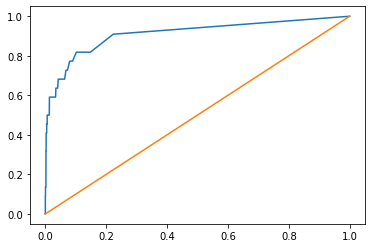

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 7000
building tree 2 of 7000
building tree 3 of 7000
building tree 4 of 7000
building tree 5 of 7000
building tree 6 of 7000
building tree 7 of 7000
building tree 8 of 7000
building tree 9 of 7000
building tree 10 of 7000
building tree 11 of 7000
building tree 12 of 7000
building tree 13 of 7000
building tree 14 of 7000
building tree 15 of 7000
building tree 16 of 7000
building tree 17 of 7000
building tree 18 of 7000
building tree 19 of 7000
building tree 20 of 7000
building tree 21 of 7000
building tree 22 of 7000
building tree 23 of 7000
building tree 24 of 7000
building tree 25 of 7000
building tree 26 of 7000
building tree 27 of 7000
building tree 28 of 7000
building tree 29 of 7000
building tree 30 of 7000
building tree 31 of 7000
building tree 32 of 7000
building tree 33 of 7000
building tree 34 of 7000
building tree 35 of 7000
building tree 36 of 7000


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.3s


building tree 37 of 7000
building tree 38 of 7000
building tree 39 of 7000
building tree 40 of 7000
building tree 41 of 7000
building tree 42 of 7000
building tree 43 of 7000
building tree 44 of 7000
building tree 45 of 7000
building tree 46 of 7000
building tree 47 of 7000
building tree 48 of 7000
building tree 49 of 7000
building tree 50 of 7000
building tree 51 of 7000
building tree 52 of 7000
building tree 53 of 7000
building tree 54 of 7000
building tree 55 of 7000
building tree 56 of 7000
building tree 57 of 7000
building tree 58 of 7000
building tree 59 of 7000
building tree 60 of 7000
building tree 61 of 7000
building tree 62 of 7000
building tree 63 of 7000
building tree 64 of 7000
building tree 65 of 7000
building tree 66 of 7000
building tree 67 of 7000
building tree 68 of 7000
building tree 69 of 7000
building tree 70 of 7000
building tree 71 of 7000
building tree 72 of 7000
building tree 73 of 7000
building tree 74 of 7000
building tree 75 of 7000
building tree 76 of 7000


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   14.6s


building tree 159 of 7000
building tree 160 of 7000
building tree 161 of 7000
building tree 162 of 7000
building tree 163 of 7000
building tree 164 of 7000
building tree 165 of 7000
building tree 166 of 7000
building tree 167 of 7000
building tree 168 of 7000
building tree 169 of 7000
building tree 170 of 7000
building tree 171 of 7000
building tree 172 of 7000
building tree 173 of 7000
building tree 174 of 7000
building tree 175 of 7000
building tree 176 of 7000
building tree 177 of 7000
building tree 178 of 7000
building tree 179 of 7000
building tree 180 of 7000
building tree 181 of 7000
building tree 182 of 7000
building tree 183 of 7000
building tree 184 of 7000
building tree 185 of 7000
building tree 186 of 7000
building tree 187 of 7000
building tree 188 of 7000
building tree 189 of 7000
building tree 190 of 7000
building tree 191 of 7000
building tree 192 of 7000
building tree 193 of 7000
building tree 194 of 7000
building tree 195 of 7000
building tree 196 of 7000
building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   31.7s


building tree 364 of 7000
building tree 365 of 7000
building tree 366 of 7000
building tree 367 of 7000
building tree 368 of 7000
building tree 369 of 7000building tree 370 of 7000

building tree 371 of 7000
building tree 372 of 7000
building tree 373 of 7000
building tree 374 of 7000
building tree 375 of 7000
building tree 376 of 7000
building tree 377 of 7000
building tree 378 of 7000
building tree 379 of 7000
building tree 380 of 7000
building tree 381 of 7000
building tree 382 of 7000
building tree 383 of 7000
building tree 384 of 7000
building tree 385 of 7000
building tree 386 of 7000
building tree 387 of 7000
building tree 388 of 7000
building tree 389 of 7000
building tree 390 of 7000
building tree 391 of 7000
building tree 392 of 7000
building tree 393 of 7000
building tree 394 of 7000
building tree 395 of 7000
building tree 396 of 7000
building tree 397 of 7000
building tree 398 of 7000
building tree 399 of 7000
building tree 400 of 7000
building tree 401 of 7000
building tre

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   55.0s


building tree 644 of 7000
building tree 645 of 7000
building tree 646 of 7000
building tree 647 of 7000
building tree 648 of 7000building tree 649 of 7000

building tree 650 of 7000
building tree 651 of 7000
building tree 652 of 7000
building tree 653 of 7000
building tree 654 of 7000
building tree 655 of 7000
building tree 656 of 7000
building tree 657 of 7000
building tree 658 of 7000
building tree 659 of 7000
building tree 660 of 7000
building tree 661 of 7000
building tree 662 of 7000
building tree 663 of 7000
building tree 664 of 7000
building tree 665 of 7000
building tree 666 of 7000
building tree 667 of 7000
building tree 668 of 7000
building tree 669 of 7000
building tree 670 of 7000
building tree 671 of 7000
building tree 672 of 7000
building tree 673 of 7000
building tree 674 of 7000
building tree 675 of 7000
building tree 676 of 7000
building tree 677 of 7000
building tree 678 of 7000
building tree 679 of 7000
building tree 680 of 7000
building tree 681 of 7000
building tre

building tree 960 of 7000
building tree 961 of 7000
building tree 962 of 7000
building tree 963 of 7000
building tree 964 of 7000
building tree 965 of 7000
building tree 966 of 7000
building tree 967 of 7000
building tree 968 of 7000
building tree 969 of 7000
building tree 970 of 7000
building tree 971 of 7000
building tree 972 of 7000
building tree 973 of 7000
building tree 974 of 7000
building tree 975 of 7000
building tree 976 of 7000
building tree 977 of 7000
building tree 978 of 7000
building tree 979 of 7000
building tree 980 of 7000
building tree 981 of 7000
building tree 982 of 7000
building tree 983 of 7000
building tree 984 of 7000
building tree 985 of 7000
building tree 986 of 7000
building tree 987 of 7000
building tree 988 of 7000
building tree 989 of 7000
building tree 990 of 7000
building tree 991 of 7000
building tree 992 of 7000
building tree 993 of 7000
building tree 994 of 7000
building tree 995 of 7000
building tree 996 of 7000
building tree 997 of 7000
building tre

[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.5min


building tree 1012 of 7000
building tree 1013 of 7000
building tree 1014 of 7000
building tree 1015 of 7000
building tree 1016 of 7000
building tree 1017 of 7000
building tree 1018 of 7000
building tree 1019 of 7000
building tree 1020 of 7000
building tree 1021 of 7000
building tree 1022 of 7000
building tree 1023 of 7000
building tree 1024 of 7000
building tree 1025 of 7000
building tree 1026 of 7000
building tree 1027 of 7000
building tree 1028 of 7000
building tree 1029 of 7000
building tree 1030 of 7000
building tree 1031 of 7000
building tree 1032 of 7000
building tree 1033 of 7000
building tree 1034 of 7000
building tree 1035 of 7000
building tree 1036 of 7000
building tree 1037 of 7000
building tree 1038 of 7000
building tree 1039 of 7000
building tree 1040 of 7000
building tree 1041 of 7000
building tree 1042 of 7000
building tree 1043 of 7000
building tree 1044 of 7000
building tree 1045 of 7000
building tree 1046 of 7000
building tree 1047 of 7000
building tree 1048 of 7000
b

building tree 1318 of 7000
building tree 1319 of 7000
building tree 1320 of 7000
building tree 1321 of 7000
building tree 1322 of 7000
building tree 1323 of 7000
building tree 1324 of 7000
building tree 1325 of 7000
building tree 1326 of 7000
building tree 1327 of 7000
building tree 1328 of 7000
building tree 1329 of 7000
building tree 1330 of 7000
building tree 1331 of 7000
building tree 1332 of 7000
building tree 1333 of 7000
building tree 1334 of 7000
building tree 1335 of 7000
building tree 1336 of 7000
building tree 1337 of 7000
building tree 1338 of 7000
building tree 1339 of 7000
building tree 1340 of 7000
building tree 1341 of 7000
building tree 1342 of 7000
building tree 1343 of 7000
building tree 1344 of 7000
building tree 1345 of 7000
building tree 1346 of 7000
building tree 1347 of 7000
building tree 1348 of 7000
building tree 1349 of 7000
building tree 1350 of 7000
building tree 1351 of 7000
building tree 1352 of 7000
building tree 1353 of 7000
building tree 1354 of 7000
b

[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.2min


building tree 1455 of 7000
building tree 1456 of 7000
building tree 1457 of 7000
building tree 1458 of 7000
building tree 1459 of 7000
building tree 1460 of 7000
building tree 1461 of 7000
building tree 1462 of 7000
building tree 1463 of 7000
building tree 1464 of 7000
building tree 1465 of 7000
building tree 1466 of 7000
building tree 1467 of 7000
building tree 1468 of 7000
building tree 1469 of 7000
building tree 1470 of 7000
building tree 1471 of 7000
building tree 1472 of 7000
building tree 1473 of 7000
building tree 1474 of 7000
building tree 1475 of 7000
building tree 1476 of 7000
building tree 1477 of 7000
building tree 1478 of 7000
building tree 1479 of 7000
building tree 1480 of 7000
building tree 1481 of 7000
building tree 1482 of 7000
building tree 1483 of 7000
building tree 1484 of 7000
building tree 1485 of 7000
building tree 1486 of 7000
building tree 1487 of 7000
building tree 1488 of 7000
building tree 1489 of 7000
building tree 1490 of 7000
building tree 1491 of 7000
b

building tree 1759 of 7000
building tree 1760 of 7000
building tree 1761 of 7000
building tree 1762 of 7000
building tree 1763 of 7000
building tree 1764 of 7000
building tree 1765 of 7000
building tree 1766 of 7000
building tree 1767 of 7000building tree 1768 of 7000

building tree 1769 of 7000
building tree 1770 of 7000
building tree 1771 of 7000
building tree 1772 of 7000
building tree 1773 of 7000
building tree 1774 of 7000
building tree 1775 of 7000
building tree 1776 of 7000
building tree 1777 of 7000
building tree 1778 of 7000
building tree 1779 of 7000
building tree 1780 of 7000
building tree 1781 of 7000
building tree 1782 of 7000
building tree 1783 of 7000
building tree 1784 of 7000
building tree 1785 of 7000
building tree 1786 of 7000
building tree 1787 of 7000
building tree 1788 of 7000
building tree 1789 of 7000
building tree 1790 of 7000
building tree 1791 of 7000
building tree 1792 of 7000
building tree 1793 of 7000
building tree 1794 of 7000
building tree 1795 of 7000
b

[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  3.0min


building tree 1982 of 7000
building tree 1983 of 7000
building tree 1984 of 7000
building tree 1985 of 7000
building tree 1986 of 7000
building tree 1987 of 7000
building tree 1988 of 7000
building tree 1989 of 7000
building tree 1990 of 7000
building tree 1991 of 7000
building tree 1992 of 7000
building tree 1993 of 7000
building tree 1994 of 7000
building tree 1995 of 7000
building tree 1996 of 7000
building tree 1997 of 7000
building tree 1998 of 7000
building tree 1999 of 7000
building tree 2000 of 7000
building tree 2001 of 7000
building tree 2002 of 7000
building tree 2003 of 7000
building tree 2004 of 7000
building tree 2005 of 7000
building tree 2006 of 7000
building tree 2007 of 7000
building tree 2008 of 7000
building tree 2009 of 7000
building tree 2010 of 7000
building tree 2011 of 7000
building tree 2012 of 7000
building tree 2013 of 7000
building tree 2014 of 7000
building tree 2015 of 7000
building tree 2016 of 7000
building tree 2017 of 7000
building tree 2018 of 7000
b

building tree 2288 of 7000
building tree 2289 of 7000
building tree 2290 of 7000
building tree 2291 of 7000
building tree 2292 of 7000
building tree 2293 of 7000
building tree 2294 of 7000
building tree 2295 of 7000
building tree 2296 of 7000
building tree 2297 of 7000
building tree 2298 of 7000
building tree 2299 of 7000
building tree 2300 of 7000
building tree 2301 of 7000
building tree 2302 of 7000
building tree 2303 of 7000
building tree 2304 of 7000
building tree 2305 of 7000
building tree 2306 of 7000
building tree 2307 of 7000
building tree 2308 of 7000
building tree 2309 of 7000
building tree 2310 of 7000
building tree 2311 of 7000
building tree 2312 of 7000
building tree 2313 of 7000
building tree 2314 of 7000
building tree 2315 of 7000
building tree 2316 of 7000
building tree 2317 of 7000
building tree 2318 of 7000
building tree 2319 of 7000
building tree 2320 of 7000
building tree 2321 of 7000
building tree 2322 of 7000
building tree 2323 of 7000
building tree 2324 of 7000
b

[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.9min


building tree 2588 of 7000
building tree 2589 of 7000
building tree 2590 of 7000
building tree 2591 of 7000
building tree 2592 of 7000
building tree 2593 of 7000
building tree 2594 of 7000building tree 2595 of 7000

building tree 2596 of 7000
building tree 2597 of 7000
building tree 2598 of 7000
building tree 2599 of 7000
building tree 2600 of 7000
building tree 2601 of 7000building tree 2602 of 7000

building tree 2603 of 7000
building tree 2604 of 7000
building tree 2605 of 7000building tree 2606 of 7000

building tree 2607 of 7000
building tree 2608 of 7000
building tree 2609 of 7000
building tree 2610 of 7000
building tree 2611 of 7000
building tree 2612 of 7000
building tree 2613 of 7000
building tree 2614 of 7000
building tree 2615 of 7000
building tree 2616 of 7000
building tree 2617 of 7000
building tree 2618 of 7000
building tree 2619 of 7000
building tree 2620 of 7000
building tree 2621 of 7000
building tree 2622 of 7000
building tree 2623 of 7000
building tree 2624 of 7000
b

building tree 2894 of 7000
building tree 2895 of 7000
building tree 2896 of 7000
building tree 2897 of 7000
building tree 2898 of 7000
building tree 2899 of 7000
building tree 2900 of 7000
building tree 2901 of 7000
building tree 2902 of 7000
building tree 2903 of 7000
building tree 2904 of 7000
building tree 2905 of 7000
building tree 2906 of 7000
building tree 2907 of 7000
building tree 2908 of 7000
building tree 2909 of 7000
building tree 2910 of 7000
building tree 2911 of 7000
building tree 2912 of 7000
building tree 2913 of 7000
building tree 2914 of 7000
building tree 2915 of 7000
building tree 2916 of 7000
building tree 2917 of 7000
building tree 2918 of 7000
building tree 2919 of 7000
building tree 2920 of 7000
building tree 2921 of 7000
building tree 2922 of 7000
building tree 2923 of 7000
building tree 2924 of 7000
building tree 2925 of 7000
building tree 2926 of 7000
building tree 2927 of 7000building tree 2928 of 7000

building tree 2929 of 7000
building tree 2930 of 7000
b

building tree 3200 of 7000
building tree 3201 of 7000
building tree 3202 of 7000
building tree 3203 of 7000
building tree 3204 of 7000
building tree 3205 of 7000
building tree 3206 of 7000
building tree 3207 of 7000
building tree 3208 of 7000
building tree 3209 of 7000
building tree 3210 of 7000
building tree 3211 of 7000
building tree 3212 of 7000
building tree 3213 of 7000
building tree 3214 of 7000
building tree 3215 of 7000
building tree 3216 of 7000
building tree 3217 of 7000
building tree 3218 of 7000
building tree 3219 of 7000
building tree 3220 of 7000
building tree 3221 of 7000
building tree 3222 of 7000
building tree 3223 of 7000
building tree 3224 of 7000
building tree 3225 of 7000
building tree 3226 of 7000
building tree 3227 of 7000
building tree 3228 of 7000
building tree 3229 of 7000
building tree 3230 of 7000
building tree 3231 of 7000
building tree 3232 of 7000
building tree 3233 of 7000
building tree 3234 of 7000
building tree 3235 of 7000building tree 3236 of 7000

b

[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  4.9min


building tree 3277 of 7000
building tree 3278 of 7000
building tree 3279 of 7000
building tree 3280 of 7000
building tree 3281 of 7000
building tree 3282 of 7000
building tree 3283 of 7000
building tree 3284 of 7000
building tree 3285 of 7000
building tree 3286 of 7000
building tree 3287 of 7000
building tree 3288 of 7000
building tree 3289 of 7000
building tree 3290 of 7000
building tree 3291 of 7000
building tree 3292 of 7000
building tree 3293 of 7000
building tree 3294 of 7000
building tree 3295 of 7000
building tree 3296 of 7000
building tree 3297 of 7000
building tree 3298 of 7000
building tree 3299 of 7000
building tree 3300 of 7000
building tree 3301 of 7000
building tree 3302 of 7000
building tree 3303 of 7000
building tree 3304 of 7000
building tree 3305 of 7000
building tree 3306 of 7000
building tree 3307 of 7000
building tree 3308 of 7000
building tree 3309 of 7000
building tree 3310 of 7000building tree 3311 of 7000

building tree 3312 of 7000
building tree 3313 of 7000
b

building tree 3582 of 7000
building tree 3583 of 7000
building tree 3584 of 7000
building tree 3585 of 7000
building tree 3586 of 7000
building tree 3587 of 7000
building tree 3588 of 7000
building tree 3589 of 7000
building tree 3590 of 7000
building tree 3591 of 7000
building tree 3592 of 7000
building tree 3593 of 7000
building tree 3594 of 7000
building tree 3595 of 7000
building tree 3596 of 7000
building tree 3597 of 7000
building tree 3598 of 7000
building tree 3599 of 7000
building tree 3600 of 7000
building tree 3601 of 7000
building tree 3602 of 7000
building tree 3603 of 7000
building tree 3604 of 7000
building tree 3605 of 7000
building tree 3606 of 7000
building tree 3607 of 7000
building tree 3608 of 7000
building tree 3609 of 7000
building tree 3610 of 7000
building tree 3611 of 7000
building tree 3612 of 7000
building tree 3613 of 7000
building tree 3614 of 7000
building tree 3615 of 7000
building tree 3616 of 7000
building tree 3617 of 7000
building tree 3618 of 7000
b

building tree 3887 of 7000
building tree 3888 of 7000
building tree 3889 of 7000
building tree 3890 of 7000
building tree 3891 of 7000
building tree 3892 of 7000building tree 3893 of 7000

building tree 3894 of 7000
building tree 3895 of 7000
building tree 3896 of 7000
building tree 3897 of 7000
building tree 3898 of 7000
building tree 3899 of 7000
building tree 3900 of 7000
building tree 3901 of 7000
building tree 3902 of 7000
building tree 3903 of 7000
building tree 3904 of 7000
building tree 3905 of 7000
building tree 3906 of 7000
building tree 3907 of 7000
building tree 3908 of 7000
building tree 3909 of 7000
building tree 3910 of 7000
building tree 3911 of 7000
building tree 3912 of 7000
building tree 3913 of 7000
building tree 3914 of 7000
building tree 3915 of 7000
building tree 3916 of 7000
building tree 3917 of 7000
building tree 3918 of 7000
building tree 3919 of 7000
building tree 3920 of 7000
building tree 3921 of 7000
building tree 3922 of 7000
building tree 3923 of 7000
b

[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.1min



building tree 4048 of 7000
building tree 4049 of 7000
building tree 4050 of 7000
building tree 4051 of 7000
building tree 4052 of 7000
building tree 4053 of 7000
building tree 4054 of 7000
building tree 4055 of 7000
building tree 4056 of 7000
building tree 4057 of 7000
building tree 4058 of 7000
building tree 4059 of 7000
building tree 4060 of 7000
building tree 4061 of 7000
building tree 4062 of 7000
building tree 4063 of 7000
building tree 4064 of 7000
building tree 4065 of 7000
building tree 4066 of 7000
building tree 4067 of 7000
building tree 4068 of 7000
building tree 4069 of 7000
building tree 4070 of 7000
building tree 4071 of 7000
building tree 4072 of 7000
building tree 4073 of 7000
building tree 4074 of 7000
building tree 4075 of 7000
building tree 4076 of 7000
building tree 4077 of 7000
building tree 4078 of 7000
building tree 4079 of 7000
building tree 4080 of 7000
building tree 4081 of 7000
building tree 4082 of 7000
building tree 4083 of 7000
building tree 4084 of 7000


building tree 4355 of 7000building tree 4356 of 7000

building tree 4357 of 7000
building tree 4358 of 7000
building tree 4359 of 7000
building tree 4360 of 7000
building tree 4361 of 7000
building tree 4362 of 7000
building tree 4363 of 7000
building tree 4364 of 7000
building tree 4365 of 7000
building tree 4366 of 7000
building tree 4367 of 7000
building tree 4368 of 7000
building tree 4369 of 7000
building tree 4370 of 7000
building tree 4371 of 7000
building tree 4372 of 7000
building tree 4373 of 7000
building tree 4374 of 7000
building tree 4375 of 7000
building tree 4376 of 7000
building tree 4377 of 7000
building tree 4378 of 7000
building tree 4379 of 7000
building tree 4380 of 7000
building tree 4381 of 7000
building tree 4382 of 7000
building tree 4383 of 7000
building tree 4384 of 7000
building tree 4385 of 7000
building tree 4386 of 7000
building tree 4387 of 7000
building tree 4388 of 7000
building tree 4389 of 7000
building tree 4390 of 7000
building tree 4391 of 7000
b

building tree 4659 of 7000
building tree 4660 of 7000
building tree 4661 of 7000
building tree 4662 of 7000
building tree 4663 of 7000building tree 4664 of 7000

building tree 4665 of 7000
building tree 4666 of 7000
building tree 4667 of 7000
building tree 4668 of 7000
building tree 4669 of 7000
building tree 4670 of 7000
building tree 4671 of 7000
building tree 4672 of 7000
building tree 4673 of 7000
building tree 4674 of 7000
building tree 4675 of 7000
building tree 4676 of 7000
building tree 4677 of 7000
building tree 4678 of 7000
building tree 4679 of 7000
building tree 4680 of 7000
building tree 4681 of 7000
building tree 4682 of 7000
building tree 4683 of 7000
building tree 4684 of 7000
building tree 4685 of 7000
building tree 4686 of 7000
building tree 4687 of 7000
building tree 4688 of 7000
building tree 4689 of 7000
building tree 4690 of 7000
building tree 4691 of 7000
building tree 4692 of 7000
building tree 4693 of 7000
building tree 4694 of 7000
building tree 4695 of 7000
b

[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:  7.4min



building tree 4899 of 7000
building tree 4900 of 7000
building tree 4901 of 7000
building tree 4902 of 7000
building tree 4903 of 7000
building tree 4904 of 7000
building tree 4905 of 7000
building tree 4906 of 7000
building tree 4907 of 7000
building tree 4908 of 7000
building tree 4909 of 7000
building tree 4910 of 7000
building tree 4911 of 7000
building tree 4912 of 7000
building tree 4913 of 7000
building tree 4914 of 7000
building tree 4915 of 7000
building tree 4916 of 7000
building tree 4917 of 7000
building tree 4918 of 7000
building tree 4919 of 7000
building tree 4920 of 7000
building tree 4921 of 7000
building tree 4922 of 7000
building tree 4923 of 7000
building tree 4924 of 7000
building tree 4925 of 7000
building tree 4926 of 7000
building tree 4927 of 7000
building tree 4928 of 7000
building tree 4929 of 7000
building tree 4930 of 7000
building tree 4931 of 7000
building tree 4932 of 7000
building tree 4933 of 7000
building tree 4934 of 7000
building tree 4935 of 7000


building tree 5506 of 7000
building tree 5507 of 7000
building tree 5508 of 7000
building tree 5509 of 7000
building tree 5510 of 7000
building tree 5511 of 7000
building tree 5512 of 7000
building tree 5513 of 7000
building tree 5514 of 7000
building tree 5515 of 7000
building tree 5516 of 7000
building tree 5517 of 7000
building tree 5518 of 7000
building tree 5519 of 7000
building tree 5520 of 7000
building tree 5521 of 7000
building tree 5522 of 7000
building tree 5523 of 7000
building tree 5524 of 7000
building tree 5525 of 7000
building tree 5526 of 7000
building tree 5527 of 7000
building tree 5528 of 7000
building tree 5529 of 7000
building tree 5530 of 7000
building tree 5531 of 7000
building tree 5532 of 7000
building tree 5533 of 7000
building tree 5534 of 7000
building tree 5535 of 7000
building tree 5536 of 7000
building tree 5537 of 7000
building tree 5538 of 7000
building tree 5539 of 7000
building tree 5540 of 7000
building tree 5541 of 7000
building tree 5542 of 7000
b

building tree 5810 of 7000
building tree 5811 of 7000
building tree 5812 of 7000
building tree 5813 of 7000
building tree 5814 of 7000
building tree 5815 of 7000
building tree 5816 of 7000
building tree 5817 of 7000
building tree 5818 of 7000
building tree 5819 of 7000
building tree 5820 of 7000
building tree 5821 of 7000
building tree 5822 of 7000
building tree 5823 of 7000
building tree 5824 of 7000
building tree 5825 of 7000
building tree 5826 of 7000
building tree 5827 of 7000
building tree 5828 of 7000
building tree 5829 of 7000


[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  8.8min


building tree 5830 of 7000
building tree 5831 of 7000
building tree 5832 of 7000
building tree 5833 of 7000
building tree 5834 of 7000
building tree 5835 of 7000
building tree 5836 of 7000
building tree 5837 of 7000
building tree 5838 of 7000
building tree 5839 of 7000
building tree 5840 of 7000
building tree 5841 of 7000
building tree 5842 of 7000
building tree 5843 of 7000
building tree 5844 of 7000
building tree 5845 of 7000
building tree 5846 of 7000
building tree 5847 of 7000
building tree 5848 of 7000
building tree 5849 of 7000
building tree 5850 of 7000
building tree 5851 of 7000
building tree 5852 of 7000
building tree 5853 of 7000
building tree 5854 of 7000
building tree 5855 of 7000
building tree 5856 of 7000
building tree 5857 of 7000
building tree 5858 of 7000
building tree 5859 of 7000
building tree 5860 of 7000
building tree 5861 of 7000
building tree 5862 of 7000
building tree 5863 of 7000
building tree 5864 of 7000
building tree 5865 of 7000
building tree 5866 of 7000
b

building tree 6438 of 7000
building tree 6439 of 7000
building tree 6440 of 7000
building tree 6441 of 7000
building tree 6442 of 7000building tree 6443 of 7000

building tree 6444 of 7000
building tree 6445 of 7000
building tree 6446 of 7000
building tree 6447 of 7000
building tree 6448 of 7000
building tree 6449 of 7000
building tree 6450 of 7000
building tree 6451 of 7000
building tree 6452 of 7000
building tree 6453 of 7000
building tree 6454 of 7000
building tree 6455 of 7000
building tree 6456 of 7000
building tree 6457 of 7000
building tree 6458 of 7000
building tree 6459 of 7000
building tree 6460 of 7000
building tree 6461 of 7000
building tree 6462 of 7000
building tree 6463 of 7000
building tree 6464 of 7000
building tree 6465 of 7000
building tree 6466 of 7000
building tree 6467 of 7000
building tree 6468 of 7000
building tree 6469 of 7000
building tree 6470 of 7000
building tree 6471 of 7000
building tree 6472 of 7000
building tree 6473 of 7000
building tree 6474 of 7000
b

building tree 6745 of 7000
building tree 6746 of 7000
building tree 6747 of 7000
building tree 6748 of 7000
building tree 6749 of 7000
building tree 6750 of 7000
building tree 6751 of 7000
building tree 6752 of 7000
building tree 6753 of 7000
building tree 6754 of 7000
building tree 6755 of 7000
building tree 6756 of 7000
building tree 6757 of 7000
building tree 6758 of 7000
building tree 6759 of 7000
building tree 6760 of 7000
building tree 6761 of 7000
building tree 6762 of 7000
building tree 6763 of 7000
building tree 6764 of 7000
building tree 6765 of 7000
building tree 6766 of 7000
building tree 6767 of 7000
building tree 6768 of 7000
building tree 6769 of 7000
building tree 6770 of 7000
building tree 6771 of 7000
building tree 6772 of 7000
building tree 6773 of 7000
building tree 6774 of 7000
building tree 6775 of 7000
building tree 6776 of 7000
building tree 6777 of 7000
building tree 6778 of 7000
building tree 6779 of 7000
building tree 6780 of 7000
building tree 6781 of 7000
b

[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 10.3min


building tree 6842 of 7000
building tree 6843 of 7000
building tree 6844 of 7000
building tree 6845 of 7000
building tree 6846 of 7000
building tree 6847 of 7000
building tree 6848 of 7000
building tree 6849 of 7000
building tree 6850 of 7000
building tree 6851 of 7000
building tree 6852 of 7000
building tree 6853 of 7000
building tree 6854 of 7000
building tree 6855 of 7000
building tree 6856 of 7000
building tree 6857 of 7000
building tree 6858 of 7000
building tree 6859 of 7000
building tree 6860 of 7000
building tree 6861 of 7000
building tree 6862 of 7000
building tree 6863 of 7000
building tree 6864 of 7000
building tree 6865 of 7000
building tree 6866 of 7000
building tree 6867 of 7000
building tree 6868 of 7000
building tree 6869 of 7000
building tree 6870 of 7000
building tree 6871 of 7000
building tree 6872 of 7000
building tree 6873 of 7000
building tree 6874 of 7000
building tree 6875 of 7000
building tree 6876 of 7000
building tree 6877 of 7000
building tree 6878 of 7000
b

[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed: 10.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed:   15.5s


0.8791416397735234 21


[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed:   15.8s finished


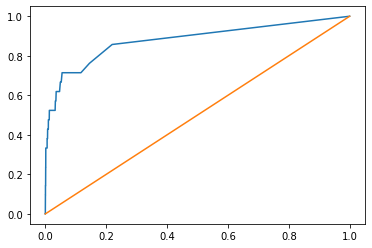

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 7000
building tree 2 of 7000
building tree 3 of 7000
building tree 4 of 7000
building tree 5 of 7000
building tree 6 of 7000
building tree 7 of 7000
building tree 8 of 7000
building tree 9 of 7000
building tree 10 of 7000
building tree 11 of 7000
building tree 12 of 7000
building tree 13 of 7000
building tree 14 of 7000
building tree 15 of 7000
building tree 16 of 7000
building tree 17 of 7000
building tree 18 of 7000
building tree 19 of 7000
building tree 20 of 7000
building tree 21 of 7000
building tree 22 of 7000
building tree 23 of 7000
building tree 24 of 7000
building tree 25 of 7000
building tree 26 of 7000
building tree 27 of 7000
building tree 28 of 7000
building tree 29 of 7000
building tree 30 of 7000
building tree 31 of 7000
building tree 32 of 7000
building tree 33 of 7000
building tree 34 of 7000
building tree 35 of 7000
building tree 36 of 7000
building tree 37 of 7000
building tree 38 of 7000
building tree 39 of 7000

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s



building tree 40 of 7000
building tree 41 of 7000
building tree 42 of 7000
building tree 43 of 7000
building tree 44 of 7000
building tree 45 of 7000
building tree 46 of 7000
building tree 47 of 7000
building tree 48 of 7000
building tree 49 of 7000
building tree 50 of 7000
building tree 51 of 7000
building tree 52 of 7000
building tree 53 of 7000
building tree 54 of 7000
building tree 55 of 7000
building tree 56 of 7000
building tree 57 of 7000
building tree 58 of 7000
building tree 59 of 7000
building tree 60 of 7000
building tree 61 of 7000
building tree 62 of 7000
building tree 63 of 7000
building tree 64 of 7000
building tree 65 of 7000
building tree 66 of 7000
building tree 67 of 7000
building tree 68 of 7000
building tree 69 of 7000
building tree 70 of 7000
building tree 71 of 7000
building tree 72 of 7000
building tree 73 of 7000
building tree 74 of 7000
building tree 75 of 7000
building tree 76 of 7000
building tree 77 of 7000
building tree 78 of 7000
building tree 79 of 7000

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   11.5s


building tree 159 of 7000
building tree 160 of 7000
building tree 161 of 7000
building tree 162 of 7000
building tree 163 of 7000
building tree 164 of 7000
building tree 165 of 7000
building tree 166 of 7000
building tree 167 of 7000
building tree 168 of 7000
building tree 169 of 7000
building tree 170 of 7000
building tree 171 of 7000
building tree 172 of 7000
building tree 173 of 7000
building tree 174 of 7000
building tree 175 of 7000
building tree 176 of 7000
building tree 177 of 7000
building tree 178 of 7000
building tree 179 of 7000
building tree 180 of 7000
building tree 181 of 7000
building tree 182 of 7000
building tree 183 of 7000
building tree 184 of 7000
building tree 185 of 7000
building tree 186 of 7000
building tree 187 of 7000
building tree 188 of 7000
building tree 189 of 7000
building tree 190 of 7000
building tree 191 of 7000
building tree 192 of 7000
building tree 193 of 7000
building tree 194 of 7000
building tree 195 of 7000
building tree 196 of 7000
building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   27.8s


building tree 363 of 7000
building tree 364 of 7000
building tree 365 of 7000
building tree 366 of 7000
building tree 367 of 7000
building tree 368 of 7000
building tree 369 of 7000
building tree 370 of 7000
building tree 371 of 7000
building tree 372 of 7000
building tree 373 of 7000
building tree 374 of 7000
building tree 375 of 7000
building tree 376 of 7000
building tree 377 of 7000
building tree 378 of 7000
building tree 379 of 7000
building tree 380 of 7000
building tree 381 of 7000
building tree 382 of 7000
building tree 383 of 7000
building tree 384 of 7000
building tree 385 of 7000
building tree 386 of 7000
building tree 387 of 7000
building tree 388 of 7000
building tree 389 of 7000
building tree 390 of 7000
building tree 391 of 7000
building tree 392 of 7000
building tree 393 of 7000
building tree 394 of 7000
building tree 395 of 7000
building tree 396 of 7000
building tree 397 of 7000
building tree 398 of 7000
building tree 399 of 7000
building tree 400 of 7000
building tre

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   53.1s


building tree 646 of 7000
building tree 647 of 7000
building tree 648 of 7000
building tree 649 of 7000
building tree 650 of 7000
building tree 651 of 7000
building tree 652 of 7000
building tree 653 of 7000
building tree 654 of 7000
building tree 655 of 7000
building tree 656 of 7000
building tree 657 of 7000
building tree 658 of 7000
building tree 659 of 7000
building tree 660 of 7000
building tree 661 of 7000
building tree 662 of 7000
building tree 663 of 7000
building tree 664 of 7000
building tree 665 of 7000
building tree 666 of 7000
building tree 667 of 7000
building tree 668 of 7000
building tree 669 of 7000
building tree 670 of 7000
building tree 671 of 7000
building tree 672 of 7000
building tree 673 of 7000
building tree 674 of 7000
building tree 675 of 7000
building tree 676 of 7000
building tree 677 of 7000
building tree 678 of 7000
building tree 679 of 7000
building tree 680 of 7000
building tree 681 of 7000
building tree 682 of 7000
building tree 683 of 7000
building tre

building tree 962 of 7000
building tree 963 of 7000
building tree 964 of 7000
building tree 965 of 7000
building tree 966 of 7000
building tree 967 of 7000
building tree 968 of 7000
building tree 969 of 7000
building tree 970 of 7000
building tree 971 of 7000
building tree 972 of 7000
building tree 973 of 7000
building tree 974 of 7000
building tree 975 of 7000
building tree 976 of 7000
building tree 977 of 7000
building tree 978 of 7000
building tree 979 of 7000
building tree 980 of 7000
building tree 981 of 7000
building tree 982 of 7000
building tree 983 of 7000
building tree 984 of 7000
building tree 985 of 7000
building tree 986 of 7000
building tree 987 of 7000
building tree 988 of 7000
building tree 989 of 7000
building tree 990 of 7000
building tree 991 of 7000
building tree 992 of 7000
building tree 993 of 7000
building tree 994 of 7000
building tree 995 of 7000
building tree 996 of 7000
building tree 997 of 7000
building tree 998 of 7000
building tree 999 of 7000
building tre

[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.5min


building tree 1009 of 7000
building tree 1010 of 7000
building tree 1011 of 7000
building tree 1012 of 7000
building tree 1013 of 7000
building tree 1014 of 7000
building tree 1015 of 7000
building tree 1016 of 7000
building tree 1017 of 7000
building tree 1018 of 7000
building tree 1019 of 7000
building tree 1020 of 7000
building tree 1021 of 7000
building tree 1022 of 7000
building tree 1023 of 7000
building tree 1024 of 7000
building tree 1025 of 7000
building tree 1026 of 7000
building tree 1027 of 7000
building tree 1028 of 7000
building tree 1029 of 7000
building tree 1030 of 7000
building tree 1031 of 7000
building tree 1032 of 7000
building tree 1033 of 7000
building tree 1034 of 7000
building tree 1035 of 7000
building tree 1036 of 7000
building tree 1037 of 7000
building tree 1038 of 7000
building tree 1039 of 7000
building tree 1040 of 7000
building tree 1041 of 7000
building tree 1042 of 7000
building tree 1043 of 7000
building tree 1044 of 7000
building tree 1045 of 7000
b

building tree 1314 of 7000
building tree 1315 of 7000
building tree 1316 of 7000
building tree 1317 of 7000
building tree 1318 of 7000
building tree 1319 of 7000
building tree 1320 of 7000
building tree 1321 of 7000
building tree 1322 of 7000
building tree 1323 of 7000
building tree 1324 of 7000
building tree 1325 of 7000
building tree 1326 of 7000
building tree 1327 of 7000
building tree 1328 of 7000
building tree 1329 of 7000
building tree 1330 of 7000
building tree 1331 of 7000
building tree 1332 of 7000building tree 1333 of 7000

building tree 1334 of 7000
building tree 1335 of 7000
building tree 1336 of 7000
building tree 1337 of 7000
building tree 1338 of 7000
building tree 1339 of 7000
building tree 1340 of 7000
building tree 1341 of 7000
building tree 1342 of 7000
building tree 1343 of 7000
building tree 1344 of 7000
building tree 1345 of 7000
building tree 1346 of 7000
building tree 1347 of 7000
building tree 1348 of 7000
building tree 1349 of 7000
building tree 1350 of 7000
b

[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.1min


building tree 1458 of 7000
building tree 1459 of 7000
building tree 1460 of 7000
building tree 1461 of 7000
building tree 1462 of 7000
building tree 1463 of 7000
building tree 1464 of 7000
building tree 1465 of 7000
building tree 1466 of 7000
building tree 1467 of 7000
building tree 1468 of 7000
building tree 1469 of 7000
building tree 1470 of 7000
building tree 1471 of 7000
building tree 1472 of 7000
building tree 1473 of 7000
building tree 1474 of 7000
building tree 1475 of 7000
building tree 1476 of 7000
building tree 1477 of 7000
building tree 1478 of 7000
building tree 1479 of 7000
building tree 1480 of 7000building tree 1481 of 7000

building tree 1482 of 7000
building tree 1483 of 7000
building tree 1484 of 7000
building tree 1485 of 7000
building tree 1486 of 7000
building tree 1487 of 7000
building tree 1488 of 7000
building tree 1489 of 7000
building tree 1490 of 7000
building tree 1491 of 7000
building tree 1492 of 7000
building tree 1493 of 7000
building tree 1494 of 7000
b

building tree 1763 of 7000
building tree 1764 of 7000
building tree 1765 of 7000
building tree 1766 of 7000
building tree 1767 of 7000
building tree 1768 of 7000
building tree 1769 of 7000
building tree 1770 of 7000
building tree 1771 of 7000
building tree 1772 of 7000
building tree 1773 of 7000
building tree 1774 of 7000
building tree 1775 of 7000
building tree 1776 of 7000
building tree 1777 of 7000
building tree 1778 of 7000
building tree 1779 of 7000
building tree 1780 of 7000
building tree 1781 of 7000
building tree 1782 of 7000
building tree 1783 of 7000
building tree 1784 of 7000
building tree 1785 of 7000
building tree 1786 of 7000
building tree 1787 of 7000
building tree 1788 of 7000
building tree 1789 of 7000
building tree 1790 of 7000
building tree 1791 of 7000
building tree 1792 of 7000
building tree 1793 of 7000
building tree 1794 of 7000
building tree 1795 of 7000
building tree 1796 of 7000
building tree 1797 of 7000
building tree 1798 of 7000
building tree 1799 of 7000
b

[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  2.8min


building tree 1982 of 7000
building tree 1983 of 7000
building tree 1984 of 7000
building tree 1985 of 7000
building tree 1986 of 7000
building tree 1987 of 7000
building tree 1988 of 7000
building tree 1989 of 7000
building tree 1990 of 7000
building tree 1991 of 7000
building tree 1992 of 7000
building tree 1993 of 7000
building tree 1994 of 7000
building tree 1995 of 7000
building tree 1996 of 7000
building tree 1997 of 7000
building tree 1998 of 7000
building tree 1999 of 7000
building tree 2000 of 7000
building tree 2001 of 7000
building tree 2002 of 7000
building tree 2003 of 7000
building tree 2004 of 7000
building tree 2005 of 7000
building tree 2006 of 7000
building tree 2007 of 7000
building tree 2008 of 7000
building tree 2009 of 7000
building tree 2010 of 7000
building tree 2011 of 7000
building tree 2012 of 7000
building tree 2013 of 7000
building tree 2014 of 7000
building tree 2015 of 7000
building tree 2016 of 7000
building tree 2017 of 7000
building tree 2018 of 7000
b

building tree 2289 of 7000
building tree 2290 of 7000
building tree 2291 of 7000
building tree 2292 of 7000
building tree 2293 of 7000
building tree 2294 of 7000
building tree 2295 of 7000
building tree 2296 of 7000
building tree 2297 of 7000
building tree 2298 of 7000
building tree 2299 of 7000
building tree 2300 of 7000
building tree 2301 of 7000
building tree 2302 of 7000
building tree 2303 of 7000
building tree 2304 of 7000
building tree 2305 of 7000
building tree 2306 of 7000
building tree 2307 of 7000
building tree 2308 of 7000
building tree 2309 of 7000
building tree 2310 of 7000
building tree 2311 of 7000building tree 2312 of 7000

building tree 2313 of 7000
building tree 2314 of 7000
building tree 2315 of 7000
building tree 2316 of 7000
building tree 2317 of 7000
building tree 2318 of 7000
building tree 2319 of 7000
building tree 2320 of 7000
building tree 2321 of 7000
building tree 2322 of 7000
building tree 2323 of 7000
building tree 2324 of 7000
building tree 2325 of 7000
b

[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.7min


building tree 2588 of 7000
building tree 2589 of 7000
building tree 2590 of 7000
building tree 2591 of 7000
building tree 2592 of 7000
building tree 2593 of 7000
building tree 2594 of 7000
building tree 2595 of 7000
building tree 2596 of 7000
building tree 2597 of 7000
building tree 2598 of 7000
building tree 2599 of 7000
building tree 2600 of 7000
building tree 2601 of 7000
building tree 2602 of 7000
building tree 2603 of 7000
building tree 2604 of 7000
building tree 2605 of 7000
building tree 2606 of 7000
building tree 2607 of 7000
building tree 2608 of 7000
building tree 2609 of 7000
building tree 2610 of 7000
building tree 2611 of 7000
building tree 2612 of 7000
building tree 2613 of 7000
building tree 2614 of 7000
building tree 2615 of 7000
building tree 2616 of 7000
building tree 2617 of 7000
building tree 2618 of 7000
building tree 2619 of 7000
building tree 2620 of 7000
building tree 2621 of 7000
building tree 2622 of 7000
building tree 2623 of 7000
building tree 2624 of 7000
b

building tree 2894 of 7000
building tree 2895 of 7000
building tree 2896 of 7000
building tree 2897 of 7000
building tree 2898 of 7000
building tree 2899 of 7000
building tree 2900 of 7000
building tree 2901 of 7000
building tree 2902 of 7000
building tree 2903 of 7000
building tree 2904 of 7000
building tree 2905 of 7000
building tree 2906 of 7000
building tree 2907 of 7000
building tree 2908 of 7000
building tree 2909 of 7000
building tree 2910 of 7000
building tree 2911 of 7000
building tree 2912 of 7000
building tree 2913 of 7000
building tree 2914 of 7000building tree 2915 of 7000

building tree 2916 of 7000
building tree 2917 of 7000
building tree 2918 of 7000
building tree 2919 of 7000
building tree 2920 of 7000
building tree 2921 of 7000
building tree 2922 of 7000
building tree 2923 of 7000
building tree 2924 of 7000
building tree 2925 of 7000
building tree 2926 of 7000
building tree 2927 of 7000
building tree 2928 of 7000
building tree 2929 of 7000
building tree 2930 of 7000
b

building tree 3199 of 7000
building tree 3200 of 7000
building tree 3201 of 7000
building tree 3202 of 7000
building tree 3203 of 7000
building tree 3204 of 7000
building tree 3205 of 7000
building tree 3206 of 7000
building tree 3207 of 7000
building tree 3208 of 7000
building tree 3209 of 7000
building tree 3210 of 7000
building tree 3211 of 7000
building tree 3212 of 7000
building tree 3213 of 7000
building tree 3214 of 7000
building tree 3215 of 7000
building tree 3216 of 7000
building tree 3217 of 7000
building tree 3218 of 7000
building tree 3219 of 7000
building tree 3220 of 7000
building tree 3221 of 7000
building tree 3222 of 7000
building tree 3223 of 7000
building tree 3224 of 7000
building tree 3225 of 7000
building tree 3226 of 7000
building tree 3227 of 7000
building tree 3228 of 7000
building tree 3229 of 7000
building tree 3230 of 7000
building tree 3231 of 7000
building tree 3232 of 7000
building tree 3233 of 7000
building tree 3234 of 7000
building tree 3235 of 7000
b

[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  4.8min


building tree 3280 of 7000
building tree 3281 of 7000
building tree 3282 of 7000
building tree 3283 of 7000
building tree 3284 of 7000
building tree 3285 of 7000
building tree 3286 of 7000
building tree 3287 of 7000
building tree 3288 of 7000
building tree 3289 of 7000
building tree 3290 of 7000
building tree 3291 of 7000
building tree 3292 of 7000
building tree 3293 of 7000
building tree 3294 of 7000
building tree 3295 of 7000
building tree 3296 of 7000
building tree 3297 of 7000
building tree 3298 of 7000
building tree 3299 of 7000
building tree 3300 of 7000
building tree 3301 of 7000building tree 3302 of 7000

building tree 3303 of 7000
building tree 3304 of 7000
building tree 3305 of 7000
building tree 3306 of 7000
building tree 3307 of 7000
building tree 3308 of 7000
building tree 3309 of 7000
building tree 3310 of 7000
building tree 3311 of 7000
building tree 3312 of 7000
building tree 3313 of 7000
building tree 3314 of 7000
building tree 3315 of 7000
building tree 3316 of 7000
b

building tree 3586 of 7000
building tree 3587 of 7000
building tree 3588 of 7000
building tree 3589 of 7000
building tree 3590 of 7000
building tree 3591 of 7000
building tree 3592 of 7000
building tree 3593 of 7000
building tree 3594 of 7000
building tree 3595 of 7000
building tree 3596 of 7000
building tree 3597 of 7000
building tree 3598 of 7000
building tree 3599 of 7000
building tree 3600 of 7000
building tree 3601 of 7000
building tree 3602 of 7000
building tree 3603 of 7000
building tree 3604 of 7000
building tree 3605 of 7000building tree 3606 of 7000

building tree 3607 of 7000
building tree 3608 of 7000
building tree 3609 of 7000
building tree 3610 of 7000
building tree 3611 of 7000
building tree 3612 of 7000
building tree 3613 of 7000
building tree 3614 of 7000
building tree 3615 of 7000
building tree 3616 of 7000
building tree 3617 of 7000
building tree 3618 of 7000
building tree 3619 of 7000
building tree 3620 of 7000
building tree 3621 of 7000
building tree 3622 of 7000
b

[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.0min


building tree 4050 of 7000
building tree 4051 of 7000
building tree 4052 of 7000
building tree 4053 of 7000
building tree 4054 of 7000
building tree 4055 of 7000
building tree 4056 of 7000
building tree 4057 of 7000
building tree 4058 of 7000
building tree 4059 of 7000
building tree 4060 of 7000building tree 4061 of 7000

building tree 4062 of 7000
building tree 4063 of 7000
building tree 4064 of 7000
building tree 4065 of 7000
building tree 4066 of 7000
building tree 4067 of 7000
building tree 4068 of 7000
building tree 4069 of 7000
building tree 4070 of 7000
building tree 4071 of 7000
building tree 4072 of 7000
building tree 4073 of 7000
building tree 4074 of 7000
building tree 4075 of 7000
building tree 4076 of 7000
building tree 4077 of 7000
building tree 4078 of 7000
building tree 4079 of 7000
building tree 4080 of 7000
building tree 4081 of 7000
building tree 4082 of 7000
building tree 4083 of 7000
building tree 4084 of 7000
building tree 4085 of 7000
building tree 4086 of 7000
b

building tree 4354 of 7000
building tree 4355 of 7000
building tree 4356 of 7000
building tree 4357 of 7000
building tree 4358 of 7000
building tree 4359 of 7000building tree 4360 of 7000

building tree 4361 of 7000
building tree 4362 of 7000
building tree 4363 of 7000
building tree 4364 of 7000
building tree 4365 of 7000
building tree 4366 of 7000
building tree 4367 of 7000
building tree 4368 of 7000
building tree 4369 of 7000
building tree 4370 of 7000
building tree 4371 of 7000
building tree 4372 of 7000
building tree 4373 of 7000
building tree 4374 of 7000
building tree 4375 of 7000
building tree 4376 of 7000
building tree 4377 of 7000building tree 4378 of 7000

building tree 4379 of 7000
building tree 4380 of 7000
building tree 4381 of 7000
building tree 4382 of 7000
building tree 4383 of 7000
building tree 4384 of 7000
building tree 4385 of 7000
building tree 4386 of 7000
building tree 4387 of 7000
building tree 4388 of 7000
building tree 4389 of 7000
building tree 4390 of 7000
b

building tree 4658 of 7000
building tree 4659 of 7000
building tree 4660 of 7000
building tree 4661 of 7000
building tree 4662 of 7000
building tree 4663 of 7000
building tree 4664 of 7000
building tree 4665 of 7000
building tree 4666 of 7000
building tree 4667 of 7000
building tree 4668 of 7000
building tree 4669 of 7000
building tree 4670 of 7000
building tree 4671 of 7000
building tree 4672 of 7000
building tree 4673 of 7000
building tree 4674 of 7000
building tree 4675 of 7000
building tree 4676 of 7000
building tree 4677 of 7000
building tree 4678 of 7000
building tree 4679 of 7000
building tree 4680 of 7000
building tree 4681 of 7000
building tree 4682 of 7000
building tree 4683 of 7000
building tree 4684 of 7000
building tree 4685 of 7000
building tree 4686 of 7000
building tree 4687 of 7000
building tree 4688 of 7000
building tree 4689 of 7000
building tree 4690 of 7000
building tree 4691 of 7000
building tree 4692 of 7000
building tree 4693 of 7000
building tree 4694 of 7000
b

[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:  7.2min


building tree 4897 of 7000
building tree 4898 of 7000
building tree 4899 of 7000
building tree 4900 of 7000
building tree 4901 of 7000
building tree 4902 of 7000
building tree 4903 of 7000
building tree 4904 of 7000
building tree 4905 of 7000
building tree 4906 of 7000
building tree 4907 of 7000
building tree 4908 of 7000
building tree 4909 of 7000
building tree 4910 of 7000
building tree 4911 of 7000
building tree 4912 of 7000
building tree 4913 of 7000
building tree 4914 of 7000
building tree 4915 of 7000
building tree 4916 of 7000
building tree 4917 of 7000
building tree 4918 of 7000
building tree 4919 of 7000
building tree 4920 of 7000
building tree 4921 of 7000
building tree 4922 of 7000
building tree 4923 of 7000
building tree 4924 of 7000
building tree 4925 of 7000
building tree 4926 of 7000
building tree 4927 of 7000
building tree 4928 of 7000
building tree 4929 of 7000
building tree 4930 of 7000
building tree 4931 of 7000
building tree 4932 of 7000
building tree 4933 of 7000
b

building tree 5201 of 7000
building tree 5202 of 7000
building tree 5203 of 7000
building tree 5204 of 7000
building tree 5205 of 7000
building tree 5206 of 7000
building tree 5207 of 7000
building tree 5208 of 7000
building tree 5209 of 7000
building tree 5210 of 7000
building tree 5211 of 7000
building tree 5212 of 7000
building tree 5213 of 7000
building tree 5214 of 7000
building tree 5215 of 7000
building tree 5216 of 7000
building tree 5217 of 7000
building tree 5218 of 7000
building tree 5219 of 7000
building tree 5220 of 7000
building tree 5221 of 7000
building tree 5222 of 7000
building tree 5223 of 7000
building tree 5224 of 7000
building tree 5225 of 7000
building tree 5226 of 7000
building tree 5227 of 7000
building tree 5228 of 7000
building tree 5229 of 7000
building tree 5230 of 7000
building tree 5231 of 7000
building tree 5232 of 7000
building tree 5233 of 7000
building tree 5234 of 7000
building tree 5235 of 7000
building tree 5236 of 7000
building tree 5237 of 7000
b

building tree 5506 of 7000
building tree 5507 of 7000
building tree 5508 of 7000
building tree 5509 of 7000
building tree 5510 of 7000
building tree 5511 of 7000
building tree 5512 of 7000
building tree 5513 of 7000
building tree 5514 of 7000
building tree 5515 of 7000
building tree 5516 of 7000
building tree 5517 of 7000
building tree 5518 of 7000
building tree 5519 of 7000
building tree 5520 of 7000
building tree 5521 of 7000
building tree 5522 of 7000
building tree 5523 of 7000
building tree 5524 of 7000
building tree 5525 of 7000
building tree 5526 of 7000
building tree 5527 of 7000
building tree 5528 of 7000
building tree 5529 of 7000
building tree 5530 of 7000
building tree 5531 of 7000
building tree 5532 of 7000
building tree 5533 of 7000
building tree 5534 of 7000
building tree 5535 of 7000
building tree 5536 of 7000
building tree 5537 of 7000
building tree 5538 of 7000
building tree 5539 of 7000
building tree 5540 of 7000
building tree 5541 of 7000
building tree 5542 of 7000
b

building tree 5810 of 7000
building tree 5811 of 7000
building tree 5812 of 7000
building tree 5813 of 7000
building tree 5814 of 7000
building tree 5815 of 7000
building tree 5816 of 7000
building tree 5817 of 7000
building tree 5818 of 7000
building tree 5819 of 7000
building tree 5820 of 7000
building tree 5821 of 7000
building tree 5822 of 7000
building tree 5823 of 7000
building tree 5824 of 7000
building tree 5825 of 7000
building tree 5826 of 7000
building tree 5827 of 7000
building tree 5828 of 7000
building tree 5829 of 7000


[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  8.6min


building tree 5830 of 7000
building tree 5831 of 7000
building tree 5832 of 7000
building tree 5833 of 7000
building tree 5834 of 7000
building tree 5835 of 7000
building tree 5836 of 7000
building tree 5837 of 7000
building tree 5838 of 7000
building tree 5839 of 7000
building tree 5840 of 7000
building tree 5841 of 7000
building tree 5842 of 7000
building tree 5843 of 7000
building tree 5844 of 7000
building tree 5845 of 7000
building tree 5846 of 7000
building tree 5847 of 7000
building tree 5848 of 7000
building tree 5849 of 7000
building tree 5850 of 7000
building tree 5851 of 7000building tree 5852 of 7000

building tree 5853 of 7000
building tree 5854 of 7000
building tree 5855 of 7000
building tree 5856 of 7000
building tree 5857 of 7000
building tree 5858 of 7000
building tree 5859 of 7000
building tree 5860 of 7000
building tree 5861 of 7000
building tree 5862 of 7000
building tree 5863 of 7000
building tree 5864 of 7000
building tree 5865 of 7000
building tree 5866 of 7000
b

building tree 6134 of 7000
building tree 6135 of 7000
building tree 6136 of 7000
building tree 6137 of 7000
building tree 6138 of 7000
building tree 6139 of 7000
building tree 6140 of 7000
building tree 6141 of 7000
building tree 6142 of 7000
building tree 6143 of 7000
building tree 6144 of 7000
building tree 6145 of 7000
building tree 6146 of 7000
building tree 6147 of 7000
building tree 6148 of 7000
building tree 6149 of 7000
building tree 6150 of 7000
building tree 6151 of 7000
building tree 6152 of 7000
building tree 6153 of 7000
building tree 6154 of 7000
building tree 6155 of 7000
building tree 6156 of 7000
building tree 6157 of 7000
building tree 6158 of 7000
building tree 6159 of 7000
building tree 6160 of 7000
building tree 6161 of 7000
building tree 6162 of 7000
building tree 6163 of 7000
building tree 6164 of 7000
building tree 6165 of 7000
building tree 6166 of 7000
building tree 6167 of 7000
building tree 6168 of 7000
building tree 6169 of 7000
building tree 6170 of 7000
b

building tree 6438 of 7000
building tree 6439 of 7000
building tree 6440 of 7000
building tree 6441 of 7000
building tree 6442 of 7000
building tree 6443 of 7000
building tree 6444 of 7000
building tree 6445 of 7000
building tree 6446 of 7000
building tree 6447 of 7000
building tree 6448 of 7000
building tree 6449 of 7000
building tree 6450 of 7000
building tree 6451 of 7000
building tree 6452 of 7000
building tree 6453 of 7000
building tree 6454 of 7000
building tree 6455 of 7000
building tree 6456 of 7000
building tree 6457 of 7000
building tree 6458 of 7000
building tree 6459 of 7000
building tree 6460 of 7000
building tree 6461 of 7000
building tree 6462 of 7000
building tree 6463 of 7000
building tree 6464 of 7000
building tree 6465 of 7000
building tree 6466 of 7000
building tree 6467 of 7000
building tree 6468 of 7000
building tree 6469 of 7000
building tree 6470 of 7000
building tree 6471 of 7000
building tree 6472 of 7000
building tree 6473 of 7000
building tree 6474 of 7000
b

building tree 6742 of 7000
building tree 6743 of 7000
building tree 6744 of 7000
building tree 6745 of 7000
building tree 6746 of 7000
building tree 6747 of 7000
building tree 6748 of 7000
building tree 6749 of 7000
building tree 6750 of 7000
building tree 6751 of 7000
building tree 6752 of 7000
building tree 6753 of 7000
building tree 6754 of 7000
building tree 6755 of 7000
building tree 6756 of 7000
building tree 6757 of 7000
building tree 6758 of 7000
building tree 6759 of 7000
building tree 6760 of 7000
building tree 6761 of 7000
building tree 6762 of 7000
building tree 6763 of 7000
building tree 6764 of 7000
building tree 6765 of 7000
building tree 6766 of 7000
building tree 6767 of 7000
building tree 6768 of 7000
building tree 6769 of 7000
building tree 6770 of 7000
building tree 6771 of 7000
building tree 6772 of 7000
building tree 6773 of 7000
building tree 6774 of 7000
building tree 6775 of 7000
building tree 6776 of 7000
building tree 6777 of 7000
building tree 6778 of 7000
b

[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 10.1min


building tree 6843 of 7000
building tree 6844 of 7000
building tree 6845 of 7000
building tree 6846 of 7000
building tree 6847 of 7000
building tree 6848 of 7000
building tree 6849 of 7000
building tree 6850 of 7000
building tree 6851 of 7000
building tree 6852 of 7000
building tree 6853 of 7000
building tree 6854 of 7000
building tree 6855 of 7000
building tree 6856 of 7000
building tree 6857 of 7000
building tree 6858 of 7000
building tree 6859 of 7000
building tree 6860 of 7000
building tree 6861 of 7000
building tree 6862 of 7000
building tree 6863 of 7000
building tree 6864 of 7000
building tree 6865 of 7000
building tree 6866 of 7000
building tree 6867 of 7000
building tree 6868 of 7000
building tree 6869 of 7000
building tree 6870 of 7000
building tree 6871 of 7000
building tree 6872 of 7000
building tree 6873 of 7000
building tree 6874 of 7000
building tree 6875 of 7000
building tree 6876 of 7000
building tree 6877 of 7000
building tree 6878 of 7000
building tree 6879 of 7000
b

[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed: 10.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 7000 out of 7000 | 

0.9083451050650986 21


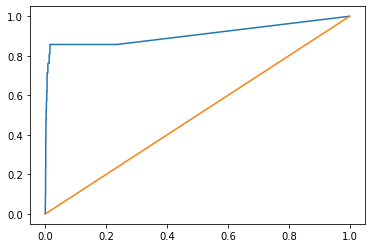

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 7000
building tree 2 of 7000
building tree 3 of 7000
building tree 4 of 7000
building tree 5 of 7000
building tree 6 of 7000
building tree 7 of 7000building tree 8 of 7000

building tree 9 of 7000
building tree 10 of 7000
building tree 11 of 7000
building tree 12 of 7000
building tree 13 of 7000
building tree 14 of 7000
building tree 15 of 7000
building tree 16 of 7000
building tree 17 of 7000
building tree 18 of 7000
building tree 19 of 7000
building tree 20 of 7000
building tree 21 of 7000
building tree 22 of 7000
building tree 23 of 7000
building tree 24 of 7000
building tree 25 of 7000
building tree 26 of 7000
building tree 27 of 7000
building tree 28 of 7000
building tree 29 of 7000
building tree 30 of 7000
building tree 31 of 7000
building tree 32 of 7000
building tree 33 of 7000
building tree 34 of 7000building tree 35 of 7000

building tree 36 of 7000
building tree 37 of 7000


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s


building tree 38 of 7000
building tree 39 of 7000
building tree 40 of 7000
building tree 41 of 7000
building tree 42 of 7000
building tree 43 of 7000
building tree 44 of 7000
building tree 45 of 7000
building tree 46 of 7000
building tree 47 of 7000
building tree 48 of 7000
building tree 49 of 7000
building tree 50 of 7000
building tree 51 of 7000
building tree 52 of 7000
building tree 53 of 7000
building tree 54 of 7000
building tree 55 of 7000
building tree 56 of 7000
building tree 57 of 7000
building tree 58 of 7000
building tree 59 of 7000
building tree 60 of 7000
building tree 61 of 7000
building tree 62 of 7000
building tree 63 of 7000
building tree 64 of 7000
building tree 65 of 7000
building tree 66 of 7000
building tree 67 of 7000
building tree 68 of 7000building tree 69 of 7000

building tree 70 of 7000
building tree 71 of 7000
building tree 72 of 7000
building tree 73 of 7000
building tree 74 of 7000
building tree 75 of 7000
building tree 76 of 7000
building tree 77 of 7000


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   11.4s


building tree 158 of 7000
building tree 159 of 7000
building tree 160 of 7000
building tree 161 of 7000
building tree 162 of 7000
building tree 163 of 7000
building tree 164 of 7000
building tree 165 of 7000
building tree 166 of 7000
building tree 167 of 7000
building tree 168 of 7000
building tree 169 of 7000
building tree 170 of 7000
building tree 171 of 7000
building tree 172 of 7000
building tree 173 of 7000
building tree 174 of 7000
building tree 175 of 7000
building tree 176 of 7000
building tree 177 of 7000
building tree 178 of 7000
building tree 179 of 7000
building tree 180 of 7000
building tree 181 of 7000
building tree 182 of 7000
building tree 183 of 7000
building tree 184 of 7000
building tree 185 of 7000
building tree 186 of 7000
building tree 187 of 7000
building tree 188 of 7000
building tree 189 of 7000
building tree 190 of 7000
building tree 191 of 7000
building tree 192 of 7000
building tree 193 of 7000
building tree 194 of 7000
building tree 195 of 7000
building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   28.9s


building tree 363 of 7000
building tree 364 of 7000
building tree 365 of 7000
building tree 366 of 7000
building tree 367 of 7000
building tree 368 of 7000
building tree 369 of 7000
building tree 370 of 7000
building tree 371 of 7000
building tree 372 of 7000
building tree 373 of 7000
building tree 374 of 7000
building tree 375 of 7000
building tree 376 of 7000
building tree 377 of 7000
building tree 378 of 7000
building tree 379 of 7000
building tree 380 of 7000
building tree 381 of 7000
building tree 382 of 7000
building tree 383 of 7000
building tree 384 of 7000
building tree 385 of 7000
building tree 386 of 7000
building tree 387 of 7000
building tree 388 of 7000
building tree 389 of 7000
building tree 390 of 7000
building tree 391 of 7000
building tree 392 of 7000
building tree 393 of 7000
building tree 394 of 7000
building tree 395 of 7000
building tree 396 of 7000
building tree 397 of 7000
building tree 398 of 7000
building tree 399 of 7000
building tree 400 of 7000
building tre

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   55.1s



building tree 646 of 7000
building tree 647 of 7000
building tree 648 of 7000
building tree 649 of 7000
building tree 650 of 7000
building tree 651 of 7000
building tree 652 of 7000
building tree 653 of 7000
building tree 654 of 7000
building tree 655 of 7000
building tree 656 of 7000
building tree 657 of 7000
building tree 658 of 7000
building tree 659 of 7000
building tree 660 of 7000
building tree 661 of 7000
building tree 662 of 7000
building tree 663 of 7000
building tree 664 of 7000
building tree 665 of 7000
building tree 666 of 7000
building tree 667 of 7000
building tree 668 of 7000
building tree 669 of 7000
building tree 670 of 7000
building tree 671 of 7000
building tree 672 of 7000
building tree 673 of 7000
building tree 674 of 7000
building tree 675 of 7000
building tree 676 of 7000
building tree 677 of 7000
building tree 678 of 7000
building tree 679 of 7000
building tree 680 of 7000
building tree 681 of 7000
building tree 682 of 7000
building tree 683 of 7000
building tr

building tree 962 of 7000
building tree 963 of 7000
building tree 964 of 7000
building tree 965 of 7000
building tree 966 of 7000
building tree 967 of 7000
building tree 968 of 7000
building tree 969 of 7000
building tree 970 of 7000
building tree 971 of 7000
building tree 972 of 7000
building tree 973 of 7000
building tree 974 of 7000
building tree 975 of 7000
building tree 976 of 7000
building tree 977 of 7000
building tree 978 of 7000
building tree 979 of 7000
building tree 980 of 7000
building tree 981 of 7000
building tree 982 of 7000
building tree 983 of 7000
building tree 984 of 7000
building tree 985 of 7000
building tree 986 of 7000
building tree 987 of 7000
building tree 988 of 7000
building tree 989 of 7000
building tree 990 of 7000
building tree 991 of 7000
building tree 992 of 7000
building tree 993 of 7000
building tree 994 of 7000
building tree 995 of 7000
building tree 996 of 7000
building tree 997 of 7000
building tree 998 of 7000
building tree 999 of 7000
building tre

[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.5min


building tree 1011 of 7000
building tree 1012 of 7000
building tree 1013 of 7000
building tree 1014 of 7000
building tree 1015 of 7000
building tree 1016 of 7000
building tree 1017 of 7000
building tree 1018 of 7000
building tree 1019 of 7000
building tree 1020 of 7000
building tree 1021 of 7000
building tree 1022 of 7000
building tree 1023 of 7000
building tree 1024 of 7000
building tree 1025 of 7000
building tree 1026 of 7000
building tree 1027 of 7000
building tree 1028 of 7000
building tree 1029 of 7000
building tree 1030 of 7000
building tree 1031 of 7000
building tree 1032 of 7000
building tree 1033 of 7000
building tree 1034 of 7000
building tree 1035 of 7000
building tree 1036 of 7000
building tree 1037 of 7000
building tree 1038 of 7000
building tree 1039 of 7000
building tree 1040 of 7000
building tree 1041 of 7000
building tree 1042 of 7000
building tree 1043 of 7000
building tree 1044 of 7000
building tree 1045 of 7000
building tree 1046 of 7000building tree 1047 of 7000

b

building tree 1318 of 7000
building tree 1319 of 7000
building tree 1320 of 7000
building tree 1321 of 7000
building tree 1322 of 7000
building tree 1323 of 7000
building tree 1324 of 7000
building tree 1325 of 7000
building tree 1326 of 7000
building tree 1327 of 7000
building tree 1328 of 7000
building tree 1329 of 7000
building tree 1330 of 7000
building tree 1331 of 7000
building tree 1332 of 7000
building tree 1333 of 7000
building tree 1334 of 7000
building tree 1335 of 7000
building tree 1336 of 7000
building tree 1337 of 7000
building tree 1338 of 7000
building tree 1339 of 7000
building tree 1340 of 7000
building tree 1341 of 7000
building tree 1342 of 7000
building tree 1343 of 7000
building tree 1344 of 7000
building tree 1345 of 7000
building tree 1346 of 7000
building tree 1347 of 7000
building tree 1348 of 7000
building tree 1349 of 7000
building tree 1350 of 7000
building tree 1351 of 7000
building tree 1352 of 7000
building tree 1353 of 7000
building tree 1354 of 7000
b

[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.1min


building tree 1455 of 7000
building tree 1456 of 7000
building tree 1457 of 7000
building tree 1458 of 7000
building tree 1459 of 7000
building tree 1460 of 7000
building tree 1461 of 7000
building tree 1462 of 7000
building tree 1463 of 7000building tree 1464 of 7000

building tree 1465 of 7000
building tree 1466 of 7000
building tree 1467 of 7000
building tree 1468 of 7000
building tree 1469 of 7000
building tree 1470 of 7000
building tree 1471 of 7000
building tree 1472 of 7000
building tree 1473 of 7000
building tree 1474 of 7000
building tree 1475 of 7000
building tree 1476 of 7000
building tree 1477 of 7000
building tree 1478 of 7000
building tree 1479 of 7000
building tree 1480 of 7000
building tree 1481 of 7000
building tree 1482 of 7000
building tree 1483 of 7000
building tree 1484 of 7000
building tree 1485 of 7000
building tree 1486 of 7000
building tree 1487 of 7000
building tree 1488 of 7000
building tree 1489 of 7000
building tree 1490 of 7000
building tree 1491 of 7000
b

building tree 1762 of 7000
building tree 1763 of 7000
building tree 1764 of 7000
building tree 1765 of 7000
building tree 1766 of 7000
building tree 1767 of 7000
building tree 1768 of 7000
building tree 1769 of 7000
building tree 1770 of 7000
building tree 1771 of 7000
building tree 1772 of 7000
building tree 1773 of 7000
building tree 1774 of 7000
building tree 1775 of 7000
building tree 1776 of 7000
building tree 1777 of 7000
building tree 1778 of 7000
building tree 1779 of 7000
building tree 1780 of 7000
building tree 1781 of 7000
building tree 1782 of 7000
building tree 1783 of 7000
building tree 1784 of 7000
building tree 1785 of 7000
building tree 1786 of 7000
building tree 1787 of 7000
building tree 1788 of 7000
building tree 1789 of 7000
building tree 1790 of 7000
building tree 1791 of 7000
building tree 1792 of 7000
building tree 1793 of 7000
building tree 1794 of 7000
building tree 1795 of 7000
building tree 1796 of 7000
building tree 1797 of 7000
building tree 1798 of 7000
b

[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  2.9min


building tree 1982 of 7000
building tree 1983 of 7000
building tree 1984 of 7000
building tree 1985 of 7000
building tree 1986 of 7000
building tree 1987 of 7000
building tree 1988 of 7000
building tree 1989 of 7000
building tree 1990 of 7000
building tree 1991 of 7000
building tree 1992 of 7000
building tree 1993 of 7000
building tree 1994 of 7000
building tree 1995 of 7000
building tree 1996 of 7000
building tree 1997 of 7000
building tree 1998 of 7000
building tree 1999 of 7000
building tree 2000 of 7000
building tree 2001 of 7000
building tree 2002 of 7000
building tree 2003 of 7000
building tree 2004 of 7000
building tree 2005 of 7000
building tree 2006 of 7000
building tree 2007 of 7000
building tree 2008 of 7000
building tree 2009 of 7000
building tree 2010 of 7000
building tree 2011 of 7000
building tree 2012 of 7000
building tree 2013 of 7000
building tree 2014 of 7000
building tree 2015 of 7000
building tree 2016 of 7000
building tree 2017 of 7000
building tree 2018 of 7000
b

building tree 2286 of 7000
building tree 2287 of 7000
building tree 2288 of 7000
building tree 2289 of 7000
building tree 2290 of 7000
building tree 2291 of 7000
building tree 2292 of 7000
building tree 2293 of 7000
building tree 2294 of 7000
building tree 2295 of 7000
building tree 2296 of 7000
building tree 2297 of 7000
building tree 2298 of 7000
building tree 2299 of 7000
building tree 2300 of 7000
building tree 2301 of 7000
building tree 2302 of 7000
building tree 2303 of 7000
building tree 2304 of 7000
building tree 2305 of 7000
building tree 2306 of 7000
building tree 2307 of 7000
building tree 2308 of 7000
building tree 2309 of 7000
building tree 2310 of 7000
building tree 2311 of 7000
building tree 2312 of 7000
building tree 2313 of 7000
building tree 2314 of 7000
building tree 2315 of 7000
building tree 2316 of 7000
building tree 2317 of 7000
building tree 2318 of 7000building tree 2319 of 7000

building tree 2320 of 7000
building tree 2321 of 7000
building tree 2322 of 7000
b

[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.8min


building tree 2589 of 7000
building tree 2590 of 7000
building tree 2591 of 7000
building tree 2592 of 7000
building tree 2593 of 7000
building tree 2594 of 7000
building tree 2595 of 7000
building tree 2596 of 7000
building tree 2597 of 7000
building tree 2598 of 7000
building tree 2599 of 7000
building tree 2600 of 7000
building tree 2601 of 7000
building tree 2602 of 7000
building tree 2603 of 7000
building tree 2604 of 7000
building tree 2605 of 7000
building tree 2606 of 7000
building tree 2607 of 7000
building tree 2608 of 7000
building tree 2609 of 7000
building tree 2610 of 7000
building tree 2611 of 7000
building tree 2612 of 7000
building tree 2613 of 7000
building tree 2614 of 7000
building tree 2615 of 7000building tree 2616 of 7000

building tree 2617 of 7000
building tree 2618 of 7000
building tree 2619 of 7000
building tree 2620 of 7000
building tree 2621 of 7000
building tree 2622 of 7000
building tree 2623 of 7000
building tree 2624 of 7000
building tree 2625 of 7000
b

building tree 2893 of 7000
building tree 2894 of 7000
building tree 2895 of 7000
building tree 2896 of 7000
building tree 2897 of 7000
building tree 2898 of 7000
building tree 2899 of 7000
building tree 2900 of 7000
building tree 2901 of 7000
building tree 2902 of 7000
building tree 2903 of 7000
building tree 2904 of 7000
building tree 2905 of 7000
building tree 2906 of 7000
building tree 2907 of 7000
building tree 2908 of 7000
building tree 2909 of 7000
building tree 2910 of 7000
building tree 2911 of 7000
building tree 2912 of 7000
building tree 2913 of 7000
building tree 2914 of 7000building tree 2915 of 7000

building tree 2916 of 7000
building tree 2917 of 7000
building tree 2918 of 7000
building tree 2919 of 7000
building tree 2920 of 7000
building tree 2921 of 7000
building tree 2922 of 7000building tree 2923 of 7000

building tree 2924 of 7000
building tree 2925 of 7000
building tree 2926 of 7000
building tree 2927 of 7000building tree 2928 of 7000

building tree 2929 of 7000
b

building tree 3198 of 7000
building tree 3199 of 7000
building tree 3200 of 7000
building tree 3201 of 7000
building tree 3202 of 7000
building tree 3203 of 7000
building tree 3204 of 7000
building tree 3205 of 7000
building tree 3206 of 7000
building tree 3207 of 7000
building tree 3208 of 7000
building tree 3209 of 7000
building tree 3210 of 7000
building tree 3211 of 7000
building tree 3212 of 7000
building tree 3213 of 7000
building tree 3214 of 7000
building tree 3215 of 7000
building tree 3216 of 7000
building tree 3217 of 7000
building tree 3218 of 7000
building tree 3219 of 7000
building tree 3220 of 7000
building tree 3221 of 7000
building tree 3222 of 7000
building tree 3223 of 7000
building tree 3224 of 7000
building tree 3225 of 7000
building tree 3226 of 7000
building tree 3227 of 7000
building tree 3228 of 7000
building tree 3229 of 7000
building tree 3230 of 7000
building tree 3231 of 7000
building tree 3232 of 7000
building tree 3233 of 7000
building tree 3234 of 7000
b

[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  4.8min


building tree 3277 of 7000
building tree 3278 of 7000
building tree 3279 of 7000
building tree 3280 of 7000
building tree 3281 of 7000
building tree 3282 of 7000
building tree 3283 of 7000
building tree 3284 of 7000
building tree 3285 of 7000
building tree 3286 of 7000
building tree 3287 of 7000
building tree 3288 of 7000
building tree 3289 of 7000
building tree 3290 of 7000
building tree 3291 of 7000
building tree 3292 of 7000
building tree 3293 of 7000
building tree 3294 of 7000
building tree 3295 of 7000
building tree 3296 of 7000
building tree 3297 of 7000
building tree 3298 of 7000
building tree 3299 of 7000
building tree 3300 of 7000
building tree 3301 of 7000
building tree 3302 of 7000
building tree 3303 of 7000
building tree 3304 of 7000
building tree 3305 of 7000
building tree 3306 of 7000
building tree 3307 of 7000
building tree 3308 of 7000
building tree 3309 of 7000
building tree 3310 of 7000
building tree 3311 of 7000
building tree 3312 of 7000
building tree 3313 of 7000
b

building tree 3582 of 7000
building tree 3583 of 7000
building tree 3584 of 7000
building tree 3585 of 7000
building tree 3586 of 7000
building tree 3587 of 7000
building tree 3588 of 7000
building tree 3589 of 7000
building tree 3590 of 7000
building tree 3591 of 7000
building tree 3592 of 7000
building tree 3593 of 7000
building tree 3594 of 7000
building tree 3595 of 7000
building tree 3596 of 7000
building tree 3597 of 7000
building tree 3598 of 7000
building tree 3599 of 7000
building tree 3600 of 7000
building tree 3601 of 7000
building tree 3602 of 7000
building tree 3603 of 7000
building tree 3604 of 7000
building tree 3605 of 7000
building tree 3606 of 7000
building tree 3607 of 7000
building tree 3608 of 7000
building tree 3609 of 7000building tree 3610 of 7000

building tree 3611 of 7000
building tree 3612 of 7000
building tree 3613 of 7000
building tree 3614 of 7000
building tree 3615 of 7000
building tree 3616 of 7000
building tree 3617 of 7000
building tree 3618 of 7000
b

[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  5.9min


building tree 4050 of 7000
building tree 4051 of 7000
building tree 4052 of 7000
building tree 4053 of 7000
building tree 4054 of 7000
building tree 4055 of 7000
building tree 4056 of 7000
building tree 4057 of 7000
building tree 4058 of 7000building tree 4059 of 7000

building tree 4060 of 7000
building tree 4061 of 7000
building tree 4062 of 7000
building tree 4063 of 7000
building tree 4064 of 7000
building tree 4065 of 7000
building tree 4066 of 7000
building tree 4067 of 7000
building tree 4068 of 7000
building tree 4069 of 7000
building tree 4070 of 7000
building tree 4071 of 7000
building tree 4072 of 7000
building tree 4073 of 7000
building tree 4074 of 7000
building tree 4075 of 7000
building tree 4076 of 7000
building tree 4077 of 7000
building tree 4078 of 7000
building tree 4079 of 7000
building tree 4080 of 7000
building tree 4081 of 7000
building tree 4082 of 7000
building tree 4083 of 7000
building tree 4084 of 7000
building tree 4085 of 7000
building tree 4086 of 7000
b

building tree 4355 of 7000
building tree 4356 of 7000
building tree 4357 of 7000
building tree 4358 of 7000
building tree 4359 of 7000
building tree 4360 of 7000
building tree 4361 of 7000
building tree 4362 of 7000
building tree 4363 of 7000
building tree 4364 of 7000
building tree 4365 of 7000
building tree 4366 of 7000
building tree 4367 of 7000
building tree 4368 of 7000
building tree 4369 of 7000
building tree 4370 of 7000
building tree 4371 of 7000
building tree 4372 of 7000
building tree 4373 of 7000
building tree 4374 of 7000
building tree 4375 of 7000
building tree 4376 of 7000building tree 4377 of 7000

building tree 4378 of 7000
building tree 4379 of 7000
building tree 4380 of 7000
building tree 4381 of 7000
building tree 4382 of 7000
building tree 4383 of 7000
building tree 4384 of 7000
building tree 4385 of 7000
building tree 4386 of 7000
building tree 4387 of 7000
building tree 4388 of 7000
building tree 4389 of 7000
building tree 4390 of 7000
building tree 4391 of 7000
b

building tree 4662 of 7000
building tree 4663 of 7000building tree 4664 of 7000

building tree 4665 of 7000
building tree 4666 of 7000
building tree 4667 of 7000
building tree 4668 of 7000
building tree 4669 of 7000
building tree 4670 of 7000
building tree 4671 of 7000
building tree 4672 of 7000
building tree 4673 of 7000
building tree 4674 of 7000
building tree 4675 of 7000
building tree 4676 of 7000
building tree 4677 of 7000
building tree 4678 of 7000
building tree 4679 of 7000
building tree 4680 of 7000
building tree 4681 of 7000
building tree 4682 of 7000
building tree 4683 of 7000
building tree 4684 of 7000
building tree 4685 of 7000
building tree 4686 of 7000
building tree 4687 of 7000
building tree 4688 of 7000
building tree 4689 of 7000
building tree 4690 of 7000
building tree 4691 of 7000
building tree 4692 of 7000
building tree 4693 of 7000
building tree 4694 of 7000
building tree 4695 of 7000
building tree 4696 of 7000
building tree 4697 of 7000
building tree 4698 of 7000
b

[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:  7.1min


building tree 4897 of 7000
building tree 4898 of 7000
building tree 4899 of 7000
building tree 4900 of 7000
building tree 4901 of 7000
building tree 4902 of 7000
building tree 4903 of 7000
building tree 4904 of 7000
building tree 4905 of 7000
building tree 4906 of 7000
building tree 4907 of 7000
building tree 4908 of 7000
building tree 4909 of 7000
building tree 4910 of 7000
building tree 4911 of 7000
building tree 4912 of 7000
building tree 4913 of 7000
building tree 4914 of 7000
building tree 4915 of 7000
building tree 4916 of 7000
building tree 4917 of 7000
building tree 4918 of 7000
building tree 4919 of 7000
building tree 4920 of 7000
building tree 4921 of 7000
building tree 4922 of 7000
building tree 4923 of 7000
building tree 4924 of 7000
building tree 4925 of 7000
building tree 4926 of 7000
building tree 4927 of 7000
building tree 4928 of 7000building tree 4929 of 7000

building tree 4930 of 7000
building tree 4931 of 7000
building tree 4932 of 7000
building tree 4933 of 7000
b

building tree 5203 of 7000
building tree 5204 of 7000
building tree 5205 of 7000
building tree 5206 of 7000
building tree 5207 of 7000
building tree 5208 of 7000
building tree 5209 of 7000
building tree 5210 of 7000
building tree 5211 of 7000
building tree 5212 of 7000
building tree 5213 of 7000
building tree 5214 of 7000
building tree 5215 of 7000
building tree 5216 of 7000
building tree 5217 of 7000
building tree 5218 of 7000
building tree 5219 of 7000
building tree 5220 of 7000
building tree 5221 of 7000
building tree 5222 of 7000
building tree 5223 of 7000
building tree 5224 of 7000
building tree 5225 of 7000
building tree 5226 of 7000
building tree 5227 of 7000
building tree 5228 of 7000
building tree 5229 of 7000
building tree 5230 of 7000
building tree 5231 of 7000
building tree 5232 of 7000
building tree 5233 of 7000
building tree 5234 of 7000
building tree 5235 of 7000
building tree 5236 of 7000
building tree 5237 of 7000
building tree 5238 of 7000
building tree 5239 of 7000
b

building tree 5507 of 7000
building tree 5508 of 7000
building tree 5509 of 7000
building tree 5510 of 7000
building tree 5511 of 7000
building tree 5512 of 7000
building tree 5513 of 7000
building tree 5514 of 7000
building tree 5515 of 7000
building tree 5516 of 7000
building tree 5517 of 7000
building tree 5518 of 7000
building tree 5519 of 7000
building tree 5520 of 7000
building tree 5521 of 7000
building tree 5522 of 7000
building tree 5523 of 7000
building tree 5524 of 7000
building tree 5525 of 7000
building tree 5526 of 7000
building tree 5527 of 7000
building tree 5528 of 7000
building tree 5529 of 7000
building tree 5530 of 7000
building tree 5531 of 7000
building tree 5532 of 7000
building tree 5533 of 7000
building tree 5534 of 7000
building tree 5535 of 7000
building tree 5536 of 7000
building tree 5537 of 7000
building tree 5538 of 7000
building tree 5539 of 7000
building tree 5540 of 7000
building tree 5541 of 7000
building tree 5542 of 7000
building tree 5543 of 7000
b

building tree 5812 of 7000
building tree 5813 of 7000building tree 5814 of 7000

building tree 5815 of 7000
building tree 5816 of 7000
building tree 5817 of 7000
building tree 5818 of 7000
building tree 5819 of 7000
building tree 5820 of 7000
building tree 5821 of 7000
building tree 5822 of 7000
building tree 5823 of 7000
building tree 5824 of 7000
building tree 5825 of 7000
building tree 5826 of 7000
building tree 5827 of 7000
building tree 5828 of 7000
building tree 5829 of 7000


[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  8.5min


building tree 5830 of 7000
building tree 5831 of 7000
building tree 5832 of 7000
building tree 5833 of 7000
building tree 5834 of 7000
building tree 5835 of 7000
building tree 5836 of 7000
building tree 5837 of 7000
building tree 5838 of 7000
building tree 5839 of 7000
building tree 5840 of 7000
building tree 5841 of 7000
building tree 5842 of 7000
building tree 5843 of 7000
building tree 5844 of 7000
building tree 5845 of 7000
building tree 5846 of 7000
building tree 5847 of 7000
building tree 5848 of 7000
building tree 5849 of 7000
building tree 5850 of 7000
building tree 5851 of 7000
building tree 5852 of 7000
building tree 5853 of 7000
building tree 5854 of 7000
building tree 5855 of 7000
building tree 5856 of 7000
building tree 5857 of 7000
building tree 5858 of 7000
building tree 5859 of 7000
building tree 5860 of 7000
building tree 5861 of 7000
building tree 5862 of 7000
building tree 5863 of 7000
building tree 5864 of 7000
building tree 5865 of 7000
building tree 5866 of 7000
b

building tree 6135 of 7000
building tree 6136 of 7000
building tree 6137 of 7000
building tree 6138 of 7000
building tree 6139 of 7000
building tree 6140 of 7000
building tree 6141 of 7000
building tree 6142 of 7000
building tree 6143 of 7000
building tree 6144 of 7000
building tree 6145 of 7000
building tree 6146 of 7000
building tree 6147 of 7000
building tree 6148 of 7000
building tree 6149 of 7000
building tree 6150 of 7000
building tree 6151 of 7000
building tree 6152 of 7000
building tree 6153 of 7000
building tree 6154 of 7000
building tree 6155 of 7000
building tree 6156 of 7000building tree 6157 of 7000

building tree 6158 of 7000
building tree 6159 of 7000
building tree 6160 of 7000
building tree 6161 of 7000
building tree 6162 of 7000
building tree 6163 of 7000
building tree 6164 of 7000
building tree 6165 of 7000
building tree 6166 of 7000
building tree 6167 of 7000
building tree 6168 of 7000
building tree 6169 of 7000
building tree 6170 of 7000
building tree 6171 of 7000
b

building tree 6441 of 7000
building tree 6442 of 7000
building tree 6443 of 7000
building tree 6444 of 7000
building tree 6445 of 7000
building tree 6446 of 7000
building tree 6447 of 7000
building tree 6448 of 7000
building tree 6449 of 7000
building tree 6450 of 7000
building tree 6451 of 7000
building tree 6452 of 7000
building tree 6453 of 7000
building tree 6454 of 7000
building tree 6455 of 7000
building tree 6456 of 7000
building tree 6457 of 7000
building tree 6458 of 7000
building tree 6459 of 7000
building tree 6460 of 7000
building tree 6461 of 7000
building tree 6462 of 7000
building tree 6463 of 7000
building tree 6464 of 7000
building tree 6465 of 7000
building tree 6466 of 7000
building tree 6467 of 7000
building tree 6468 of 7000
building tree 6469 of 7000
building tree 6470 of 7000
building tree 6471 of 7000
building tree 6472 of 7000
building tree 6473 of 7000
building tree 6474 of 7000
building tree 6475 of 7000
building tree 6476 of 7000
building tree 6477 of 7000
b

[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 10.0min


building tree 6843 of 7000
building tree 6844 of 7000
building tree 6845 of 7000
building tree 6846 of 7000
building tree 6847 of 7000
building tree 6848 of 7000
building tree 6849 of 7000
building tree 6850 of 7000
building tree 6851 of 7000
building tree 6852 of 7000
building tree 6853 of 7000
building tree 6854 of 7000
building tree 6855 of 7000
building tree 6856 of 7000
building tree 6857 of 7000
building tree 6858 of 7000
building tree 6859 of 7000
building tree 6860 of 7000
building tree 6861 of 7000
building tree 6862 of 7000
building tree 6863 of 7000
building tree 6864 of 7000
building tree 6865 of 7000
building tree 6866 of 7000
building tree 6867 of 7000
building tree 6868 of 7000
building tree 6869 of 7000
building tree 6870 of 7000
building tree 6871 of 7000
building tree 6872 of 7000
building tree 6873 of 7000
building tree 6874 of 7000
building tree 6875 of 7000
building tree 6876 of 7000
building tree 6877 of 7000
building tree 6878 of 7000
building tree 6879 of 7000
b

[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed: 10.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed:   15.9s


0.9037799700634334 21


[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed:   16.3s finished


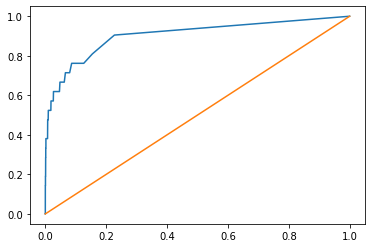

(99597, 27) 85 (24899, 27) 21
(199024, 27) 99512


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 7000
building tree 2 of 7000
building tree 3 of 7000
building tree 4 of 7000
building tree 5 of 7000
building tree 6 of 7000
building tree 7 of 7000building tree 8 of 7000

building tree 9 of 7000
building tree 10 of 7000building tree 11 of 7000

building tree 12 of 7000
building tree 13 of 7000
building tree 14 of 7000
building tree 15 of 7000
building tree 16 of 7000
building tree 17 of 7000building tree 18 of 7000

building tree 19 of 7000
building tree 20 of 7000
building tree 21 of 7000
building tree 22 of 7000
building tree 23 of 7000
building tree 24 of 7000
building tree 25 of 7000
building tree 26 of 7000
building tree 27 of 7000
building tree 28 of 7000
building tree 29 of 7000
building tree 30 of 7000
building tree 31 of 7000
building tree 32 of 7000
building tree 33 of 7000
building tree 34 of 7000
building tree 35 of 7000
building tree 36 of 7000


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.3s


building tree 37 of 7000
building tree 38 of 7000
building tree 39 of 7000
building tree 40 of 7000
building tree 41 of 7000
building tree 42 of 7000
building tree 43 of 7000
building tree 44 of 7000
building tree 45 of 7000
building tree 46 of 7000
building tree 47 of 7000
building tree 48 of 7000
building tree 49 of 7000
building tree 50 of 7000
building tree 51 of 7000
building tree 52 of 7000
building tree 53 of 7000
building tree 54 of 7000
building tree 55 of 7000
building tree 56 of 7000
building tree 57 of 7000
building tree 58 of 7000
building tree 59 of 7000
building tree 60 of 7000
building tree 61 of 7000
building tree 62 of 7000
building tree 63 of 7000
building tree 64 of 7000
building tree 65 of 7000
building tree 66 of 7000
building tree 67 of 7000
building tree 68 of 7000
building tree 69 of 7000
building tree 70 of 7000
building tree 71 of 7000
building tree 72 of 7000
building tree 73 of 7000
building tree 74 of 7000
building tree 75 of 7000
building tree 76 of 7000


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   14.4s


building tree 162 of 7000
building tree 163 of 7000
building tree 164 of 7000
building tree 165 of 7000
building tree 166 of 7000
building tree 167 of 7000
building tree 168 of 7000
building tree 169 of 7000
building tree 170 of 7000
building tree 171 of 7000
building tree 172 of 7000
building tree 173 of 7000
building tree 174 of 7000
building tree 175 of 7000
building tree 176 of 7000
building tree 177 of 7000
building tree 178 of 7000
building tree 179 of 7000
building tree 180 of 7000
building tree 181 of 7000
building tree 182 of 7000
building tree 183 of 7000
building tree 184 of 7000
building tree 185 of 7000
building tree 186 of 7000
building tree 187 of 7000
building tree 188 of 7000
building tree 189 of 7000
building tree 190 of 7000
building tree 191 of 7000
building tree 192 of 7000
building tree 193 of 7000
building tree 194 of 7000
building tree 195 of 7000
building tree 196 of 7000
building tree 197 of 7000building tree 198 of 7000

building tree 199 of 7000
building tre

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   32.1s


building tree 362 of 7000
building tree 363 of 7000
building tree 364 of 7000
building tree 365 of 7000
building tree 366 of 7000
building tree 367 of 7000
building tree 368 of 7000
building tree 369 of 7000
building tree 370 of 7000
building tree 371 of 7000
building tree 372 of 7000
building tree 373 of 7000
building tree 374 of 7000
building tree 375 of 7000
building tree 376 of 7000
building tree 377 of 7000
building tree 378 of 7000
building tree 379 of 7000
building tree 380 of 7000
building tree 381 of 7000
building tree 382 of 7000
building tree 383 of 7000
building tree 384 of 7000
building tree 385 of 7000
building tree 386 of 7000
building tree 387 of 7000
building tree 388 of 7000
building tree 389 of 7000
building tree 390 of 7000
building tree 391 of 7000
building tree 392 of 7000
building tree 393 of 7000
building tree 394 of 7000
building tree 395 of 7000
building tree 396 of 7000
building tree 397 of 7000
building tree 398 of 7000
building tree 399 of 7000
building tre

[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   57.6s


building tree 644 of 7000
building tree 645 of 7000
building tree 646 of 7000
building tree 647 of 7000
building tree 648 of 7000
building tree 649 of 7000
building tree 650 of 7000
building tree 651 of 7000
building tree 652 of 7000
building tree 653 of 7000
building tree 654 of 7000
building tree 655 of 7000
building tree 656 of 7000
building tree 657 of 7000
building tree 658 of 7000
building tree 659 of 7000
building tree 660 of 7000
building tree 661 of 7000
building tree 662 of 7000
building tree 663 of 7000
building tree 664 of 7000
building tree 665 of 7000
building tree 666 of 7000
building tree 667 of 7000
building tree 668 of 7000
building tree 669 of 7000
building tree 670 of 7000
building tree 671 of 7000
building tree 672 of 7000
building tree 673 of 7000
building tree 674 of 7000
building tree 675 of 7000
building tree 676 of 7000
building tree 677 of 7000building tree 678 of 7000

building tree 679 of 7000
building tree 680 of 7000
building tree 681 of 7000
building tre

building tree 962 of 7000
building tree 963 of 7000
building tree 964 of 7000
building tree 965 of 7000
building tree 966 of 7000
building tree 967 of 7000
building tree 968 of 7000
building tree 969 of 7000
building tree 970 of 7000
building tree 971 of 7000
building tree 972 of 7000
building tree 973 of 7000
building tree 974 of 7000
building tree 975 of 7000
building tree 976 of 7000
building tree 977 of 7000
building tree 978 of 7000
building tree 979 of 7000
building tree 980 of 7000
building tree 981 of 7000
building tree 982 of 7000
building tree 983 of 7000
building tree 984 of 7000
building tree 985 of 7000
building tree 986 of 7000
building tree 987 of 7000
building tree 988 of 7000
building tree 989 of 7000
building tree 990 of 7000
building tree 991 of 7000
building tree 992 of 7000
building tree 993 of 7000
building tree 994 of 7000
building tree 995 of 7000building tree 996 of 7000

building tree 997 of 7000
building tree 998 of 7000
building tree 999 of 7000
building tre

[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.5min


building tree 1011 of 7000
building tree 1012 of 7000
building tree 1013 of 7000building tree 1014 of 7000

building tree 1015 of 7000
building tree 1016 of 7000
building tree 1017 of 7000
building tree 1018 of 7000
building tree 1019 of 7000
building tree 1020 of 7000
building tree 1021 of 7000
building tree 1022 of 7000
building tree 1023 of 7000
building tree 1024 of 7000
building tree 1025 of 7000
building tree 1026 of 7000
building tree 1027 of 7000
building tree 1028 of 7000
building tree 1029 of 7000
building tree 1030 of 7000
building tree 1031 of 7000
building tree 1032 of 7000
building tree 1033 of 7000
building tree 1034 of 7000
building tree 1035 of 7000
building tree 1036 of 7000
building tree 1037 of 7000
building tree 1038 of 7000
building tree 1039 of 7000
building tree 1040 of 7000
building tree 1041 of 7000
building tree 1042 of 7000
building tree 1043 of 7000
building tree 1044 of 7000
building tree 1045 of 7000
building tree 1046 of 7000
building tree 1047 of 7000
b

building tree 1318 of 7000
building tree 1319 of 7000
building tree 1320 of 7000
building tree 1321 of 7000
building tree 1322 of 7000
building tree 1323 of 7000
building tree 1324 of 7000
building tree 1325 of 7000
building tree 1326 of 7000
building tree 1327 of 7000
building tree 1328 of 7000
building tree 1329 of 7000
building tree 1330 of 7000
building tree 1331 of 7000
building tree 1332 of 7000
building tree 1333 of 7000
building tree 1334 of 7000
building tree 1335 of 7000
building tree 1336 of 7000
building tree 1337 of 7000
building tree 1338 of 7000
building tree 1339 of 7000
building tree 1340 of 7000
building tree 1341 of 7000
building tree 1342 of 7000
building tree 1343 of 7000
building tree 1344 of 7000building tree 1345 of 7000

building tree 1346 of 7000
building tree 1347 of 7000
building tree 1348 of 7000
building tree 1349 of 7000
building tree 1350 of 7000
building tree 1351 of 7000
building tree 1352 of 7000
building tree 1353 of 7000
building tree 1354 of 7000
b

[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.2min


building tree 1455 of 7000
building tree 1456 of 7000
building tree 1457 of 7000
building tree 1458 of 7000
building tree 1459 of 7000
building tree 1460 of 7000
building tree 1461 of 7000
building tree 1462 of 7000
building tree 1463 of 7000
building tree 1464 of 7000
building tree 1465 of 7000
building tree 1466 of 7000
building tree 1467 of 7000
building tree 1468 of 7000
building tree 1469 of 7000
building tree 1470 of 7000
building tree 1471 of 7000
building tree 1472 of 7000
building tree 1473 of 7000
building tree 1474 of 7000
building tree 1475 of 7000
building tree 1476 of 7000
building tree 1477 of 7000
building tree 1478 of 7000
building tree 1479 of 7000
building tree 1480 of 7000
building tree 1481 of 7000
building tree 1482 of 7000
building tree 1483 of 7000
building tree 1484 of 7000
building tree 1485 of 7000
building tree 1486 of 7000
building tree 1487 of 7000
building tree 1488 of 7000
building tree 1489 of 7000
building tree 1490 of 7000
building tree 1491 of 7000
b

building tree 1759 of 7000
building tree 1760 of 7000
building tree 1761 of 7000
building tree 1762 of 7000
building tree 1763 of 7000
building tree 1764 of 7000
building tree 1765 of 7000
building tree 1766 of 7000
building tree 1767 of 7000
building tree 1768 of 7000
building tree 1769 of 7000
building tree 1770 of 7000
building tree 1771 of 7000
building tree 1772 of 7000
building tree 1773 of 7000
building tree 1774 of 7000
building tree 1775 of 7000
building tree 1776 of 7000
building tree 1777 of 7000
building tree 1778 of 7000
building tree 1779 of 7000
building tree 1780 of 7000
building tree 1781 of 7000
building tree 1782 of 7000
building tree 1783 of 7000
building tree 1784 of 7000
building tree 1785 of 7000
building tree 1786 of 7000
building tree 1787 of 7000
building tree 1788 of 7000
building tree 1789 of 7000
building tree 1790 of 7000building tree 1791 of 7000

building tree 1792 of 7000
building tree 1793 of 7000
building tree 1794 of 7000
building tree 1795 of 7000
b

[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  3.0min


building tree 1984 of 7000building tree 1985 of 7000

building tree 1986 of 7000
building tree 1987 of 7000
building tree 1988 of 7000
building tree 1989 of 7000
building tree 1990 of 7000
building tree 1991 of 7000
building tree 1992 of 7000
building tree 1993 of 7000
building tree 1994 of 7000
building tree 1995 of 7000
building tree 1996 of 7000
building tree 1997 of 7000
building tree 1998 of 7000
building tree 1999 of 7000
building tree 2000 of 7000
building tree 2001 of 7000
building tree 2002 of 7000
building tree 2003 of 7000
building tree 2004 of 7000
building tree 2005 of 7000
building tree 2006 of 7000
building tree 2007 of 7000
building tree 2008 of 7000
building tree 2009 of 7000
building tree 2010 of 7000
building tree 2011 of 7000
building tree 2012 of 7000
building tree 2013 of 7000
building tree 2014 of 7000
building tree 2015 of 7000
building tree 2016 of 7000
building tree 2017 of 7000
building tree 2018 of 7000
building tree 2019 of 7000
building tree 2020 of 7000
b

building tree 2288 of 7000
building tree 2289 of 7000
building tree 2290 of 7000
building tree 2291 of 7000
building tree 2292 of 7000
building tree 2293 of 7000
building tree 2294 of 7000
building tree 2295 of 7000
building tree 2296 of 7000
building tree 2297 of 7000
building tree 2298 of 7000
building tree 2299 of 7000
building tree 2300 of 7000building tree 2301 of 7000

building tree 2302 of 7000
building tree 2303 of 7000
building tree 2304 of 7000
building tree 2305 of 7000
building tree 2306 of 7000
building tree 2307 of 7000
building tree 2308 of 7000
building tree 2309 of 7000
building tree 2310 of 7000
building tree 2311 of 7000
building tree 2312 of 7000
building tree 2313 of 7000
building tree 2314 of 7000
building tree 2315 of 7000
building tree 2316 of 7000
building tree 2317 of 7000
building tree 2318 of 7000
building tree 2319 of 7000
building tree 2320 of 7000
building tree 2321 of 7000
building tree 2322 of 7000
building tree 2323 of 7000building tree 2324 of 7000

b

[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  3.9min


building tree 2589 of 7000
building tree 2590 of 7000
building tree 2591 of 7000
building tree 2592 of 7000
building tree 2593 of 7000
building tree 2594 of 7000
building tree 2595 of 7000
building tree 2596 of 7000
building tree 2597 of 7000
building tree 2598 of 7000
building tree 2599 of 7000
building tree 2600 of 7000
building tree 2601 of 7000
building tree 2602 of 7000
building tree 2603 of 7000
building tree 2604 of 7000
building tree 2605 of 7000
building tree 2606 of 7000
building tree 2607 of 7000
building tree 2608 of 7000
building tree 2609 of 7000
building tree 2610 of 7000
building tree 2611 of 7000
building tree 2612 of 7000
building tree 2613 of 7000
building tree 2614 of 7000
building tree 2615 of 7000
building tree 2616 of 7000
building tree 2617 of 7000
building tree 2618 of 7000
building tree 2619 of 7000
building tree 2620 of 7000
building tree 2621 of 7000
building tree 2622 of 7000
building tree 2623 of 7000
building tree 2624 of 7000
building tree 2625 of 7000
b

building tree 2894 of 7000
building tree 2895 of 7000
building tree 2896 of 7000
building tree 2897 of 7000
building tree 2898 of 7000
building tree 2899 of 7000
building tree 2900 of 7000
building tree 2901 of 7000
building tree 2902 of 7000
building tree 2903 of 7000
building tree 2904 of 7000
building tree 2905 of 7000
building tree 2906 of 7000
building tree 2907 of 7000
building tree 2908 of 7000
building tree 2909 of 7000
building tree 2910 of 7000
building tree 2911 of 7000
building tree 2912 of 7000
building tree 2913 of 7000
building tree 2914 of 7000
building tree 2915 of 7000
building tree 2916 of 7000
building tree 2917 of 7000
building tree 2918 of 7000
building tree 2919 of 7000
building tree 2920 of 7000
building tree 2921 of 7000
building tree 2922 of 7000
building tree 2923 of 7000
building tree 2924 of 7000
building tree 2925 of 7000
building tree 2926 of 7000
building tree 2927 of 7000
building tree 2928 of 7000
building tree 2929 of 7000
building tree 2930 of 7000
b

building tree 3199 of 7000
building tree 3200 of 7000
building tree 3201 of 7000
building tree 3202 of 7000
building tree 3203 of 7000
building tree 3204 of 7000
building tree 3205 of 7000
building tree 3206 of 7000
building tree 3207 of 7000
building tree 3208 of 7000
building tree 3209 of 7000
building tree 3210 of 7000
building tree 3211 of 7000
building tree 3212 of 7000
building tree 3213 of 7000
building tree 3214 of 7000
building tree 3215 of 7000
building tree 3216 of 7000
building tree 3217 of 7000
building tree 3218 of 7000
building tree 3219 of 7000
building tree 3220 of 7000building tree 3221 of 7000

building tree 3222 of 7000
building tree 3223 of 7000
building tree 3224 of 7000
building tree 3225 of 7000
building tree 3226 of 7000
building tree 3227 of 7000
building tree 3228 of 7000
building tree 3229 of 7000
building tree 3230 of 7000
building tree 3231 of 7000
building tree 3232 of 7000
building tree 3233 of 7000
building tree 3234 of 7000
building tree 3235 of 7000
b

[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  4.9min


building tree 3278 of 7000
building tree 3279 of 7000
building tree 3280 of 7000
building tree 3281 of 7000
building tree 3282 of 7000
building tree 3283 of 7000
building tree 3284 of 7000
building tree 3285 of 7000
building tree 3286 of 7000
building tree 3287 of 7000
building tree 3288 of 7000
building tree 3289 of 7000
building tree 3290 of 7000
building tree 3291 of 7000
building tree 3292 of 7000
building tree 3293 of 7000
building tree 3294 of 7000
building tree 3295 of 7000
building tree 3296 of 7000
building tree 3297 of 7000
building tree 3298 of 7000
building tree 3299 of 7000
building tree 3300 of 7000
building tree 3301 of 7000
building tree 3302 of 7000
building tree 3303 of 7000
building tree 3304 of 7000
building tree 3305 of 7000
building tree 3306 of 7000
building tree 3307 of 7000
building tree 3308 of 7000
building tree 3309 of 7000
building tree 3310 of 7000
building tree 3311 of 7000
building tree 3312 of 7000
building tree 3313 of 7000
building tree 3314 of 7000
b

building tree 3584 of 7000
building tree 3585 of 7000
building tree 3586 of 7000
building tree 3587 of 7000
building tree 3588 of 7000
building tree 3589 of 7000
building tree 3590 of 7000
building tree 3591 of 7000
building tree 3592 of 7000
building tree 3593 of 7000building tree 3594 of 7000

building tree 3595 of 7000
building tree 3596 of 7000
building tree 3597 of 7000
building tree 3598 of 7000
building tree 3599 of 7000
building tree 3600 of 7000
building tree 3601 of 7000
building tree 3602 of 7000
building tree 3603 of 7000
building tree 3604 of 7000
building tree 3605 of 7000
building tree 3606 of 7000
building tree 3607 of 7000
building tree 3608 of 7000
building tree 3609 of 7000
building tree 3610 of 7000
building tree 3611 of 7000
building tree 3612 of 7000
building tree 3613 of 7000
building tree 3614 of 7000
building tree 3615 of 7000
building tree 3616 of 7000
building tree 3617 of 7000
building tree 3618 of 7000
building tree 3619 of 7000
building tree 3620 of 7000
b

building tree 3889 of 7000
building tree 3890 of 7000
building tree 3891 of 7000
building tree 3892 of 7000
building tree 3893 of 7000
building tree 3894 of 7000
building tree 3895 of 7000
building tree 3896 of 7000
building tree 3897 of 7000
building tree 3898 of 7000
building tree 3899 of 7000
building tree 3900 of 7000
building tree 3901 of 7000
building tree 3902 of 7000
building tree 3903 of 7000
building tree 3904 of 7000
building tree 3905 of 7000
building tree 3906 of 7000
building tree 3907 of 7000
building tree 3908 of 7000
building tree 3909 of 7000
building tree 3910 of 7000
building tree 3911 of 7000
building tree 3912 of 7000
building tree 3913 of 7000
building tree 3914 of 7000
building tree 3915 of 7000
building tree 3916 of 7000
building tree 3917 of 7000
building tree 3918 of 7000
building tree 3919 of 7000
building tree 3920 of 7000
building tree 3921 of 7000
building tree 3922 of 7000
building tree 3923 of 7000
building tree 3924 of 7000
building tree 3925 of 7000
b

[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.2min


building tree 4046 of 7000
building tree 4047 of 7000
building tree 4048 of 7000
building tree 4049 of 7000
building tree 4050 of 7000
building tree 4051 of 7000
building tree 4052 of 7000
building tree 4053 of 7000
building tree 4054 of 7000
building tree 4055 of 7000
building tree 4056 of 7000
building tree 4057 of 7000
building tree 4058 of 7000
building tree 4059 of 7000
building tree 4060 of 7000
building tree 4061 of 7000
building tree 4062 of 7000
building tree 4063 of 7000
building tree 4064 of 7000
building tree 4065 of 7000
building tree 4066 of 7000
building tree 4067 of 7000
building tree 4068 of 7000
building tree 4069 of 7000
building tree 4070 of 7000
building tree 4071 of 7000
building tree 4072 of 7000
building tree 4073 of 7000
building tree 4074 of 7000
building tree 4075 of 7000
building tree 4076 of 7000
building tree 4077 of 7000
building tree 4078 of 7000
building tree 4079 of 7000
building tree 4080 of 7000
building tree 4081 of 7000
building tree 4082 of 7000
b

building tree 4350 of 7000
building tree 4351 of 7000
building tree 4352 of 7000
building tree 4353 of 7000
building tree 4354 of 7000
building tree 4355 of 7000
building tree 4356 of 7000
building tree 4357 of 7000
building tree 4358 of 7000
building tree 4359 of 7000
building tree 4360 of 7000
building tree 4361 of 7000
building tree 4362 of 7000
building tree 4363 of 7000
building tree 4364 of 7000
building tree 4365 of 7000
building tree 4366 of 7000
building tree 4367 of 7000
building tree 4368 of 7000
building tree 4369 of 7000
building tree 4370 of 7000
building tree 4371 of 7000
building tree 4372 of 7000
building tree 4373 of 7000
building tree 4374 of 7000
building tree 4375 of 7000
building tree 4376 of 7000
building tree 4377 of 7000
building tree 4378 of 7000
building tree 4379 of 7000
building tree 4380 of 7000
building tree 4381 of 7000
building tree 4382 of 7000
building tree 4383 of 7000
building tree 4384 of 7000
building tree 4385 of 7000
building tree 4386 of 7000
b

building tree 4655 of 7000
building tree 4656 of 7000
building tree 4657 of 7000
building tree 4658 of 7000
building tree 4659 of 7000building tree 4660 of 7000

building tree 4661 of 7000
building tree 4662 of 7000
building tree 4663 of 7000
building tree 4664 of 7000
building tree 4665 of 7000
building tree 4666 of 7000
building tree 4667 of 7000
building tree 4668 of 7000
building tree 4669 of 7000
building tree 4670 of 7000
building tree 4671 of 7000
building tree 4672 of 7000
building tree 4673 of 7000
building tree 4674 of 7000
building tree 4675 of 7000
building tree 4676 of 7000
building tree 4677 of 7000
building tree 4678 of 7000
building tree 4679 of 7000
building tree 4680 of 7000
building tree 4681 of 7000
building tree 4682 of 7000
building tree 4683 of 7000
building tree 4684 of 7000
building tree 4685 of 7000
building tree 4686 of 7000
building tree 4687 of 7000
building tree 4688 of 7000
building tree 4689 of 7000
building tree 4690 of 7000
building tree 4691 of 7000
b

[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:  7.5min


building tree 4901 of 7000
building tree 4902 of 7000
building tree 4903 of 7000
building tree 4904 of 7000
building tree 4905 of 7000
building tree 4906 of 7000
building tree 4907 of 7000
building tree 4908 of 7000
building tree 4909 of 7000
building tree 4910 of 7000
building tree 4911 of 7000
building tree 4912 of 7000
building tree 4913 of 7000
building tree 4914 of 7000
building tree 4915 of 7000
building tree 4916 of 7000
building tree 4917 of 7000
building tree 4918 of 7000
building tree 4919 of 7000
building tree 4920 of 7000
building tree 4921 of 7000
building tree 4922 of 7000
building tree 4923 of 7000
building tree 4924 of 7000
building tree 4925 of 7000
building tree 4926 of 7000
building tree 4927 of 7000
building tree 4928 of 7000
building tree 4929 of 7000
building tree 4930 of 7000
building tree 4931 of 7000
building tree 4932 of 7000
building tree 4933 of 7000
building tree 4934 of 7000
building tree 4935 of 7000
building tree 4936 of 7000
building tree 4937 of 7000
b

building tree 5207 of 7000
building tree 5208 of 7000
building tree 5209 of 7000
building tree 5210 of 7000
building tree 5211 of 7000
building tree 5212 of 7000
building tree 5213 of 7000
building tree 5214 of 7000
building tree 5215 of 7000
building tree 5216 of 7000
building tree 5217 of 7000
building tree 5218 of 7000building tree 5219 of 7000

building tree 5220 of 7000
building tree 5221 of 7000building tree 5222 of 7000

building tree 5223 of 7000
building tree 5224 of 7000
building tree 5225 of 7000
building tree 5226 of 7000
building tree 5227 of 7000
building tree 5228 of 7000
building tree 5229 of 7000
building tree 5230 of 7000
building tree 5231 of 7000
building tree 5232 of 7000
building tree 5233 of 7000
building tree 5234 of 7000
building tree 5235 of 7000
building tree 5236 of 7000
building tree 5237 of 7000
building tree 5238 of 7000
building tree 5239 of 7000
building tree 5240 of 7000
building tree 5241 of 7000
building tree 5242 of 7000
building tree 5243 of 7000
b

building tree 5513 of 7000
building tree 5514 of 7000
building tree 5515 of 7000
building tree 5516 of 7000
building tree 5517 of 7000
building tree 5518 of 7000
building tree 5519 of 7000
building tree 5520 of 7000
building tree 5521 of 7000
building tree 5522 of 7000building tree 5523 of 7000

building tree 5524 of 7000
building tree 5525 of 7000
building tree 5526 of 7000
building tree 5527 of 7000
building tree 5528 of 7000
building tree 5529 of 7000
building tree 5530 of 7000
building tree 5531 of 7000
building tree 5532 of 7000
building tree 5533 of 7000
building tree 5534 of 7000
building tree 5535 of 7000
building tree 5536 of 7000
building tree 5537 of 7000
building tree 5538 of 7000
building tree 5539 of 7000
building tree 5540 of 7000
building tree 5541 of 7000
building tree 5542 of 7000
building tree 5543 of 7000
building tree 5544 of 7000
building tree 5545 of 7000
building tree 5546 of 7000
building tree 5547 of 7000
building tree 5548 of 7000
building tree 5549 of 7000
b

building tree 5819 of 7000
building tree 5820 of 7000
building tree 5821 of 7000
building tree 5822 of 7000
building tree 5823 of 7000
building tree 5824 of 7000
building tree 5825 of 7000
building tree 5826 of 7000
building tree 5827 of 7000
building tree 5828 of 7000
building tree 5829 of 7000


[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:  9.0min


building tree 5830 of 7000
building tree 5831 of 7000
building tree 5832 of 7000
building tree 5833 of 7000
building tree 5834 of 7000
building tree 5835 of 7000
building tree 5836 of 7000
building tree 5837 of 7000
building tree 5838 of 7000
building tree 5839 of 7000
building tree 5840 of 7000
building tree 5841 of 7000
building tree 5842 of 7000
building tree 5843 of 7000
building tree 5844 of 7000
building tree 5845 of 7000
building tree 5846 of 7000
building tree 5847 of 7000
building tree 5848 of 7000
building tree 5849 of 7000
building tree 5850 of 7000
building tree 5851 of 7000
building tree 5852 of 7000
building tree 5853 of 7000
building tree 5854 of 7000
building tree 5855 of 7000
building tree 5856 of 7000
building tree 5857 of 7000
building tree 5858 of 7000
building tree 5859 of 7000
building tree 5860 of 7000
building tree 5861 of 7000
building tree 5862 of 7000
building tree 5863 of 7000
building tree 5864 of 7000
building tree 5865 of 7000
building tree 5866 of 7000
b

building tree 6135 of 7000
building tree 6136 of 7000
building tree 6137 of 7000
building tree 6138 of 7000
building tree 6139 of 7000
building tree 6140 of 7000
building tree 6141 of 7000
building tree 6142 of 7000
building tree 6143 of 7000
building tree 6144 of 7000
building tree 6145 of 7000
building tree 6146 of 7000
building tree 6147 of 7000
building tree 6148 of 7000
building tree 6149 of 7000
building tree 6150 of 7000
building tree 6151 of 7000
building tree 6152 of 7000building tree 6153 of 7000

building tree 6154 of 7000
building tree 6155 of 7000
building tree 6156 of 7000
building tree 6157 of 7000
building tree 6158 of 7000
building tree 6159 of 7000
building tree 6160 of 7000
building tree 6161 of 7000
building tree 6162 of 7000
building tree 6163 of 7000
building tree 6164 of 7000
building tree 6165 of 7000
building tree 6166 of 7000
building tree 6167 of 7000
building tree 6168 of 7000
building tree 6169 of 7000
building tree 6170 of 7000
building tree 6171 of 7000
b

building tree 6442 of 7000
building tree 6443 of 7000
building tree 6444 of 7000
building tree 6445 of 7000
building tree 6446 of 7000
building tree 6447 of 7000
building tree 6448 of 7000
building tree 6449 of 7000
building tree 6450 of 7000
building tree 6451 of 7000
building tree 6452 of 7000
building tree 6453 of 7000
building tree 6454 of 7000
building tree 6455 of 7000
building tree 6456 of 7000
building tree 6457 of 7000
building tree 6458 of 7000
building tree 6459 of 7000
building tree 6460 of 7000
building tree 6461 of 7000
building tree 6462 of 7000
building tree 6463 of 7000
building tree 6464 of 7000
building tree 6465 of 7000
building tree 6466 of 7000
building tree 6467 of 7000
building tree 6468 of 7000
building tree 6469 of 7000
building tree 6470 of 7000
building tree 6471 of 7000
building tree 6472 of 7000
building tree 6473 of 7000
building tree 6474 of 7000
building tree 6475 of 7000
building tree 6476 of 7000
building tree 6477 of 7000
building tree 6478 of 7000
b

building tree 6748 of 7000
building tree 6749 of 7000
building tree 6750 of 7000
building tree 6751 of 7000
building tree 6752 of 7000
building tree 6753 of 7000
building tree 6754 of 7000
building tree 6755 of 7000
building tree 6756 of 7000
building tree 6757 of 7000
building tree 6758 of 7000
building tree 6759 of 7000
building tree 6760 of 7000
building tree 6761 of 7000
building tree 6762 of 7000
building tree 6763 of 7000
building tree 6764 of 7000
building tree 6765 of 7000
building tree 6766 of 7000
building tree 6767 of 7000
building tree 6768 of 7000
building tree 6769 of 7000
building tree 6770 of 7000
building tree 6771 of 7000
building tree 6772 of 7000
building tree 6773 of 7000
building tree 6774 of 7000
building tree 6775 of 7000
building tree 6776 of 7000
building tree 6777 of 7000
building tree 6778 of 7000
building tree 6779 of 7000
building tree 6780 of 7000
building tree 6781 of 7000
building tree 6782 of 7000
building tree 6783 of 7000
building tree 6784 of 7000
b

[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed: 10.7min


building tree 6842 of 7000
building tree 6843 of 7000
building tree 6844 of 7000
building tree 6845 of 7000
building tree 6846 of 7000
building tree 6847 of 7000
building tree 6848 of 7000
building tree 6849 of 7000
building tree 6850 of 7000
building tree 6851 of 7000
building tree 6852 of 7000
building tree 6853 of 7000
building tree 6854 of 7000
building tree 6855 of 7000
building tree 6856 of 7000
building tree 6857 of 7000
building tree 6858 of 7000
building tree 6859 of 7000
building tree 6860 of 7000
building tree 6861 of 7000
building tree 6862 of 7000
building tree 6863 of 7000
building tree 6864 of 7000
building tree 6865 of 7000
building tree 6866 of 7000
building tree 6867 of 7000
building tree 6868 of 7000
building tree 6869 of 7000
building tree 6870 of 7000
building tree 6871 of 7000
building tree 6872 of 7000
building tree 6873 of 7000
building tree 6874 of 7000
building tree 6875 of 7000
building tree 6876 of 7000
building tree 6877 of 7000
building tree 6878 of 7000
b

[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed: 11.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 4893 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 5824 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 6837 tasks      | elapsed:   14.9s


0.9503453041317822 21


[Parallel(n_jobs=4)]: Done 7000 out of 7000 | elapsed:   15.2s finished


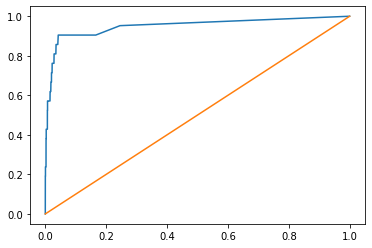

In [79]:
# Depth - None; Criteria: entropy; n_est = 7000
kf = StratifiedKFold(n_splits=5, random_state=123,  shuffle=True)
auc=[]
y_all=[]
y_pred_all=[]
for train_index, test_index in kf.split(df_x, df_y):
    X_train, X_test = df_x.iloc[train_index, :], df_x.iloc[test_index, :]
    y_train, y_test = df_y[train_index], df_y[test_index]
    print(X_train.shape,sum(y_train), X_test.shape,sum(y_test) )
    
    rus = SMOTE(random_state=42)
    res_X, res_Y = rus.fit_resample(X_train, y_train)
    print(res_X.shape, res_Y.sum())
    
    rf = RandomForestClassifier(n_estimators=7000, criterion= 'entropy', max_depth=None,
                                random_state=21, n_jobs=4, verbose=2)
    rf.fit(res_X, res_Y)
    
    pred_y = rf.predict_proba(X_test)
    pred_y=[item[1] for item in pred_y]
    y_all=y_all+ list(y_test)
    y_pred_all=y_pred_all+ list(pred_y)
    
    auc.append(roc_auc_score(y_test,pred_y))
    print(auc[-1], sum(y_test))
    fpr, tpr,x = roc_curve(y_test,pred_y)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.show()

#### overall AUC of model is 91% (across all points)

0.9098902265698117


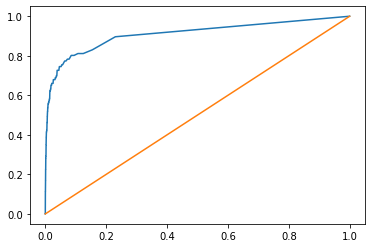

In [81]:
print(roc_auc_score(y_all, y_pred_all))

fpr, tpr,x = roc_curve(y_all, y_pred_all)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.show()

In [130]:
# cut-off for best f-1 score
f1= []
acc=[]
score = np.arange(0,1.001, 0.001)
for i in score:
    pred_y1 = [1 if item>i else 0 for item in y_pred_all ]
    f1.append(f1_score(y_all, pred_y1)) 
    acc.append(accuracy_score(y_all, pred_y1))

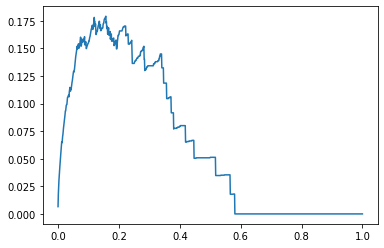

In [131]:
plt.plot(score, f1)

#### classification report with 75% recall and False postive rate of 5% 

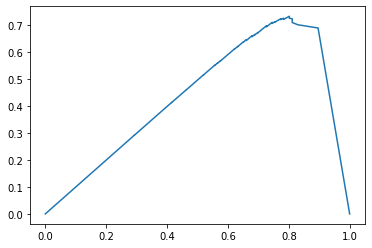

In [155]:
# maximizing true postive rate and true negative rate (sensitivity + specificity )
plt.plot(tpr, tpr*(1-fpr))

In [157]:
print(max(tpr*(1-fpr)))
tpr[np.argmax(tpr*(1-fpr))]

0.7335339854717436


0.8018867924528302

In [154]:
sc = 0.002 # 75% sensitivity and Specificity 95%
sc = 0.0008 # 80% sensitivity and Specificity 91%

pred_y1 = [1 if item>sc else 0 for item in y_pred_all ]
# pred_y1= rf.predict(test_x)
print(classification_report(y_all, pred_y1))
confusion_matrix(y_all, pred_y1)

              precision    recall  f1-score   support

           0       1.00      0.91      0.96    124390
           1       0.01      0.80      0.02       106

    accuracy                           0.91    124496
   macro avg       0.50      0.86      0.49    124496
weighted avg       1.00      0.91      0.95    124496



array([[113787,  10603],
       [    21,     85]], dtype=int64)

## Recommendation 
### Model can implemented in production with score threshold as 0.0008 to predict failure. Overall recall rate is 80% and specificity as 91% 

# End